In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "resnet_edl_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = "0:1"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 87612 images
Dataset type val label type: species


Loaded 21905 images
Dataset type test label type: species


Loaded 81589 images
Dataset type test label type: species


Loaded 78017 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:1 x3j6ny6h


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-x3j6ny6h:best, 58.48MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.4


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    fpi = 10

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                              | 0/685 [00:00<?, ?it/s]

  0%|▏                                                                                                     | 1/685 [00:00<08:25,  1.35it/s]

  0%|▎                                                                                                     | 2/685 [00:00<04:56,  2.30it/s]

  0%|▍                                                                                                     | 3/685 [00:01<03:49,  2.97it/s]

  1%|▌                                                                                                     | 4/685 [00:01<03:18,  3.44it/s]

  1%|▋                                                                                                     | 5/685 [00:01<03:00,  3.77it/s]

  1%|▉                                                                                                     | 6/685 [00:01<02:49,  4.00it/s]

  1%|█                                                                                                     | 7/685 [00:02<02:42,  4.16it/s]

  1%|█▏                                                                                                    | 8/685 [00:02<02:38,  4.27it/s]

  1%|█▎                                                                                                    | 9/685 [00:02<02:35,  4.36it/s]

  1%|█▍                                                                                                   | 10/685 [00:02<02:33,  4.41it/s]

  2%|█▌                                                                                                   | 11/685 [00:02<02:31,  4.45it/s]

  2%|█▊                                                                                                   | 12/685 [00:03<02:30,  4.48it/s]

  2%|█▉                                                                                                   | 13/685 [00:03<02:29,  4.50it/s]

  2%|██                                                                                                   | 14/685 [00:03<02:28,  4.51it/s]

  2%|██▏                                                                                                  | 15/685 [00:03<02:28,  4.52it/s]

  2%|██▎                                                                                                  | 16/685 [00:04<02:27,  4.53it/s]

  2%|██▌                                                                                                  | 17/685 [00:04<02:27,  4.53it/s]

  3%|██▋                                                                                                  | 18/685 [00:04<02:27,  4.53it/s]

  3%|██▊                                                                                                  | 19/685 [00:04<02:26,  4.53it/s]

  3%|██▉                                                                                                  | 20/685 [00:04<02:26,  4.54it/s]

  3%|███                                                                                                  | 21/685 [00:05<02:26,  4.54it/s]

  3%|███▏                                                                                                 | 22/685 [00:05<02:26,  4.54it/s]

  3%|███▍                                                                                                 | 23/685 [00:05<02:25,  4.54it/s]

  4%|███▌                                                                                                 | 24/685 [00:05<02:25,  4.54it/s]

  4%|███▋                                                                                                 | 25/685 [00:06<02:25,  4.54it/s]

  4%|███▊                                                                                                 | 26/685 [00:06<02:25,  4.54it/s]

  4%|███▉                                                                                                 | 27/685 [00:06<02:24,  4.54it/s]

  4%|████▏                                                                                                | 28/685 [00:06<02:24,  4.54it/s]

  4%|████▎                                                                                                | 29/685 [00:06<02:24,  4.54it/s]

  4%|████▍                                                                                                | 30/685 [00:07<02:24,  4.54it/s]

  5%|████▌                                                                                                | 31/685 [00:07<02:23,  4.54it/s]

  5%|████▋                                                                                                | 32/685 [00:07<02:23,  4.54it/s]

  5%|████▊                                                                                                | 33/685 [00:07<02:23,  4.54it/s]

  5%|█████                                                                                                | 34/685 [00:08<02:23,  4.54it/s]

  5%|█████▏                                                                                               | 35/685 [00:08<02:23,  4.54it/s]

  5%|█████▎                                                                                               | 36/685 [00:08<02:22,  4.54it/s]

  5%|█████▍                                                                                               | 37/685 [00:08<02:22,  4.54it/s]

  6%|█████▌                                                                                               | 38/685 [00:08<02:22,  4.54it/s]

  6%|█████▊                                                                                               | 39/685 [00:09<02:22,  4.54it/s]

  6%|█████▉                                                                                               | 40/685 [00:09<02:21,  4.54it/s]

  6%|██████                                                                                               | 41/685 [00:09<02:21,  4.54it/s]

  6%|██████▏                                                                                              | 42/685 [00:09<02:21,  4.54it/s]

  6%|██████▎                                                                                              | 43/685 [00:09<02:21,  4.54it/s]

  6%|██████▍                                                                                              | 44/685 [00:10<02:21,  4.54it/s]

  7%|██████▋                                                                                              | 45/685 [00:10<02:20,  4.54it/s]

  7%|██████▊                                                                                              | 46/685 [00:10<02:20,  4.54it/s]

  7%|██████▉                                                                                              | 47/685 [00:10<02:20,  4.54it/s]

  7%|███████                                                                                              | 48/685 [00:11<02:20,  4.54it/s]

  7%|███████▏                                                                                             | 49/685 [00:11<02:19,  4.54it/s]

  7%|███████▎                                                                                             | 50/685 [00:11<02:19,  4.54it/s]

  7%|███████▌                                                                                             | 51/685 [00:11<02:19,  4.54it/s]

  8%|███████▋                                                                                             | 52/685 [00:11<02:19,  4.54it/s]

  8%|███████▊                                                                                             | 53/685 [00:12<02:19,  4.54it/s]

  8%|███████▉                                                                                             | 54/685 [00:12<02:18,  4.54it/s]

  8%|████████                                                                                             | 55/685 [00:12<02:18,  4.54it/s]

  8%|████████▎                                                                                            | 56/685 [00:12<02:18,  4.54it/s]

  8%|████████▍                                                                                            | 57/685 [00:13<02:18,  4.54it/s]

  8%|████████▌                                                                                            | 58/685 [00:13<02:17,  4.54it/s]

  9%|████████▋                                                                                            | 59/685 [00:13<02:17,  4.54it/s]

  9%|████████▊                                                                                            | 60/685 [00:13<02:17,  4.54it/s]

  9%|████████▉                                                                                            | 61/685 [00:13<02:17,  4.54it/s]

  9%|█████████▏                                                                                           | 62/685 [00:14<02:17,  4.54it/s]

  9%|█████████▎                                                                                           | 63/685 [00:14<02:16,  4.55it/s]

  9%|█████████▍                                                                                           | 64/685 [00:14<02:16,  4.54it/s]

  9%|█████████▌                                                                                           | 65/685 [00:14<02:16,  4.54it/s]

 10%|█████████▋                                                                                           | 66/685 [00:15<02:16,  4.54it/s]

 10%|█████████▉                                                                                           | 67/685 [00:15<02:16,  4.54it/s]

 10%|██████████                                                                                           | 68/685 [00:15<02:15,  4.54it/s]

 10%|██████████▏                                                                                          | 69/685 [00:15<02:15,  4.54it/s]

 10%|██████████▎                                                                                          | 70/685 [00:15<02:15,  4.54it/s]

 10%|██████████▍                                                                                          | 71/685 [00:16<02:15,  4.54it/s]

 11%|██████████▌                                                                                          | 72/685 [00:16<02:14,  4.54it/s]

 11%|██████████▊                                                                                          | 73/685 [00:16<02:14,  4.55it/s]

 11%|██████████▉                                                                                          | 74/685 [00:16<02:14,  4.55it/s]

 11%|███████████                                                                                          | 75/685 [00:17<02:14,  4.55it/s]

 11%|███████████▏                                                                                         | 76/685 [00:17<02:13,  4.55it/s]

 11%|███████████▎                                                                                         | 77/685 [00:17<02:13,  4.55it/s]

 11%|███████████▌                                                                                         | 78/685 [00:17<02:13,  4.55it/s]

 12%|███████████▋                                                                                         | 79/685 [00:17<02:13,  4.55it/s]

 12%|███████████▊                                                                                         | 80/685 [00:18<02:12,  4.55it/s]

 12%|███████████▉                                                                                         | 81/685 [00:18<02:12,  4.55it/s]

 12%|████████████                                                                                         | 82/685 [00:18<02:12,  4.55it/s]

 12%|████████████▏                                                                                        | 83/685 [00:18<02:12,  4.55it/s]

 12%|████████████▍                                                                                        | 84/685 [00:19<02:12,  4.55it/s]

 12%|████████████▌                                                                                        | 85/685 [00:19<02:11,  4.55it/s]

 13%|████████████▋                                                                                        | 86/685 [00:19<02:11,  4.55it/s]

 13%|████████████▊                                                                                        | 87/685 [00:19<02:11,  4.55it/s]

 13%|████████████▉                                                                                        | 88/685 [00:19<02:11,  4.55it/s]

 13%|█████████████                                                                                        | 89/685 [00:20<02:11,  4.55it/s]

 13%|█████████████▎                                                                                       | 90/685 [00:20<02:10,  4.55it/s]

 13%|█████████████▍                                                                                       | 91/685 [00:20<02:10,  4.55it/s]

 13%|█████████████▌                                                                                       | 92/685 [00:20<02:10,  4.55it/s]

 14%|█████████████▋                                                                                       | 93/685 [00:20<02:10,  4.55it/s]

 14%|█████████████▊                                                                                       | 94/685 [00:21<02:10,  4.55it/s]

 14%|██████████████                                                                                       | 95/685 [00:21<02:09,  4.54it/s]

 14%|██████████████▏                                                                                      | 96/685 [00:21<02:09,  4.55it/s]

 14%|██████████████▎                                                                                      | 97/685 [00:21<02:09,  4.55it/s]

 14%|██████████████▍                                                                                      | 98/685 [00:22<02:09,  4.55it/s]

 14%|██████████████▌                                                                                      | 99/685 [00:22<02:08,  4.55it/s]

 15%|██████████████▌                                                                                     | 100/685 [00:22<02:08,  4.55it/s]

 15%|██████████████▋                                                                                     | 101/685 [00:22<02:08,  4.55it/s]

 15%|██████████████▉                                                                                     | 102/685 [00:22<02:08,  4.55it/s]

 15%|███████████████                                                                                     | 103/685 [00:23<02:07,  4.55it/s]

 15%|███████████████▏                                                                                    | 104/685 [00:23<02:07,  4.55it/s]

 15%|███████████████▎                                                                                    | 105/685 [00:23<02:07,  4.55it/s]

 15%|███████████████▍                                                                                    | 106/685 [00:23<02:07,  4.55it/s]

 16%|███████████████▌                                                                                    | 107/685 [00:24<02:07,  4.55it/s]

 16%|███████████████▊                                                                                    | 108/685 [00:24<02:06,  4.55it/s]

 16%|███████████████▉                                                                                    | 109/685 [00:24<02:06,  4.55it/s]

 16%|████████████████                                                                                    | 110/685 [00:24<02:06,  4.55it/s]

 16%|████████████████▏                                                                                   | 111/685 [00:24<02:06,  4.55it/s]

 16%|████████████████▎                                                                                   | 112/685 [00:25<02:05,  4.55it/s]

 16%|████████████████▍                                                                                   | 113/685 [00:25<02:05,  4.55it/s]

 17%|████████████████▋                                                                                   | 114/685 [00:25<02:05,  4.55it/s]

 17%|████████████████▊                                                                                   | 115/685 [00:25<02:05,  4.55it/s]

 17%|████████████████▉                                                                                   | 116/685 [00:26<02:05,  4.55it/s]

 17%|█████████████████                                                                                   | 117/685 [00:26<02:04,  4.55it/s]

 17%|█████████████████▏                                                                                  | 118/685 [00:26<02:04,  4.55it/s]

 17%|█████████████████▎                                                                                  | 119/685 [00:26<02:04,  4.55it/s]

 18%|█████████████████▌                                                                                  | 120/685 [00:26<02:04,  4.55it/s]

 18%|█████████████████▋                                                                                  | 121/685 [00:27<02:04,  4.55it/s]

 18%|█████████████████▊                                                                                  | 122/685 [00:27<02:03,  4.55it/s]

 18%|█████████████████▉                                                                                  | 123/685 [00:27<02:03,  4.55it/s]

 18%|██████████████████                                                                                  | 124/685 [00:27<02:03,  4.55it/s]

 18%|██████████████████▏                                                                                 | 125/685 [00:28<02:03,  4.55it/s]

 18%|██████████████████▍                                                                                 | 126/685 [00:28<02:02,  4.55it/s]

 19%|██████████████████▌                                                                                 | 127/685 [00:28<02:02,  4.55it/s]

 19%|██████████████████▋                                                                                 | 128/685 [00:28<02:02,  4.55it/s]

 19%|██████████████████▊                                                                                 | 129/685 [00:28<02:02,  4.55it/s]

 19%|██████████████████▉                                                                                 | 130/685 [00:29<02:02,  4.55it/s]

 19%|███████████████████                                                                                 | 131/685 [00:29<02:01,  4.55it/s]

 19%|███████████████████▎                                                                                | 132/685 [00:29<02:01,  4.55it/s]

 19%|███████████████████▍                                                                                | 133/685 [00:29<02:01,  4.55it/s]

 20%|███████████████████▌                                                                                | 134/685 [00:30<02:01,  4.55it/s]

 20%|███████████████████▋                                                                                | 135/685 [00:30<02:00,  4.55it/s]

 20%|███████████████████▊                                                                                | 136/685 [00:30<02:00,  4.55it/s]

 20%|████████████████████                                                                                | 137/685 [00:30<02:00,  4.55it/s]

 20%|████████████████████▏                                                                               | 138/685 [00:30<02:00,  4.55it/s]

 20%|████████████████████▎                                                                               | 139/685 [00:31<01:59,  4.55it/s]

 20%|████████████████████▍                                                                               | 140/685 [00:31<01:59,  4.55it/s]

 21%|████████████████████▌                                                                               | 141/685 [00:31<01:59,  4.55it/s]

 21%|████████████████████▋                                                                               | 142/685 [00:31<01:59,  4.55it/s]

 21%|████████████████████▉                                                                               | 143/685 [00:31<01:59,  4.55it/s]

 21%|█████████████████████                                                                               | 144/685 [00:32<01:58,  4.55it/s]

 21%|█████████████████████▏                                                                              | 145/685 [00:32<01:58,  4.55it/s]

 21%|█████████████████████▎                                                                              | 146/685 [00:32<01:58,  4.55it/s]

 21%|█████████████████████▍                                                                              | 147/685 [00:32<01:58,  4.55it/s]

 22%|█████████████████████▌                                                                              | 148/685 [00:33<01:58,  4.55it/s]

 22%|█████████████████████▊                                                                              | 149/685 [00:33<01:57,  4.55it/s]

 22%|█████████████████████▉                                                                              | 150/685 [00:33<01:57,  4.55it/s]

 22%|██████████████████████                                                                              | 151/685 [00:33<01:57,  4.55it/s]

 22%|██████████████████████▏                                                                             | 152/685 [00:33<01:57,  4.55it/s]

 22%|██████████████████████▎                                                                             | 153/685 [00:34<01:56,  4.55it/s]

 22%|██████████████████████▍                                                                             | 154/685 [00:34<01:56,  4.55it/s]

 23%|██████████████████████▋                                                                             | 155/685 [00:34<01:56,  4.55it/s]

 23%|██████████████████████▊                                                                             | 156/685 [00:34<01:56,  4.55it/s]

 23%|██████████████████████▉                                                                             | 157/685 [00:35<01:56,  4.55it/s]

 23%|███████████████████████                                                                             | 158/685 [00:35<01:55,  4.55it/s]

 23%|███████████████████████▏                                                                            | 159/685 [00:35<01:55,  4.55it/s]

 23%|███████████████████████▎                                                                            | 160/685 [00:35<01:55,  4.55it/s]

 24%|███████████████████████▌                                                                            | 161/685 [00:35<01:55,  4.55it/s]

 24%|███████████████████████▋                                                                            | 162/685 [00:36<01:55,  4.55it/s]

 24%|███████████████████████▊                                                                            | 163/685 [00:36<01:54,  4.55it/s]

 24%|███████████████████████▉                                                                            | 164/685 [00:36<01:54,  4.55it/s]

 24%|████████████████████████                                                                            | 165/685 [00:36<01:54,  4.55it/s]

 24%|████████████████████████▏                                                                           | 166/685 [00:37<01:54,  4.55it/s]

 24%|████████████████████████▍                                                                           | 167/685 [00:37<01:53,  4.55it/s]

 25%|████████████████████████▌                                                                           | 168/685 [00:37<01:53,  4.55it/s]

 25%|████████████████████████▋                                                                           | 169/685 [00:37<01:53,  4.55it/s]

 25%|████████████████████████▊                                                                           | 170/685 [00:37<01:53,  4.55it/s]

 25%|████████████████████████▉                                                                           | 171/685 [00:38<01:52,  4.55it/s]

 25%|█████████████████████████                                                                           | 172/685 [00:38<01:52,  4.55it/s]

 25%|█████████████████████████▎                                                                          | 173/685 [00:38<01:52,  4.55it/s]

 25%|█████████████████████████▍                                                                          | 174/685 [00:38<01:52,  4.55it/s]

 26%|█████████████████████████▌                                                                          | 175/685 [00:39<01:52,  4.55it/s]

 26%|█████████████████████████▋                                                                          | 176/685 [00:39<01:51,  4.55it/s]

 26%|█████████████████████████▊                                                                          | 177/685 [00:39<01:51,  4.55it/s]

 26%|█████████████████████████▉                                                                          | 178/685 [00:39<01:51,  4.55it/s]

 26%|██████████████████████████▏                                                                         | 179/685 [00:39<01:51,  4.55it/s]

 26%|██████████████████████████▎                                                                         | 180/685 [00:40<01:50,  4.55it/s]

 26%|██████████████████████████▍                                                                         | 181/685 [00:40<01:50,  4.55it/s]

 27%|██████████████████████████▌                                                                         | 182/685 [00:40<01:50,  4.55it/s]

 27%|██████████████████████████▋                                                                         | 183/685 [00:40<01:50,  4.55it/s]

 27%|██████████████████████████▊                                                                         | 184/685 [00:40<01:50,  4.55it/s]

 27%|███████████████████████████                                                                         | 185/685 [00:41<01:49,  4.55it/s]

 27%|███████████████████████████▏                                                                        | 186/685 [00:41<01:49,  4.55it/s]

 27%|███████████████████████████▎                                                                        | 187/685 [00:41<01:49,  4.55it/s]

 27%|███████████████████████████▍                                                                        | 188/685 [00:41<01:49,  4.55it/s]

 28%|███████████████████████████▌                                                                        | 189/685 [00:42<01:48,  4.55it/s]

 28%|███████████████████████████▋                                                                        | 190/685 [00:42<01:48,  4.55it/s]

 28%|███████████████████████████▉                                                                        | 191/685 [00:42<01:48,  4.55it/s]

 28%|████████████████████████████                                                                        | 192/685 [00:42<01:48,  4.55it/s]

 28%|████████████████████████████▏                                                                       | 193/685 [00:42<01:48,  4.55it/s]

 28%|████████████████████████████▎                                                                       | 194/685 [00:43<01:47,  4.55it/s]

 28%|████████████████████████████▍                                                                       | 195/685 [00:43<01:47,  4.55it/s]

 29%|████████████████████████████▌                                                                       | 196/685 [00:43<01:47,  4.55it/s]

 29%|████████████████████████████▊                                                                       | 197/685 [00:43<01:47,  4.54it/s]

 29%|████████████████████████████▉                                                                       | 198/685 [00:44<01:47,  4.55it/s]

 29%|█████████████████████████████                                                                       | 199/685 [00:44<01:46,  4.55it/s]

 29%|█████████████████████████████▏                                                                      | 200/685 [00:44<01:46,  4.55it/s]

 29%|█████████████████████████████▎                                                                      | 201/685 [00:44<01:46,  4.55it/s]

 29%|█████████████████████████████▍                                                                      | 202/685 [00:44<01:46,  4.55it/s]

 30%|█████████████████████████████▋                                                                      | 203/685 [00:45<01:45,  4.55it/s]

 30%|█████████████████████████████▊                                                                      | 204/685 [00:45<01:45,  4.55it/s]

 30%|█████████████████████████████▉                                                                      | 205/685 [00:45<01:45,  4.55it/s]

 30%|██████████████████████████████                                                                      | 206/685 [00:45<01:45,  4.55it/s]

 30%|██████████████████████████████▏                                                                     | 207/685 [00:46<01:45,  4.55it/s]

 30%|██████████████████████████████▎                                                                     | 208/685 [00:46<01:44,  4.55it/s]

 31%|██████████████████████████████▌                                                                     | 209/685 [00:46<01:44,  4.55it/s]

 31%|██████████████████████████████▋                                                                     | 210/685 [00:46<01:44,  4.55it/s]

 31%|██████████████████████████████▊                                                                     | 211/685 [00:46<01:44,  4.55it/s]

 31%|██████████████████████████████▉                                                                     | 212/685 [00:47<01:43,  4.55it/s]

 31%|███████████████████████████████                                                                     | 213/685 [00:47<01:43,  4.55it/s]

 31%|███████████████████████████████▏                                                                    | 214/685 [00:47<01:43,  4.55it/s]

 31%|███████████████████████████████▍                                                                    | 215/685 [00:47<01:43,  4.55it/s]

 32%|███████████████████████████████▌                                                                    | 216/685 [00:48<01:43,  4.55it/s]

 32%|███████████████████████████████▋                                                                    | 217/685 [00:48<01:42,  4.55it/s]

 32%|███████████████████████████████▊                                                                    | 218/685 [00:48<01:42,  4.55it/s]

 32%|███████████████████████████████▉                                                                    | 219/685 [00:48<01:42,  4.55it/s]

 32%|████████████████████████████████                                                                    | 220/685 [00:48<01:42,  4.55it/s]

 32%|████████████████████████████████▎                                                                   | 221/685 [00:49<01:42,  4.55it/s]

 32%|████████████████████████████████▍                                                                   | 222/685 [00:49<01:41,  4.55it/s]

 33%|████████████████████████████████▌                                                                   | 223/685 [00:49<01:41,  4.55it/s]

 33%|████████████████████████████████▋                                                                   | 224/685 [00:49<01:41,  4.55it/s]

 33%|████████████████████████████████▊                                                                   | 225/685 [00:50<01:41,  4.55it/s]

 33%|████████████████████████████████▉                                                                   | 226/685 [00:50<01:40,  4.55it/s]

 33%|█████████████████████████████████▏                                                                  | 227/685 [00:50<01:40,  4.55it/s]

 33%|█████████████████████████████████▎                                                                  | 228/685 [00:50<01:40,  4.55it/s]

 33%|█████████████████████████████████▍                                                                  | 229/685 [00:50<01:40,  4.55it/s]

 34%|█████████████████████████████████▌                                                                  | 230/685 [00:51<01:39,  4.55it/s]

 34%|█████████████████████████████████▋                                                                  | 231/685 [00:51<01:39,  4.55it/s]

 34%|█████████████████████████████████▊                                                                  | 232/685 [00:51<01:39,  4.55it/s]

 34%|██████████████████████████████████                                                                  | 233/685 [00:51<01:39,  4.55it/s]

 34%|██████████████████████████████████▏                                                                 | 234/685 [00:51<01:39,  4.55it/s]

 34%|██████████████████████████████████▎                                                                 | 235/685 [00:52<01:38,  4.55it/s]

 34%|██████████████████████████████████▍                                                                 | 236/685 [00:52<01:38,  4.55it/s]

 35%|██████████████████████████████████▌                                                                 | 237/685 [00:52<01:38,  4.55it/s]

 35%|██████████████████████████████████▋                                                                 | 238/685 [00:52<01:38,  4.55it/s]

 35%|██████████████████████████████████▉                                                                 | 239/685 [00:53<01:38,  4.55it/s]

 35%|███████████████████████████████████                                                                 | 240/685 [00:53<01:37,  4.55it/s]

 35%|███████████████████████████████████▏                                                                | 241/685 [00:53<01:37,  4.55it/s]

 35%|███████████████████████████████████▎                                                                | 242/685 [00:53<01:37,  4.55it/s]

 35%|███████████████████████████████████▍                                                                | 243/685 [00:53<01:37,  4.55it/s]

 36%|███████████████████████████████████▌                                                                | 244/685 [00:54<01:36,  4.55it/s]

 36%|███████████████████████████████████▊                                                                | 245/685 [00:54<01:36,  4.55it/s]

 36%|███████████████████████████████████▉                                                                | 246/685 [00:54<01:36,  4.55it/s]

 36%|████████████████████████████████████                                                                | 247/685 [00:54<01:36,  4.55it/s]

 36%|████████████████████████████████████▏                                                               | 248/685 [00:55<01:36,  4.55it/s]

 36%|████████████████████████████████████▎                                                               | 249/685 [00:55<01:35,  4.55it/s]

 36%|████████████████████████████████████▍                                                               | 250/685 [00:55<01:35,  4.55it/s]

 37%|████████████████████████████████████▋                                                               | 251/685 [00:55<01:35,  4.55it/s]

 37%|████████████████████████████████████▊                                                               | 252/685 [00:55<01:35,  4.55it/s]

 37%|████████████████████████████████████▉                                                               | 253/685 [00:56<01:35,  4.55it/s]

 37%|█████████████████████████████████████                                                               | 254/685 [00:56<01:34,  4.55it/s]

 37%|█████████████████████████████████████▏                                                              | 255/685 [00:56<01:34,  4.55it/s]

 37%|█████████████████████████████████████▎                                                              | 256/685 [00:56<01:34,  4.55it/s]

 38%|█████████████████████████████████████▌                                                              | 257/685 [00:57<01:34,  4.55it/s]

 38%|█████████████████████████████████████▋                                                              | 258/685 [00:57<01:33,  4.55it/s]

 38%|█████████████████████████████████████▊                                                              | 259/685 [00:57<01:33,  4.55it/s]

 38%|█████████████████████████████████████▉                                                              | 260/685 [00:57<01:33,  4.55it/s]

 38%|██████████████████████████████████████                                                              | 261/685 [00:57<01:33,  4.55it/s]

 38%|██████████████████████████████████████▏                                                             | 262/685 [00:58<01:32,  4.55it/s]

 38%|██████████████████████████████████████▍                                                             | 263/685 [00:58<01:32,  4.55it/s]

 39%|██████████████████████████████████████▌                                                             | 264/685 [00:58<01:32,  4.55it/s]

 39%|██████████████████████████████████████▋                                                             | 265/685 [00:58<01:32,  4.55it/s]

 39%|██████████████████████████████████████▊                                                             | 266/685 [00:59<01:32,  4.55it/s]

 39%|██████████████████████████████████████▉                                                             | 267/685 [00:59<01:31,  4.55it/s]

 39%|███████████████████████████████████████                                                             | 268/685 [00:59<01:31,  4.55it/s]

 39%|███████████████████████████████████████▎                                                            | 269/685 [00:59<01:31,  4.55it/s]

 39%|███████████████████████████████████████▍                                                            | 270/685 [00:59<01:31,  4.55it/s]

 40%|███████████████████████████████████████▌                                                            | 271/685 [01:00<01:30,  4.55it/s]

 40%|███████████████████████████████████████▋                                                            | 272/685 [01:00<01:30,  4.55it/s]

 40%|███████████████████████████████████████▊                                                            | 273/685 [01:00<01:30,  4.55it/s]

 40%|████████████████████████████████████████                                                            | 274/685 [01:00<01:30,  4.55it/s]

 40%|████████████████████████████████████████▏                                                           | 275/685 [01:00<01:30,  4.55it/s]

 40%|████████████████████████████████████████▎                                                           | 276/685 [01:01<01:29,  4.55it/s]

 40%|████████████████████████████████████████▍                                                           | 277/685 [01:01<01:29,  4.55it/s]

 41%|████████████████████████████████████████▌                                                           | 278/685 [01:01<01:29,  4.55it/s]

 41%|████████████████████████████████████████▋                                                           | 279/685 [01:01<01:29,  4.55it/s]

 41%|████████████████████████████████████████▉                                                           | 280/685 [01:02<01:29,  4.55it/s]

 41%|█████████████████████████████████████████                                                           | 281/685 [01:02<01:28,  4.55it/s]

 41%|█████████████████████████████████████████▏                                                          | 282/685 [01:02<01:28,  4.55it/s]

 41%|█████████████████████████████████████████▎                                                          | 283/685 [01:02<01:28,  4.55it/s]

 41%|█████████████████████████████████████████▍                                                          | 284/685 [01:02<01:28,  4.55it/s]

 42%|█████████████████████████████████████████▌                                                          | 285/685 [01:03<01:27,  4.55it/s]

 42%|█████████████████████████████████████████▊                                                          | 286/685 [01:03<01:27,  4.55it/s]

 42%|█████████████████████████████████████████▉                                                          | 287/685 [01:03<01:27,  4.55it/s]

 42%|██████████████████████████████████████████                                                          | 288/685 [01:03<01:27,  4.55it/s]

 42%|██████████████████████████████████████████▏                                                         | 289/685 [01:04<01:27,  4.55it/s]

 42%|██████████████████████████████████████████▎                                                         | 290/685 [01:04<01:26,  4.55it/s]

 42%|██████████████████████████████████████████▍                                                         | 291/685 [01:04<01:26,  4.55it/s]

 43%|██████████████████████████████████████████▋                                                         | 292/685 [01:04<01:26,  4.55it/s]

 43%|██████████████████████████████████████████▊                                                         | 293/685 [01:04<01:26,  4.55it/s]

 43%|██████████████████████████████████████████▉                                                         | 294/685 [01:05<01:25,  4.55it/s]

 43%|███████████████████████████████████████████                                                         | 295/685 [01:05<01:25,  4.55it/s]

 43%|███████████████████████████████████████████▏                                                        | 296/685 [01:05<01:25,  4.55it/s]

 43%|███████████████████████████████████████████▎                                                        | 297/685 [01:05<01:25,  4.55it/s]

 44%|███████████████████████████████████████████▌                                                        | 298/685 [01:06<01:25,  4.55it/s]

 44%|███████████████████████████████████████████▋                                                        | 299/685 [01:06<01:24,  4.55it/s]

 44%|███████████████████████████████████████████▊                                                        | 300/685 [01:06<01:24,  4.55it/s]

 44%|███████████████████████████████████████████▉                                                        | 301/685 [01:06<01:24,  4.55it/s]

 44%|████████████████████████████████████████████                                                        | 302/685 [01:06<01:24,  4.55it/s]

 44%|████████████████████████████████████████████▏                                                       | 303/685 [01:07<01:23,  4.55it/s]

 44%|████████████████████████████████████████████▍                                                       | 304/685 [01:07<01:23,  4.55it/s]

 45%|████████████████████████████████████████████▌                                                       | 305/685 [01:07<01:23,  4.55it/s]

 45%|████████████████████████████████████████████▋                                                       | 306/685 [01:07<01:23,  4.55it/s]

 45%|████████████████████████████████████████████▊                                                       | 307/685 [01:08<01:23,  4.55it/s]

 45%|████████████████████████████████████████████▉                                                       | 308/685 [01:08<01:22,  4.55it/s]

 45%|█████████████████████████████████████████████                                                       | 309/685 [01:08<01:22,  4.55it/s]

 45%|█████████████████████████████████████████████▎                                                      | 310/685 [01:08<01:22,  4.55it/s]

 45%|█████████████████████████████████████████████▍                                                      | 311/685 [01:08<01:22,  4.55it/s]

 46%|█████████████████████████████████████████████▌                                                      | 312/685 [01:09<01:21,  4.55it/s]

 46%|█████████████████████████████████████████████▋                                                      | 313/685 [01:09<01:21,  4.55it/s]

 46%|█████████████████████████████████████████████▊                                                      | 314/685 [01:09<01:21,  4.55it/s]

 46%|█████████████████████████████████████████████▉                                                      | 315/685 [01:09<01:21,  4.55it/s]

 46%|██████████████████████████████████████████████▏                                                     | 316/685 [01:10<01:21,  4.55it/s]

 46%|██████████████████████████████████████████████▎                                                     | 317/685 [01:10<01:20,  4.55it/s]

 46%|██████████████████████████████████████████████▍                                                     | 318/685 [01:10<01:20,  4.55it/s]

 47%|██████████████████████████████████████████████▌                                                     | 319/685 [01:10<01:20,  4.55it/s]

 47%|██████████████████████████████████████████████▋                                                     | 320/685 [01:10<01:20,  4.55it/s]

 47%|██████████████████████████████████████████████▊                                                     | 321/685 [01:11<01:20,  4.55it/s]

 47%|███████████████████████████████████████████████                                                     | 322/685 [01:11<01:19,  4.55it/s]

 47%|███████████████████████████████████████████████▏                                                    | 323/685 [01:11<01:19,  4.55it/s]

 47%|███████████████████████████████████████████████▎                                                    | 324/685 [01:11<01:19,  4.55it/s]

 47%|███████████████████████████████████████████████▍                                                    | 325/685 [01:11<01:19,  4.55it/s]

 48%|███████████████████████████████████████████████▌                                                    | 326/685 [01:12<01:18,  4.55it/s]

 48%|███████████████████████████████████████████████▋                                                    | 327/685 [01:12<01:18,  4.55it/s]

 48%|███████████████████████████████████████████████▉                                                    | 328/685 [01:12<01:18,  4.55it/s]

 48%|████████████████████████████████████████████████                                                    | 329/685 [01:12<01:18,  4.55it/s]

 48%|████████████████████████████████████████████████▏                                                   | 330/685 [01:13<01:18,  4.55it/s]

 48%|████████████████████████████████████████████████▎                                                   | 331/685 [01:13<01:17,  4.55it/s]

 48%|████████████████████████████████████████████████▍                                                   | 332/685 [01:13<01:17,  4.55it/s]

 49%|████████████████████████████████████████████████▌                                                   | 333/685 [01:13<01:17,  4.55it/s]

 49%|████████████████████████████████████████████████▊                                                   | 334/685 [01:13<01:17,  4.55it/s]

 49%|████████████████████████████████████████████████▉                                                   | 335/685 [01:14<01:16,  4.55it/s]

 49%|█████████████████████████████████████████████████                                                   | 336/685 [01:14<01:16,  4.55it/s]

 49%|█████████████████████████████████████████████████▏                                                  | 337/685 [01:14<01:16,  4.55it/s]

 49%|█████████████████████████████████████████████████▎                                                  | 338/685 [01:14<01:16,  4.55it/s]

 49%|█████████████████████████████████████████████████▍                                                  | 339/685 [01:15<01:16,  4.55it/s]

 50%|█████████████████████████████████████████████████▋                                                  | 340/685 [01:15<01:15,  4.55it/s]

 50%|█████████████████████████████████████████████████▊                                                  | 341/685 [01:15<01:15,  4.55it/s]

 50%|█████████████████████████████████████████████████▉                                                  | 342/685 [01:15<01:15,  4.55it/s]

 50%|██████████████████████████████████████████████████                                                  | 343/685 [01:15<01:15,  4.55it/s]

 50%|██████████████████████████████████████████████████▏                                                 | 344/685 [01:16<01:14,  4.55it/s]

 50%|██████████████████████████████████████████████████▎                                                 | 345/685 [01:16<01:14,  4.55it/s]

 51%|██████████████████████████████████████████████████▌                                                 | 346/685 [01:16<01:14,  4.55it/s]

 51%|██████████████████████████████████████████████████▋                                                 | 347/685 [01:16<01:14,  4.55it/s]

 51%|██████████████████████████████████████████████████▊                                                 | 348/685 [01:17<01:14,  4.55it/s]

 51%|██████████████████████████████████████████████████▉                                                 | 349/685 [01:17<01:13,  4.55it/s]

 51%|███████████████████████████████████████████████████                                                 | 350/685 [01:17<01:13,  4.55it/s]

 51%|███████████████████████████████████████████████████▏                                                | 351/685 [01:17<01:13,  4.55it/s]

 51%|███████████████████████████████████████████████████▍                                                | 352/685 [01:17<01:13,  4.55it/s]

 52%|███████████████████████████████████████████████████▌                                                | 353/685 [01:18<01:13,  4.55it/s]

 52%|███████████████████████████████████████████████████▋                                                | 354/685 [01:18<01:12,  4.55it/s]

 52%|███████████████████████████████████████████████████▊                                                | 355/685 [01:18<01:12,  4.55it/s]

 52%|███████████████████████████████████████████████████▉                                                | 356/685 [01:18<01:12,  4.55it/s]

 52%|████████████████████████████████████████████████████                                                | 357/685 [01:19<01:12,  4.54it/s]

 52%|████████████████████████████████████████████████████▎                                               | 358/685 [01:19<01:11,  4.54it/s]

 52%|████████████████████████████████████████████████████▍                                               | 359/685 [01:19<01:11,  4.54it/s]

 53%|████████████████████████████████████████████████████▌                                               | 360/685 [01:19<01:11,  4.55it/s]

 53%|████████████████████████████████████████████████████▋                                               | 361/685 [01:19<01:11,  4.55it/s]

 53%|████████████████████████████████████████████████████▊                                               | 362/685 [01:20<01:11,  4.55it/s]

 53%|████████████████████████████████████████████████████▉                                               | 363/685 [01:20<01:10,  4.55it/s]

 53%|█████████████████████████████████████████████████████▏                                              | 364/685 [01:20<01:10,  4.55it/s]

 53%|█████████████████████████████████████████████████████▎                                              | 365/685 [01:20<01:10,  4.55it/s]

 53%|█████████████████████████████████████████████████████▍                                              | 366/685 [01:21<01:10,  4.55it/s]

 54%|█████████████████████████████████████████████████████▌                                              | 367/685 [01:21<01:09,  4.55it/s]

 54%|█████████████████████████████████████████████████████▋                                              | 368/685 [01:21<01:09,  4.55it/s]

 54%|█████████████████████████████████████████████████████▊                                              | 369/685 [01:21<01:09,  4.55it/s]

 54%|██████████████████████████████████████████████████████                                              | 370/685 [01:21<01:09,  4.55it/s]

 54%|██████████████████████████████████████████████████████▏                                             | 371/685 [01:22<01:09,  4.55it/s]

 54%|██████████████████████████████████████████████████████▎                                             | 372/685 [01:22<01:08,  4.55it/s]

 54%|██████████████████████████████████████████████████████▍                                             | 373/685 [01:22<01:08,  4.55it/s]

 55%|██████████████████████████████████████████████████████▌                                             | 374/685 [01:22<01:08,  4.54it/s]

 55%|██████████████████████████████████████████████████████▋                                             | 375/685 [01:22<01:08,  4.54it/s]

 55%|██████████████████████████████████████████████████████▉                                             | 376/685 [01:23<01:08,  4.54it/s]

 55%|███████████████████████████████████████████████████████                                             | 377/685 [01:23<01:07,  4.54it/s]

 55%|███████████████████████████████████████████████████████▏                                            | 378/685 [01:23<01:07,  4.54it/s]

 55%|███████████████████████████████████████████████████████▎                                            | 379/685 [01:23<01:07,  4.55it/s]

 55%|███████████████████████████████████████████████████████▍                                            | 380/685 [01:24<01:07,  4.54it/s]

 56%|███████████████████████████████████████████████████████▌                                            | 381/685 [01:24<01:06,  4.55it/s]

 56%|███████████████████████████████████████████████████████▊                                            | 382/685 [01:24<01:06,  4.55it/s]

 56%|███████████████████████████████████████████████████████▉                                            | 383/685 [01:24<01:06,  4.55it/s]

 56%|████████████████████████████████████████████████████████                                            | 384/685 [01:24<01:06,  4.55it/s]

 56%|████████████████████████████████████████████████████████▏                                           | 385/685 [01:25<01:05,  4.55it/s]

 56%|████████████████████████████████████████████████████████▎                                           | 386/685 [01:25<01:05,  4.55it/s]

 56%|████████████████████████████████████████████████████████▍                                           | 387/685 [01:25<01:05,  4.55it/s]

 57%|████████████████████████████████████████████████████████▋                                           | 388/685 [01:25<01:05,  4.55it/s]

 57%|████████████████████████████████████████████████████████▊                                           | 389/685 [01:26<01:05,  4.54it/s]

 57%|████████████████████████████████████████████████████████▉                                           | 390/685 [01:26<01:04,  4.54it/s]

 57%|█████████████████████████████████████████████████████████                                           | 391/685 [01:26<01:04,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▏                                          | 392/685 [01:26<01:04,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▎                                          | 393/685 [01:26<01:04,  4.55it/s]

 58%|█████████████████████████████████████████████████████████▌                                          | 394/685 [01:27<01:04,  4.55it/s]

 58%|█████████████████████████████████████████████████████████▋                                          | 395/685 [01:27<01:03,  4.55it/s]

 58%|█████████████████████████████████████████████████████████▊                                          | 396/685 [01:27<01:03,  4.55it/s]

 58%|█████████████████████████████████████████████████████████▉                                          | 397/685 [01:27<01:03,  4.55it/s]

 58%|██████████████████████████████████████████████████████████                                          | 398/685 [01:28<01:03,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▏                                         | 399/685 [01:28<01:02,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▍                                         | 400/685 [01:28<01:02,  4.55it/s]

 59%|██████████████████████████████████████████████████████████▌                                         | 401/685 [01:28<01:02,  4.55it/s]

 59%|██████████████████████████████████████████████████████████▋                                         | 402/685 [01:28<01:02,  4.55it/s]

 59%|██████████████████████████████████████████████████████████▊                                         | 403/685 [01:29<01:02,  4.55it/s]

 59%|██████████████████████████████████████████████████████████▉                                         | 404/685 [01:29<01:01,  4.55it/s]

 59%|███████████████████████████████████████████████████████████                                         | 405/685 [01:29<01:01,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▎                                        | 406/685 [01:29<01:01,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▍                                        | 407/685 [01:30<01:01,  4.55it/s]

 60%|███████████████████████████████████████████████████████████▌                                        | 408/685 [01:30<01:00,  4.55it/s]

 60%|███████████████████████████████████████████████████████████▋                                        | 409/685 [01:30<01:00,  4.55it/s]

 60%|███████████████████████████████████████████████████████████▊                                        | 410/685 [01:30<01:00,  4.55it/s]

 60%|████████████████████████████████████████████████████████████                                        | 411/685 [01:30<01:00,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▏                                       | 412/685 [01:31<00:59,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▎                                       | 413/685 [01:31<00:59,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▍                                       | 414/685 [01:31<00:59,  4.55it/s]

 61%|████████████████████████████████████████████████████████████▌                                       | 415/685 [01:31<00:59,  4.55it/s]

 61%|████████████████████████████████████████████████████████████▋                                       | 416/685 [01:31<00:59,  4.55it/s]

 61%|████████████████████████████████████████████████████████████▉                                       | 417/685 [01:32<00:58,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████                                       | 418/685 [01:32<00:58,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▏                                      | 419/685 [01:32<00:58,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▎                                      | 420/685 [01:32<00:58,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▍                                      | 421/685 [01:33<00:58,  4.55it/s]

 62%|█████████████████████████████████████████████████████████████▌                                      | 422/685 [01:33<00:57,  4.55it/s]

 62%|█████████████████████████████████████████████████████████████▊                                      | 423/685 [01:33<00:57,  4.55it/s]

 62%|█████████████████████████████████████████████████████████████▉                                      | 424/685 [01:33<00:57,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████                                      | 425/685 [01:33<00:57,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▏                                     | 426/685 [01:34<00:56,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▎                                     | 427/685 [01:34<00:56,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▍                                     | 428/685 [01:34<00:56,  4.55it/s]

 63%|██████████████████████████████████████████████████████████████▋                                     | 429/685 [01:34<00:56,  4.55it/s]

 63%|██████████████████████████████████████████████████████████████▊                                     | 430/685 [01:35<00:56,  4.55it/s]

 63%|██████████████████████████████████████████████████████████████▉                                     | 431/685 [01:35<00:55,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████                                     | 432/685 [01:35<00:55,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▏                                    | 433/685 [01:35<00:55,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▎                                    | 434/685 [01:35<00:55,  4.55it/s]

 64%|███████████████████████████████████████████████████████████████▌                                    | 435/685 [01:36<00:54,  4.55it/s]

 64%|███████████████████████████████████████████████████████████████▋                                    | 436/685 [01:36<00:54,  4.55it/s]

 64%|███████████████████████████████████████████████████████████████▊                                    | 437/685 [01:36<00:54,  4.55it/s]

 64%|███████████████████████████████████████████████████████████████▉                                    | 438/685 [01:36<00:54,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████                                    | 439/685 [01:37<00:54,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▏                                   | 440/685 [01:37<00:53,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▍                                   | 441/685 [01:37<00:53,  4.55it/s]

 65%|████████████████████████████████████████████████████████████████▌                                   | 442/685 [01:37<00:53,  4.55it/s]

 65%|████████████████████████████████████████████████████████████████▋                                   | 443/685 [01:37<00:53,  4.55it/s]

 65%|████████████████████████████████████████████████████████████████▊                                   | 444/685 [01:38<00:52,  4.55it/s]

 65%|████████████████████████████████████████████████████████████████▉                                   | 445/685 [01:38<00:52,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████                                   | 446/685 [01:38<00:52,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                  | 447/685 [01:38<00:52,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                  | 448/685 [01:39<00:52,  4.55it/s]

 66%|█████████████████████████████████████████████████████████████████▌                                  | 449/685 [01:39<00:51,  4.55it/s]

 66%|█████████████████████████████████████████████████████████████████▋                                  | 450/685 [01:39<00:51,  4.55it/s]

 66%|█████████████████████████████████████████████████████████████████▊                                  | 451/685 [01:39<00:51,  4.55it/s]

 66%|█████████████████████████████████████████████████████████████████▉                                  | 452/685 [01:39<00:51,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                 | 453/685 [01:40<00:51,  4.54it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                 | 454/685 [01:40<00:50,  4.54it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                 | 455/685 [01:40<00:50,  4.54it/s]

 67%|██████████████████████████████████████████████████████████████████▌                                 | 456/685 [01:40<00:50,  4.55it/s]

 67%|██████████████████████████████████████████████████████████████████▋                                 | 457/685 [01:41<00:50,  4.55it/s]

 67%|██████████████████████████████████████████████████████████████████▊                                 | 458/685 [01:41<00:49,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████                                 | 459/685 [01:41<00:49,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                | 460/685 [01:41<00:49,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▎                                | 461/685 [01:41<00:49,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                | 462/685 [01:42<00:49,  4.55it/s]

 68%|███████████████████████████████████████████████████████████████████▌                                | 463/685 [01:42<00:48,  4.55it/s]

 68%|███████████████████████████████████████████████████████████████████▋                                | 464/685 [01:42<00:48,  4.55it/s]

 68%|███████████████████████████████████████████████████████████████████▉                                | 465/685 [01:42<00:48,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████                                | 466/685 [01:42<00:48,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▏                               | 467/685 [01:43<00:47,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▎                               | 468/685 [01:43<00:47,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▍                               | 469/685 [01:43<00:47,  4.55it/s]

 69%|████████████████████████████████████████████████████████████████████▌                               | 470/685 [01:43<00:47,  4.55it/s]

 69%|████████████████████████████████████████████████████████████████████▊                               | 471/685 [01:44<00:47,  4.55it/s]

 69%|████████████████████████████████████████████████████████████████████▉                               | 472/685 [01:44<00:46,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████                               | 473/685 [01:44<00:46,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                              | 474/685 [01:44<00:46,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                              | 475/685 [01:44<00:46,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                              | 476/685 [01:45<00:45,  4.55it/s]

 70%|█████████████████████████████████████████████████████████████████████▋                              | 477/685 [01:45<00:45,  4.55it/s]

 70%|█████████████████████████████████████████████████████████████████████▊                              | 478/685 [01:45<00:45,  4.55it/s]

 70%|█████████████████████████████████████████████████████████████████████▉                              | 479/685 [01:45<00:45,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████                              | 480/685 [01:46<00:45,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                             | 481/685 [01:46<00:44,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                             | 482/685 [01:46<00:44,  4.55it/s]

 71%|██████████████████████████████████████████████████████████████████████▌                             | 483/685 [01:46<00:44,  4.55it/s]

 71%|██████████████████████████████████████████████████████████████████████▋                             | 484/685 [01:46<00:44,  4.55it/s]

 71%|██████████████████████████████████████████████████████████████████████▊                             | 485/685 [01:47<00:43,  4.55it/s]

 71%|██████████████████████████████████████████████████████████████████████▉                             | 486/685 [01:47<00:43,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████                             | 487/685 [01:47<00:43,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▏                            | 488/685 [01:47<00:43,  4.54it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                            | 489/685 [01:48<00:43,  4.55it/s]

 72%|███████████████████████████████████████████████████████████████████████▌                            | 490/685 [01:48<00:42,  4.54it/s]

 72%|███████████████████████████████████████████████████████████████████████▋                            | 491/685 [01:48<00:42,  4.55it/s]

 72%|███████████████████████████████████████████████████████████████████████▊                            | 492/685 [01:48<00:42,  4.55it/s]

 72%|███████████████████████████████████████████████████████████████████████▉                            | 493/685 [01:48<00:42,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████                            | 494/685 [01:49<00:42,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                           | 495/685 [01:49<00:41,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                           | 496/685 [01:49<00:41,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████▌                           | 497/685 [01:49<00:41,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████▋                           | 498/685 [01:50<00:41,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████▊                           | 499/685 [01:50<00:40,  4.55it/s]

 73%|████████████████████████████████████████████████████████████████████████▉                           | 500/685 [01:50<00:40,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████▏                          | 501/685 [01:50<00:40,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                          | 502/685 [01:50<00:40,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                          | 503/685 [01:51<00:40,  4.55it/s]

 74%|█████████████████████████████████████████████████████████████████████████▌                          | 504/685 [01:51<00:39,  4.55it/s]

 74%|█████████████████████████████████████████████████████████████████████████▋                          | 505/685 [01:51<00:39,  4.55it/s]

 74%|█████████████████████████████████████████████████████████████████████████▊                          | 506/685 [01:51<00:39,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████                          | 507/685 [01:52<00:39,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▏                         | 508/685 [01:52<00:38,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                         | 509/685 [01:52<00:38,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                         | 510/685 [01:52<00:38,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████▌                         | 511/685 [01:52<00:38,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████▋                         | 512/685 [01:53<00:38,  4.54it/s]

 75%|██████████████████████████████████████████████████████████████████████████▉                         | 513/685 [01:53<00:37,  4.54it/s]

 75%|███████████████████████████████████████████████████████████████████████████                         | 514/685 [01:53<00:37,  4.54it/s]

 75%|███████████████████████████████████████████████████████████████████████████▏                        | 515/685 [01:53<00:37,  4.54it/s]

 75%|███████████████████████████████████████████████████████████████████████████▎                        | 516/685 [01:53<00:37,  4.54it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                        | 517/685 [01:54<00:36,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████▌                        | 518/685 [01:54<00:36,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████▊                        | 519/685 [01:54<00:36,  4.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████▉                        | 520/685 [01:54<00:36,  4.54it/s]

 76%|████████████████████████████████████████████████████████████████████████████                        | 521/685 [01:55<00:36,  4.54it/s]

 76%|████████████████████████████████████████████████████████████████████████████▏                       | 522/685 [01:55<00:35,  4.54it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                       | 523/685 [01:55<00:35,  4.54it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                       | 524/685 [01:55<00:35,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▋                       | 525/685 [01:55<00:35,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▊                       | 526/685 [01:56<00:35,  4.54it/s]

 77%|████████████████████████████████████████████████████████████████████████████▉                       | 527/685 [01:56<00:34,  4.54it/s]

 77%|█████████████████████████████████████████████████████████████████████████████                       | 528/685 [01:56<00:34,  4.54it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▏                      | 529/685 [01:56<00:34,  4.54it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                      | 530/685 [01:57<00:34,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▌                      | 531/685 [01:57<00:33,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▋                      | 532/685 [01:57<00:33,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▊                      | 533/685 [01:57<00:33,  4.54it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▉                      | 534/685 [01:57<00:33,  4.54it/s]

 78%|██████████████████████████████████████████████████████████████████████████████                      | 535/685 [01:58<00:33,  4.54it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▏                     | 536/685 [01:58<00:32,  4.54it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                     | 537/685 [01:58<00:32,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▌                     | 538/685 [01:58<00:32,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▋                     | 539/685 [01:59<00:32,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▊                     | 540/685 [01:59<00:31,  4.54it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▉                     | 541/685 [01:59<00:31,  4.54it/s]

 79%|███████████████████████████████████████████████████████████████████████████████                     | 542/685 [01:59<00:31,  4.54it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                    | 543/685 [01:59<00:31,  4.54it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                    | 544/685 [02:00<00:31,  4.54it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▌                    | 545/685 [02:00<00:30,  4.54it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▋                    | 546/685 [02:00<00:30,  4.54it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▊                    | 547/685 [02:00<00:30,  4.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████                    | 548/685 [02:01<00:30,  4.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▏                   | 549/685 [02:01<00:29,  4.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                   | 550/685 [02:01<00:29,  4.54it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                   | 551/685 [02:01<00:29,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▌                   | 552/685 [02:01<00:29,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▋                   | 553/685 [02:02<00:29,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▉                   | 554/685 [02:02<00:28,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████                   | 555/685 [02:02<00:28,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▏                  | 556/685 [02:02<00:28,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                  | 557/685 [02:03<00:28,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                  | 558/685 [02:03<00:27,  4.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▌                  | 559/685 [02:03<00:27,  4.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▊                  | 560/685 [02:03<00:27,  4.54it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▉                  | 561/685 [02:03<00:27,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████                  | 562/685 [02:04<00:27,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▏                 | 563/685 [02:04<00:26,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▎                 | 564/685 [02:04<00:26,  4.54it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                 | 565/685 [02:04<00:26,  4.54it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▋                 | 566/685 [02:04<00:26,  4.54it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▊                 | 567/685 [02:05<00:25,  4.54it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▉                 | 568/685 [02:05<00:25,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████                 | 569/685 [02:05<00:25,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▏                | 570/685 [02:05<00:25,  4.54it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▎                | 571/685 [02:06<00:25,  4.54it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▌                | 572/685 [02:06<00:24,  4.54it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▋                | 573/685 [02:06<00:24,  4.54it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▊                | 574/685 [02:06<00:24,  4.53it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▉                | 575/685 [02:06<00:24,  4.53it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████                | 576/685 [02:07<00:24,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▏               | 577/685 [02:07<00:23,  4.54it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍               | 578/685 [02:07<00:23,  4.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████▌               | 579/685 [02:07<00:23,  4.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████▋               | 580/685 [02:08<00:23,  4.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████▊               | 581/685 [02:08<00:22,  4.54it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████▉               | 582/685 [02:08<00:22,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████               | 583/685 [02:08<00:22,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▎              | 584/685 [02:08<00:22,  4.54it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍              | 585/685 [02:09<00:22,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████▌              | 586/685 [02:09<00:21,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████▋              | 587/685 [02:09<00:21,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████▊              | 588/685 [02:09<00:21,  4.54it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████▉              | 589/685 [02:10<00:21,  4.53it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▏             | 590/685 [02:10<00:20,  4.53it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▎             | 591/685 [02:10<00:20,  4.53it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍             | 592/685 [02:10<00:20,  4.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▌             | 593/685 [02:10<00:20,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▋             | 594/685 [02:11<00:20,  4.54it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▊             | 595/685 [02:11<00:19,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████             | 596/685 [02:11<00:19,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▏            | 597/685 [02:11<00:19,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▎            | 598/685 [02:12<00:19,  4.54it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍            | 599/685 [02:12<00:18,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████▌            | 600/685 [02:12<00:18,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████▋            | 601/685 [02:12<00:18,  4.54it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████▉            | 602/685 [02:12<00:18,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████            | 603/685 [02:13<00:18,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▏           | 604/685 [02:13<00:17,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▎           | 605/685 [02:13<00:17,  4.54it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍           | 606/685 [02:13<00:17,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████▌           | 607/685 [02:14<00:17,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████▊           | 608/685 [02:14<00:16,  4.54it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████▉           | 609/685 [02:14<00:16,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████           | 610/685 [02:14<00:16,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▏          | 611/685 [02:14<00:16,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▎          | 612/685 [02:15<00:16,  4.54it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍          | 613/685 [02:15<00:15,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████▋          | 614/685 [02:15<00:15,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████▊          | 615/685 [02:15<00:15,  4.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████▉          | 616/685 [02:16<00:15,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████          | 617/685 [02:16<00:14,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▏         | 618/685 [02:16<00:14,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▎         | 619/685 [02:16<00:14,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▌         | 620/685 [02:16<00:14,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▋         | 621/685 [02:17<00:14,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▊         | 622/685 [02:17<00:13,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▉         | 623/685 [02:17<00:13,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████         | 624/685 [02:17<00:13,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▏        | 625/685 [02:17<00:13,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍        | 626/685 [02:18<00:12,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▌        | 627/685 [02:18<00:12,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▋        | 628/685 [02:18<00:12,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▊        | 629/685 [02:18<00:12,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▉        | 630/685 [02:19<00:12,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████        | 631/685 [02:19<00:11,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▎       | 632/685 [02:19<00:11,  4.54it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍       | 633/685 [02:19<00:11,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▌       | 634/685 [02:19<00:11,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▋       | 635/685 [02:20<00:11,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▊       | 636/685 [02:20<00:10,  4.54it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 637/685 [02:20<00:10,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▏      | 638/685 [02:20<00:10,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▎      | 639/685 [02:21<00:10,  4.54it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍      | 640/685 [02:21<00:09,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▌      | 641/685 [02:21<00:09,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▋      | 642/685 [02:21<00:09,  4.54it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▊      | 643/685 [02:21<00:09,  4.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████      | 644/685 [02:22<00:09,  4.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▏     | 645/685 [02:22<00:08,  4.54it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▎     | 646/685 [02:22<00:08,  4.53it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍     | 647/685 [02:22<00:08,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▌     | 648/685 [02:23<00:08,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▋     | 649/685 [02:23<00:07,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▉     | 650/685 [02:23<00:07,  4.54it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████     | 651/685 [02:23<00:07,  4.54it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▏    | 652/685 [02:23<00:07,  4.54it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▎    | 653/685 [02:24<00:07,  4.54it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍    | 654/685 [02:24<00:06,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████▌    | 655/685 [02:24<00:06,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████▊    | 656/685 [02:24<00:06,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████▉    | 657/685 [02:25<00:06,  4.54it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████    | 658/685 [02:25<00:05,  4.54it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▏   | 659/685 [02:25<00:05,  4.54it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▎   | 660/685 [02:25<00:05,  4.54it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▍   | 661/685 [02:25<00:05,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▋   | 662/685 [02:26<00:05,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▊   | 663/685 [02:26<00:04,  4.54it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▉   | 664/685 [02:26<00:04,  4.54it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████   | 665/685 [02:26<00:04,  4.54it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▏  | 666/685 [02:27<00:04,  4.54it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▎  | 667/685 [02:27<00:03,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▌  | 668/685 [02:27<00:03,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▋  | 669/685 [02:27<00:03,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▊  | 670/685 [02:27<00:03,  4.54it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▉  | 671/685 [02:28<00:03,  4.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████  | 672/685 [02:28<00:02,  4.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▏ | 673/685 [02:28<00:02,  4.54it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▍ | 674/685 [02:28<00:02,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▌ | 675/685 [02:29<00:02,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 676/685 [02:29<00:01,  4.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▊ | 677/685 [02:29<00:01,  4.52it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▉ | 678/685 [02:29<00:01,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████ | 679/685 [02:29<00:01,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▎| 680/685 [02:30<00:01,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▍| 681/685 [02:30<00:00,  4.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████▌| 682/685 [02:30<00:00,  4.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████▋| 683/685 [02:30<00:00,  4.54it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████▊| 684/685 [02:30<00:00,  4.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 685/685 [02:31<00:00,  5.13it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 685/685 [02:31<00:00,  4.53it/s]

train - OK


  0%|                                                                                                              | 0/172 [00:00<?, ?it/s]

  1%|▌                                                                                                     | 1/172 [00:00<01:14,  2.28it/s]

  1%|█▏                                                                                                    | 2/172 [00:00<00:52,  3.22it/s]

  2%|█▊                                                                                                    | 3/172 [00:00<00:45,  3.71it/s]

  2%|██▎                                                                                                   | 4/172 [00:01<00:42,  3.99it/s]

  3%|██▉                                                                                                   | 5/172 [00:01<00:40,  4.17it/s]

  3%|███▌                                                                                                  | 6/172 [00:01<00:38,  4.29it/s]

  4%|████▏                                                                                                 | 7/172 [00:01<00:37,  4.36it/s]

  5%|████▋                                                                                                 | 8/172 [00:01<00:37,  4.41it/s]

  5%|█████▎                                                                                                | 9/172 [00:02<00:36,  4.45it/s]

  6%|█████▊                                                                                               | 10/172 [00:02<00:36,  4.47it/s]

  6%|██████▍                                                                                              | 11/172 [00:02<00:35,  4.49it/s]

  7%|███████                                                                                              | 12/172 [00:02<00:35,  4.50it/s]

  8%|███████▋                                                                                             | 13/172 [00:03<00:35,  4.51it/s]

  8%|████████▏                                                                                            | 14/172 [00:03<00:34,  4.52it/s]

  9%|████████▊                                                                                            | 15/172 [00:03<00:34,  4.52it/s]

  9%|█████████▍                                                                                           | 16/172 [00:03<00:34,  4.53it/s]

 10%|█████████▉                                                                                           | 17/172 [00:03<00:34,  4.53it/s]

 10%|██████████▌                                                                                          | 18/172 [00:04<00:33,  4.53it/s]

 11%|███████████▏                                                                                         | 19/172 [00:04<00:33,  4.53it/s]

 12%|███████████▋                                                                                         | 20/172 [00:04<00:33,  4.53it/s]

 12%|████████████▎                                                                                        | 21/172 [00:04<00:33,  4.53it/s]

 13%|████████████▉                                                                                        | 22/172 [00:05<00:33,  4.53it/s]

 13%|█████████████▌                                                                                       | 23/172 [00:05<00:32,  4.53it/s]

 14%|██████████████                                                                                       | 24/172 [00:05<00:32,  4.53it/s]

 15%|██████████████▋                                                                                      | 25/172 [00:05<00:32,  4.53it/s]

 15%|███████████████▎                                                                                     | 26/172 [00:05<00:32,  4.53it/s]

 16%|███████████████▊                                                                                     | 27/172 [00:06<00:31,  4.53it/s]

 16%|████████████████▍                                                                                    | 28/172 [00:06<00:31,  4.53it/s]

 17%|█████████████████                                                                                    | 29/172 [00:06<00:31,  4.53it/s]

 17%|█████████████████▌                                                                                   | 30/172 [00:06<00:31,  4.53it/s]

 18%|██████████████████▏                                                                                  | 31/172 [00:07<00:31,  4.53it/s]

 19%|██████████████████▊                                                                                  | 32/172 [00:07<00:30,  4.53it/s]

 19%|███████████████████▍                                                                                 | 33/172 [00:07<00:30,  4.53it/s]

 20%|███████████████████▉                                                                                 | 34/172 [00:07<00:30,  4.53it/s]

 20%|████████████████████▌                                                                                | 35/172 [00:07<00:30,  4.53it/s]

 21%|█████████████████████▏                                                                               | 36/172 [00:08<00:29,  4.53it/s]

 22%|█████████████████████▋                                                                               | 37/172 [00:08<00:29,  4.53it/s]

 22%|██████████████████████▎                                                                              | 38/172 [00:08<00:29,  4.53it/s]

 23%|██████████████████████▉                                                                              | 39/172 [00:08<00:29,  4.53it/s]

 23%|███████████████████████▍                                                                             | 40/172 [00:09<00:29,  4.53it/s]

 24%|████████████████████████                                                                             | 41/172 [00:09<00:28,  4.53it/s]

 24%|████████████████████████▋                                                                            | 42/172 [00:09<00:28,  4.53it/s]

 25%|█████████████████████████▎                                                                           | 43/172 [00:09<00:28,  4.53it/s]

 26%|█████████████████████████▊                                                                           | 44/172 [00:09<00:28,  4.53it/s]

 26%|██████████████████████████▍                                                                          | 45/172 [00:10<00:28,  4.53it/s]

 27%|███████████████████████████                                                                          | 46/172 [00:10<00:27,  4.53it/s]

 27%|███████████████████████████▌                                                                         | 47/172 [00:10<00:27,  4.53it/s]

 28%|████████████████████████████▏                                                                        | 48/172 [00:10<00:27,  4.53it/s]

 28%|████████████████████████████▊                                                                        | 49/172 [00:11<00:27,  4.53it/s]

 29%|█████████████████████████████▎                                                                       | 50/172 [00:11<00:26,  4.53it/s]

 30%|█████████████████████████████▉                                                                       | 51/172 [00:11<00:26,  4.53it/s]

 30%|██████████████████████████████▌                                                                      | 52/172 [00:11<00:26,  4.53it/s]

 31%|███████████████████████████████                                                                      | 53/172 [00:11<00:26,  4.53it/s]

 31%|███████████████████████████████▋                                                                     | 54/172 [00:12<00:26,  4.53it/s]

 32%|████████████████████████████████▎                                                                    | 55/172 [00:12<00:25,  4.53it/s]

 33%|████████████████████████████████▉                                                                    | 56/172 [00:12<00:25,  4.53it/s]

 33%|█████████████████████████████████▍                                                                   | 57/172 [00:12<00:25,  4.53it/s]

 34%|██████████████████████████████████                                                                   | 58/172 [00:13<00:25,  4.53it/s]

 34%|██████████████████████████████████▋                                                                  | 59/172 [00:13<00:24,  4.53it/s]

 35%|███████████████████████████████████▏                                                                 | 60/172 [00:13<00:24,  4.53it/s]

 35%|███████████████████████████████████▊                                                                 | 61/172 [00:13<00:24,  4.53it/s]

 36%|████████████████████████████████████▍                                                                | 62/172 [00:13<00:24,  4.53it/s]

 37%|████████████████████████████████████▉                                                                | 63/172 [00:14<00:24,  4.53it/s]

 37%|█████████████████████████████████████▌                                                               | 64/172 [00:14<00:23,  4.53it/s]

 38%|██████████████████████████████████████▏                                                              | 65/172 [00:14<00:23,  4.53it/s]

 38%|██████████████████████████████████████▊                                                              | 66/172 [00:14<00:23,  4.53it/s]

 39%|███████████████████████████████████████▎                                                             | 67/172 [00:15<00:23,  4.53it/s]

 40%|███████████████████████████████████████▉                                                             | 68/172 [00:15<00:22,  4.53it/s]

 40%|████████████████████████████████████████▌                                                            | 69/172 [00:15<00:22,  4.53it/s]

 41%|█████████████████████████████████████████                                                            | 70/172 [00:15<00:22,  4.53it/s]

 41%|█████████████████████████████████████████▋                                                           | 71/172 [00:15<00:22,  4.53it/s]

 42%|██████████████████████████████████████████▎                                                          | 72/172 [00:16<00:22,  4.53it/s]

 42%|██████████████████████████████████████████▊                                                          | 73/172 [00:16<00:21,  4.53it/s]

 43%|███████████████████████████████████████████▍                                                         | 74/172 [00:16<00:21,  4.53it/s]

 44%|████████████████████████████████████████████                                                         | 75/172 [00:16<00:21,  4.52it/s]

 44%|████████████████████████████████████████████▋                                                        | 76/172 [00:16<00:21,  4.52it/s]

 45%|█████████████████████████████████████████████▏                                                       | 77/172 [00:17<00:20,  4.53it/s]

 45%|█████████████████████████████████████████████▊                                                       | 78/172 [00:17<00:20,  4.53it/s]

 46%|██████████████████████████████████████████████▍                                                      | 79/172 [00:17<00:20,  4.53it/s]

 47%|██████████████████████████████████████████████▉                                                      | 80/172 [00:17<00:20,  4.53it/s]

 47%|███████████████████████████████████████████████▌                                                     | 81/172 [00:18<00:20,  4.53it/s]

 48%|████████████████████████████████████████████████▏                                                    | 82/172 [00:18<00:19,  4.53it/s]

 48%|████████████████████████████████████████████████▋                                                    | 83/172 [00:18<00:19,  4.52it/s]

 49%|█████████████████████████████████████████████████▎                                                   | 84/172 [00:18<00:19,  4.53it/s]

 49%|█████████████████████████████████████████████████▉                                                   | 85/172 [00:18<00:19,  4.53it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 86/172 [00:19<00:18,  4.53it/s]

 51%|███████████████████████████████████████████████████                                                  | 87/172 [00:19<00:18,  4.53it/s]

 51%|███████████████████████████████████████████████████▋                                                 | 88/172 [00:19<00:18,  4.53it/s]

 52%|████████████████████████████████████████████████████▎                                                | 89/172 [00:19<00:18,  4.53it/s]

 52%|████████████████████████████████████████████████████▊                                                | 90/172 [00:20<00:18,  4.53it/s]

 53%|█████████████████████████████████████████████████████▍                                               | 91/172 [00:20<00:17,  4.53it/s]

 53%|██████████████████████████████████████████████████████                                               | 92/172 [00:20<00:17,  4.53it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 93/172 [00:20<00:17,  4.53it/s]

 55%|███████████████████████████████████████████████████████▏                                             | 94/172 [00:20<00:17,  4.53it/s]

 55%|███████████████████████████████████████████████████████▊                                             | 95/172 [00:21<00:17,  4.53it/s]

 56%|████████████████████████████████████████████████████████▎                                            | 96/172 [00:21<00:16,  4.53it/s]

 56%|████████████████████████████████████████████████████████▉                                            | 97/172 [00:21<00:16,  4.53it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 98/172 [00:21<00:16,  4.53it/s]

 58%|██████████████████████████████████████████████████████████▏                                          | 99/172 [00:22<00:16,  4.53it/s]

 58%|██████████████████████████████████████████████████████████▏                                         | 100/172 [00:22<00:15,  4.53it/s]

 59%|██████████████████████████████████████████████████████████▋                                         | 101/172 [00:22<00:15,  4.53it/s]

 59%|███████████████████████████████████████████████████████████▎                                        | 102/172 [00:22<00:15,  4.53it/s]

 60%|███████████████████████████████████████████████████████████▉                                        | 103/172 [00:22<00:15,  4.53it/s]

 60%|████████████████████████████████████████████████████████████▍                                       | 104/172 [00:23<00:15,  4.53it/s]

 61%|█████████████████████████████████████████████████████████████                                       | 105/172 [00:23<00:14,  4.53it/s]

 62%|█████████████████████████████████████████████████████████████▋                                      | 106/172 [00:23<00:14,  4.53it/s]

 62%|██████████████████████████████████████████████████████████████▏                                     | 107/172 [00:23<00:14,  4.53it/s]

 63%|██████████████████████████████████████████████████████████████▊                                     | 108/172 [00:24<00:14,  4.53it/s]

 63%|███████████████████████████████████████████████████████████████▎                                    | 109/172 [00:24<00:13,  4.53it/s]

 64%|███████████████████████████████████████████████████████████████▉                                    | 110/172 [00:24<00:13,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████▌                                   | 111/172 [00:24<00:13,  4.53it/s]

 65%|█████████████████████████████████████████████████████████████████                                   | 112/172 [00:24<00:13,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████▋                                  | 113/172 [00:25<00:13,  4.53it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                 | 114/172 [00:25<00:12,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▊                                 | 115/172 [00:25<00:12,  4.53it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                | 116/172 [00:25<00:12,  4.53it/s]

 68%|████████████████████████████████████████████████████████████████████                                | 117/172 [00:26<00:12,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████▌                               | 118/172 [00:26<00:11,  4.53it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                              | 119/172 [00:26<00:11,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████████▊                              | 120/172 [00:26<00:11,  4.53it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                             | 121/172 [00:26<00:11,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████████▉                             | 122/172 [00:27<00:11,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████████▌                            | 123/172 [00:27<00:10,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████                            | 124/172 [00:27<00:10,  4.53it/s]

 73%|████████████████████████████████████████████████████████████████████████▋                           | 125/172 [00:27<00:10,  4.53it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                          | 126/172 [00:28<00:10,  4.53it/s]

 74%|█████████████████████████████████████████████████████████████████████████▊                          | 127/172 [00:28<00:09,  4.53it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                         | 128/172 [00:28<00:09,  4.53it/s]

 75%|███████████████████████████████████████████████████████████████████████████                         | 129/172 [00:28<00:09,  4.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████▌                        | 130/172 [00:28<00:09,  4.53it/s]

 76%|████████████████████████████████████████████████████████████████████████████▏                       | 131/172 [00:29<00:09,  4.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████▋                       | 132/172 [00:29<00:08,  4.53it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                      | 133/172 [00:29<00:08,  4.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▉                      | 134/172 [00:29<00:08,  4.53it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▍                     | 135/172 [00:30<00:08,  4.53it/s]

 79%|███████████████████████████████████████████████████████████████████████████████                     | 136/172 [00:30<00:07,  4.53it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▋                    | 137/172 [00:30<00:07,  4.53it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▏                   | 138/172 [00:30<00:07,  4.53it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▊                   | 139/172 [00:30<00:07,  4.53it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                  | 140/172 [00:31<00:07,  4.53it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▉                  | 141/172 [00:31<00:06,  4.53it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▌                 | 142/172 [00:31<00:06,  4.53it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▏                | 143/172 [00:31<00:06,  4.53it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▋                | 144/172 [00:32<00:06,  4.53it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▎               | 145/172 [00:32<00:05,  4.53it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████▉               | 146/172 [00:32<00:05,  4.53it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍              | 147/172 [00:32<00:05,  4.53it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████              | 148/172 [00:32<00:05,  4.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▋             | 149/172 [00:33<00:05,  4.53it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▏            | 150/172 [00:33<00:04,  4.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████▊            | 151/172 [00:33<00:04,  4.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▎           | 152/172 [00:33<00:04,  4.53it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████▉           | 153/172 [00:33<00:04,  4.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████▌          | 154/172 [00:34<00:03,  4.52it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████          | 155/172 [00:34<00:03,  4.53it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▋         | 156/172 [00:34<00:03,  4.53it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▎        | 157/172 [00:34<00:03,  4.53it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▊        | 158/172 [00:35<00:03,  4.53it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍       | 159/172 [00:35<00:02,  4.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████       | 160/172 [00:35<00:02,  4.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▌      | 161/172 [00:35<00:02,  4.53it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▏     | 162/172 [00:35<00:02,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▊     | 163/172 [00:36<00:01,  4.53it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▎    | 164/172 [00:36<00:01,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████▉    | 165/172 [00:36<00:01,  4.53it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▌   | 166/172 [00:36<00:01,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████   | 167/172 [00:37<00:01,  4.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▋  | 168/172 [00:37<00:00,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▎ | 169/172 [00:37<00:00,  4.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▊ | 170/172 [00:37<00:00,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▍| 171/172 [00:37<00:00,  4.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 172/172 [00:38<00:00,  4.51it/s]

val - OK


  0%|                                                                                                              | 0/638 [00:00<?, ?it/s]

  0%|▏                                                                                                     | 1/638 [00:00<05:04,  2.09it/s]

  0%|▎                                                                                                     | 2/638 [00:00<03:27,  3.06it/s]

  0%|▍                                                                                                     | 3/638 [00:00<02:56,  3.59it/s]

  1%|▋                                                                                                     | 4/638 [00:01<02:42,  3.91it/s]

  1%|▊                                                                                                     | 5/638 [00:01<02:33,  4.12it/s]

  1%|▉                                                                                                     | 6/638 [00:01<02:28,  4.25it/s]

  1%|█                                                                                                     | 7/638 [00:01<02:25,  4.34it/s]

  1%|█▎                                                                                                    | 8/638 [00:02<02:23,  4.40it/s]

  1%|█▍                                                                                                    | 9/638 [00:02<02:21,  4.44it/s]

  2%|█▌                                                                                                   | 10/638 [00:02<02:20,  4.47it/s]

  2%|█▋                                                                                                   | 11/638 [00:02<02:19,  4.49it/s]

  2%|█▉                                                                                                   | 12/638 [00:02<02:19,  4.50it/s]

  2%|██                                                                                                   | 13/638 [00:03<02:18,  4.51it/s]

  2%|██▏                                                                                                  | 14/638 [00:03<02:18,  4.52it/s]

  2%|██▎                                                                                                  | 15/638 [00:03<02:17,  4.52it/s]

  3%|██▌                                                                                                  | 16/638 [00:03<02:17,  4.52it/s]

  3%|██▋                                                                                                  | 17/638 [00:04<02:17,  4.53it/s]

  3%|██▊                                                                                                  | 18/638 [00:04<02:16,  4.53it/s]

  3%|███                                                                                                  | 19/638 [00:04<02:16,  4.53it/s]

  3%|███▏                                                                                                 | 20/638 [00:04<02:16,  4.53it/s]

  3%|███▎                                                                                                 | 21/638 [00:04<02:16,  4.53it/s]

  3%|███▍                                                                                                 | 22/638 [00:05<02:16,  4.53it/s]

  4%|███▋                                                                                                 | 23/638 [00:05<02:15,  4.53it/s]

  4%|███▊                                                                                                 | 24/638 [00:05<02:15,  4.53it/s]

  4%|███▉                                                                                                 | 25/638 [00:05<02:15,  4.53it/s]

  4%|████                                                                                                 | 26/638 [00:05<02:15,  4.53it/s]

  4%|████▎                                                                                                | 27/638 [00:06<02:14,  4.53it/s]

  4%|████▍                                                                                                | 28/638 [00:06<02:14,  4.53it/s]

  5%|████▌                                                                                                | 29/638 [00:06<02:14,  4.53it/s]

  5%|████▋                                                                                                | 30/638 [00:06<02:14,  4.53it/s]

  5%|████▉                                                                                                | 31/638 [00:07<02:13,  4.53it/s]

  5%|█████                                                                                                | 32/638 [00:07<02:13,  4.53it/s]

  5%|█████▏                                                                                               | 33/638 [00:07<02:13,  4.53it/s]

  5%|█████▍                                                                                               | 34/638 [00:07<02:13,  4.53it/s]

  5%|█████▌                                                                                               | 35/638 [00:07<02:13,  4.53it/s]

  6%|█████▋                                                                                               | 36/638 [00:08<02:12,  4.53it/s]

  6%|█████▊                                                                                               | 37/638 [00:08<02:12,  4.53it/s]

  6%|██████                                                                                               | 38/638 [00:08<02:12,  4.53it/s]

  6%|██████▏                                                                                              | 39/638 [00:08<02:12,  4.53it/s]

  6%|██████▎                                                                                              | 40/638 [00:09<02:12,  4.53it/s]

  6%|██████▍                                                                                              | 41/638 [00:09<02:11,  4.53it/s]

  7%|██████▋                                                                                              | 42/638 [00:09<02:11,  4.53it/s]

  7%|██████▊                                                                                              | 43/638 [00:09<02:11,  4.53it/s]

  7%|██████▉                                                                                              | 44/638 [00:09<02:11,  4.53it/s]

  7%|███████                                                                                              | 45/638 [00:10<02:10,  4.53it/s]

  7%|███████▎                                                                                             | 46/638 [00:10<02:10,  4.53it/s]

  7%|███████▍                                                                                             | 47/638 [00:10<02:10,  4.53it/s]

  8%|███████▌                                                                                             | 48/638 [00:10<02:10,  4.53it/s]

  8%|███████▊                                                                                             | 49/638 [00:11<02:10,  4.53it/s]

  8%|███████▉                                                                                             | 50/638 [00:11<02:09,  4.53it/s]

  8%|████████                                                                                             | 51/638 [00:11<02:09,  4.53it/s]

  8%|████████▏                                                                                            | 52/638 [00:11<02:09,  4.53it/s]

  8%|████████▍                                                                                            | 53/638 [00:11<02:09,  4.53it/s]

  8%|████████▌                                                                                            | 54/638 [00:12<02:08,  4.53it/s]

  9%|████████▋                                                                                            | 55/638 [00:12<02:08,  4.53it/s]

  9%|████████▊                                                                                            | 56/638 [00:12<02:08,  4.53it/s]

  9%|█████████                                                                                            | 57/638 [00:12<02:08,  4.53it/s]

  9%|█████████▏                                                                                           | 58/638 [00:13<02:08,  4.53it/s]

  9%|█████████▎                                                                                           | 59/638 [00:13<02:07,  4.53it/s]

  9%|█████████▍                                                                                           | 60/638 [00:13<02:07,  4.53it/s]

 10%|█████████▋                                                                                           | 61/638 [00:13<02:07,  4.53it/s]

 10%|█████████▊                                                                                           | 62/638 [00:13<02:07,  4.53it/s]

 10%|█████████▉                                                                                           | 63/638 [00:14<02:06,  4.53it/s]

 10%|██████████▏                                                                                          | 64/638 [00:14<02:06,  4.53it/s]

 10%|██████████▎                                                                                          | 65/638 [00:14<02:06,  4.53it/s]

 10%|██████████▍                                                                                          | 66/638 [00:14<02:06,  4.53it/s]

 11%|██████████▌                                                                                          | 67/638 [00:15<02:06,  4.53it/s]

 11%|██████████▊                                                                                          | 68/638 [00:15<02:05,  4.53it/s]

 11%|██████████▉                                                                                          | 69/638 [00:15<02:05,  4.53it/s]

 11%|███████████                                                                                          | 70/638 [00:15<02:05,  4.53it/s]

 11%|███████████▏                                                                                         | 71/638 [00:15<02:05,  4.53it/s]

 11%|███████████▍                                                                                         | 72/638 [00:16<02:04,  4.53it/s]

 11%|███████████▌                                                                                         | 73/638 [00:16<02:04,  4.53it/s]

 12%|███████████▋                                                                                         | 74/638 [00:16<02:04,  4.53it/s]

 12%|███████████▊                                                                                         | 75/638 [00:16<02:04,  4.53it/s]

 12%|████████████                                                                                         | 76/638 [00:17<02:04,  4.53it/s]

 12%|████████████▏                                                                                        | 77/638 [00:17<02:03,  4.53it/s]

 12%|████████████▎                                                                                        | 78/638 [00:17<02:03,  4.53it/s]

 12%|████████████▌                                                                                        | 79/638 [00:17<02:03,  4.53it/s]

 13%|████████████▋                                                                                        | 80/638 [00:17<02:03,  4.53it/s]

 13%|████████████▊                                                                                        | 81/638 [00:18<02:02,  4.53it/s]

 13%|████████████▉                                                                                        | 82/638 [00:18<02:02,  4.53it/s]

 13%|█████████████▏                                                                                       | 83/638 [00:18<02:02,  4.53it/s]

 13%|█████████████▎                                                                                       | 84/638 [00:18<02:02,  4.53it/s]

 13%|█████████████▍                                                                                       | 85/638 [00:19<02:01,  4.53it/s]

 13%|█████████████▌                                                                                       | 86/638 [00:19<02:01,  4.53it/s]

 14%|█████████████▊                                                                                       | 87/638 [00:19<02:02,  4.52it/s]

 14%|█████████████▉                                                                                       | 88/638 [00:19<02:01,  4.52it/s]

 14%|██████████████                                                                                       | 89/638 [00:19<02:01,  4.52it/s]

 14%|██████████████▏                                                                                      | 90/638 [00:20<02:01,  4.53it/s]

 14%|██████████████▍                                                                                      | 91/638 [00:20<02:00,  4.53it/s]

 14%|██████████████▌                                                                                      | 92/638 [00:20<02:00,  4.53it/s]

 15%|██████████████▋                                                                                      | 93/638 [00:20<02:00,  4.53it/s]

 15%|██████████████▉                                                                                      | 94/638 [00:21<02:00,  4.53it/s]

 15%|███████████████                                                                                      | 95/638 [00:21<01:59,  4.53it/s]

 15%|███████████████▏                                                                                     | 96/638 [00:21<01:59,  4.53it/s]

 15%|███████████████▎                                                                                     | 97/638 [00:21<01:59,  4.53it/s]

 15%|███████████████▌                                                                                     | 98/638 [00:21<01:59,  4.53it/s]

 16%|███████████████▋                                                                                     | 99/638 [00:22<01:58,  4.53it/s]

 16%|███████████████▋                                                                                    | 100/638 [00:22<01:58,  4.53it/s]

 16%|███████████████▊                                                                                    | 101/638 [00:22<01:58,  4.53it/s]

 16%|███████████████▉                                                                                    | 102/638 [00:22<01:58,  4.53it/s]

 16%|████████████████▏                                                                                   | 103/638 [00:22<01:58,  4.53it/s]

 16%|████████████████▎                                                                                   | 104/638 [00:23<01:57,  4.53it/s]

 16%|████████████████▍                                                                                   | 105/638 [00:23<01:57,  4.53it/s]

 17%|████████████████▌                                                                                   | 106/638 [00:23<01:57,  4.53it/s]

 17%|████████████████▊                                                                                   | 107/638 [00:23<01:57,  4.53it/s]

 17%|████████████████▉                                                                                   | 108/638 [00:24<01:56,  4.53it/s]

 17%|█████████████████                                                                                   | 109/638 [00:24<01:56,  4.53it/s]

 17%|█████████████████▏                                                                                  | 110/638 [00:24<01:56,  4.53it/s]

 17%|█████████████████▍                                                                                  | 111/638 [00:24<01:56,  4.53it/s]

 18%|█████████████████▌                                                                                  | 112/638 [00:24<01:56,  4.53it/s]

 18%|█████████████████▋                                                                                  | 113/638 [00:25<01:55,  4.53it/s]

 18%|█████████████████▊                                                                                  | 114/638 [00:25<01:55,  4.54it/s]

 18%|██████████████████                                                                                  | 115/638 [00:25<01:55,  4.53it/s]

 18%|██████████████████▏                                                                                 | 116/638 [00:25<01:55,  4.54it/s]

 18%|██████████████████▎                                                                                 | 117/638 [00:26<01:54,  4.54it/s]

 18%|██████████████████▍                                                                                 | 118/638 [00:26<01:54,  4.54it/s]

 19%|██████████████████▋                                                                                 | 119/638 [00:26<01:54,  4.54it/s]

 19%|██████████████████▊                                                                                 | 120/638 [00:26<01:54,  4.53it/s]

 19%|██████████████████▉                                                                                 | 121/638 [00:26<01:54,  4.53it/s]

 19%|███████████████████                                                                                 | 122/638 [00:27<01:53,  4.53it/s]

 19%|███████████████████▎                                                                                | 123/638 [00:27<01:53,  4.54it/s]

 19%|███████████████████▍                                                                                | 124/638 [00:27<01:53,  4.54it/s]

 20%|███████████████████▌                                                                                | 125/638 [00:27<01:53,  4.54it/s]

 20%|███████████████████▋                                                                                | 126/638 [00:28<01:52,  4.53it/s]

 20%|███████████████████▉                                                                                | 127/638 [00:28<01:52,  4.53it/s]

 20%|████████████████████                                                                                | 128/638 [00:28<01:52,  4.54it/s]

 20%|████████████████████▏                                                                               | 129/638 [00:28<01:52,  4.54it/s]

 20%|████████████████████▍                                                                               | 130/638 [00:28<01:52,  4.53it/s]

 21%|████████████████████▌                                                                               | 131/638 [00:29<01:51,  4.53it/s]

 21%|████████████████████▋                                                                               | 132/638 [00:29<01:51,  4.53it/s]

 21%|████████████████████▊                                                                               | 133/638 [00:29<01:51,  4.53it/s]

 21%|█████████████████████                                                                               | 134/638 [00:29<01:51,  4.53it/s]

 21%|█████████████████████▏                                                                              | 135/638 [00:30<01:50,  4.53it/s]

 21%|█████████████████████▎                                                                              | 136/638 [00:30<01:50,  4.53it/s]

 21%|█████████████████████▍                                                                              | 137/638 [00:30<01:50,  4.53it/s]

 22%|█████████████████████▋                                                                              | 138/638 [00:30<01:50,  4.53it/s]

 22%|█████████████████████▊                                                                              | 139/638 [00:30<01:50,  4.53it/s]

 22%|█████████████████████▉                                                                              | 140/638 [00:31<01:49,  4.54it/s]

 22%|██████████████████████                                                                              | 141/638 [00:31<01:49,  4.54it/s]

 22%|██████████████████████▎                                                                             | 142/638 [00:31<01:49,  4.54it/s]

 22%|██████████████████████▍                                                                             | 143/638 [00:31<01:49,  4.54it/s]

 23%|██████████████████████▌                                                                             | 144/638 [00:32<01:48,  4.54it/s]

 23%|██████████████████████▋                                                                             | 145/638 [00:32<01:48,  4.54it/s]

 23%|██████████████████████▉                                                                             | 146/638 [00:32<01:48,  4.54it/s]

 23%|███████████████████████                                                                             | 147/638 [00:32<01:48,  4.54it/s]

 23%|███████████████████████▏                                                                            | 148/638 [00:32<01:48,  4.54it/s]

 23%|███████████████████████▎                                                                            | 149/638 [00:33<01:47,  4.54it/s]

 24%|███████████████████████▌                                                                            | 150/638 [00:33<01:47,  4.54it/s]

 24%|███████████████████████▋                                                                            | 151/638 [00:33<01:47,  4.53it/s]

 24%|███████████████████████▊                                                                            | 152/638 [00:33<01:47,  4.53it/s]

 24%|███████████████████████▉                                                                            | 153/638 [00:34<01:46,  4.53it/s]

 24%|████████████████████████▏                                                                           | 154/638 [00:34<01:46,  4.53it/s]

 24%|████████████████████████▎                                                                           | 155/638 [00:34<01:46,  4.53it/s]

 24%|████████████████████████▍                                                                           | 156/638 [00:34<01:46,  4.53it/s]

 25%|████████████████████████▌                                                                           | 157/638 [00:34<01:46,  4.53it/s]

 25%|████████████████████████▊                                                                           | 158/638 [00:35<01:45,  4.53it/s]

 25%|████████████████████████▉                                                                           | 159/638 [00:35<01:45,  4.53it/s]

 25%|█████████████████████████                                                                           | 160/638 [00:35<01:45,  4.53it/s]

 25%|█████████████████████████▏                                                                          | 161/638 [00:35<01:45,  4.53it/s]

 25%|█████████████████████████▍                                                                          | 162/638 [00:36<01:44,  4.53it/s]

 26%|█████████████████████████▌                                                                          | 163/638 [00:36<01:44,  4.53it/s]

 26%|█████████████████████████▋                                                                          | 164/638 [00:36<01:44,  4.53it/s]

 26%|█████████████████████████▊                                                                          | 165/638 [00:36<01:44,  4.53it/s]

 26%|██████████████████████████                                                                          | 166/638 [00:36<01:44,  4.53it/s]

 26%|██████████████████████████▏                                                                         | 167/638 [00:37<01:43,  4.53it/s]

 26%|██████████████████████████▎                                                                         | 168/638 [00:37<01:43,  4.53it/s]

 26%|██████████████████████████▍                                                                         | 169/638 [00:37<01:43,  4.53it/s]

 27%|██████████████████████████▋                                                                         | 170/638 [00:37<01:43,  4.53it/s]

 27%|██████████████████████████▊                                                                         | 171/638 [00:37<01:43,  4.53it/s]

 27%|██████████████████████████▉                                                                         | 172/638 [00:38<01:42,  4.53it/s]

 27%|███████████████████████████                                                                         | 173/638 [00:38<01:42,  4.53it/s]

 27%|███████████████████████████▎                                                                        | 174/638 [00:38<01:42,  4.52it/s]

 27%|███████████████████████████▍                                                                        | 175/638 [00:38<01:42,  4.53it/s]

 28%|███████████████████████████▌                                                                        | 176/638 [00:39<01:42,  4.53it/s]

 28%|███████████████████████████▋                                                                        | 177/638 [00:39<01:41,  4.53it/s]

 28%|███████████████████████████▉                                                                        | 178/638 [00:39<01:41,  4.53it/s]

 28%|████████████████████████████                                                                        | 179/638 [00:39<01:41,  4.53it/s]

 28%|████████████████████████████▏                                                                       | 180/638 [00:39<01:41,  4.53it/s]

 28%|████████████████████████████▎                                                                       | 181/638 [00:40<01:40,  4.53it/s]

 29%|████████████████████████████▌                                                                       | 182/638 [00:40<01:40,  4.53it/s]

 29%|████████████████████████████▋                                                                       | 183/638 [00:40<01:40,  4.53it/s]

 29%|████████████████████████████▊                                                                       | 184/638 [00:40<01:40,  4.54it/s]

 29%|████████████████████████████▉                                                                       | 185/638 [00:41<01:39,  4.53it/s]

 29%|█████████████████████████████▏                                                                      | 186/638 [00:41<01:39,  4.54it/s]

 29%|█████████████████████████████▎                                                                      | 187/638 [00:41<01:39,  4.54it/s]

 29%|█████████████████████████████▍                                                                      | 188/638 [00:41<01:39,  4.54it/s]

 30%|█████████████████████████████▌                                                                      | 189/638 [00:41<01:38,  4.54it/s]

 30%|█████████████████████████████▊                                                                      | 190/638 [00:42<01:38,  4.54it/s]

 30%|█████████████████████████████▉                                                                      | 191/638 [00:42<01:38,  4.54it/s]

 30%|██████████████████████████████                                                                      | 192/638 [00:42<01:38,  4.54it/s]

 30%|██████████████████████████████▎                                                                     | 193/638 [00:42<01:38,  4.54it/s]

 30%|██████████████████████████████▍                                                                     | 194/638 [00:43<01:37,  4.54it/s]

 31%|██████████████████████████████▌                                                                     | 195/638 [00:43<01:37,  4.54it/s]

 31%|██████████████████████████████▋                                                                     | 196/638 [00:43<01:37,  4.53it/s]

 31%|██████████████████████████████▉                                                                     | 197/638 [00:43<01:37,  4.53it/s]

 31%|███████████████████████████████                                                                     | 198/638 [00:43<01:37,  4.53it/s]

 31%|███████████████████████████████▏                                                                    | 199/638 [00:44<01:36,  4.53it/s]

 31%|███████████████████████████████▎                                                                    | 200/638 [00:44<01:36,  4.54it/s]

 32%|███████████████████████████████▌                                                                    | 201/638 [00:44<01:36,  4.54it/s]

 32%|███████████████████████████████▋                                                                    | 202/638 [00:44<01:36,  4.54it/s]

 32%|███████████████████████████████▊                                                                    | 203/638 [00:45<01:35,  4.54it/s]

 32%|███████████████████████████████▉                                                                    | 204/638 [00:45<01:35,  4.54it/s]

 32%|████████████████████████████████▏                                                                   | 205/638 [00:45<01:35,  4.54it/s]

 32%|████████████████████████████████▎                                                                   | 206/638 [00:45<01:35,  4.54it/s]

 32%|████████████████████████████████▍                                                                   | 207/638 [00:45<01:35,  4.53it/s]

 33%|████████████████████████████████▌                                                                   | 208/638 [00:46<01:34,  4.53it/s]

 33%|████████████████████████████████▊                                                                   | 209/638 [00:46<01:34,  4.53it/s]

 33%|████████████████████████████████▉                                                                   | 210/638 [00:46<01:34,  4.53it/s]

 33%|█████████████████████████████████                                                                   | 211/638 [00:46<01:34,  4.53it/s]

 33%|█████████████████████████████████▏                                                                  | 212/638 [00:47<01:33,  4.53it/s]

 33%|█████████████████████████████████▍                                                                  | 213/638 [00:47<01:33,  4.53it/s]

 34%|█████████████████████████████████▌                                                                  | 214/638 [00:47<01:33,  4.53it/s]

 34%|█████████████████████████████████▋                                                                  | 215/638 [00:47<01:33,  4.53it/s]

 34%|█████████████████████████████████▊                                                                  | 216/638 [00:47<01:33,  4.54it/s]

 34%|██████████████████████████████████                                                                  | 217/638 [00:48<01:32,  4.54it/s]

 34%|██████████████████████████████████▏                                                                 | 218/638 [00:48<01:32,  4.54it/s]

 34%|██████████████████████████████████▎                                                                 | 219/638 [00:48<01:32,  4.54it/s]

 34%|██████████████████████████████████▍                                                                 | 220/638 [00:48<01:32,  4.54it/s]

 35%|██████████████████████████████████▋                                                                 | 221/638 [00:49<01:32,  4.53it/s]

 35%|██████████████████████████████████▊                                                                 | 222/638 [00:49<01:31,  4.53it/s]

 35%|██████████████████████████████████▉                                                                 | 223/638 [00:49<01:31,  4.53it/s]

 35%|███████████████████████████████████                                                                 | 224/638 [00:49<01:31,  4.53it/s]

 35%|███████████████████████████████████▎                                                                | 225/638 [00:49<01:31,  4.53it/s]

 35%|███████████████████████████████████▍                                                                | 226/638 [00:50<01:30,  4.54it/s]

 36%|███████████████████████████████████▌                                                                | 227/638 [00:50<01:30,  4.54it/s]

 36%|███████████████████████████████████▋                                                                | 228/638 [00:50<01:30,  4.54it/s]

 36%|███████████████████████████████████▉                                                                | 229/638 [00:50<01:30,  4.54it/s]

 36%|████████████████████████████████████                                                                | 230/638 [00:51<01:29,  4.54it/s]

 36%|████████████████████████████████████▏                                                               | 231/638 [00:51<01:29,  4.54it/s]

 36%|████████████████████████████████████▎                                                               | 232/638 [00:51<01:29,  4.54it/s]

 37%|████████████████████████████████████▌                                                               | 233/638 [00:51<01:29,  4.54it/s]

 37%|████████████████████████████████████▋                                                               | 234/638 [00:51<01:29,  4.54it/s]

 37%|████████████████████████████████████▊                                                               | 235/638 [00:52<01:28,  4.54it/s]

 37%|████████████████████████████████████▉                                                               | 236/638 [00:52<01:28,  4.54it/s]

 37%|█████████████████████████████████████▏                                                              | 237/638 [00:52<01:28,  4.54it/s]

 37%|█████████████████████████████████████▎                                                              | 238/638 [00:52<01:28,  4.54it/s]

 37%|█████████████████████████████████████▍                                                              | 239/638 [00:52<01:27,  4.54it/s]

 38%|█████████████████████████████████████▌                                                              | 240/638 [00:53<01:27,  4.54it/s]

 38%|█████████████████████████████████████▊                                                              | 241/638 [00:53<01:27,  4.54it/s]

 38%|█████████████████████████████████████▉                                                              | 242/638 [00:53<01:27,  4.54it/s]

 38%|██████████████████████████████████████                                                              | 243/638 [00:53<01:27,  4.54it/s]

 38%|██████████████████████████████████████▏                                                             | 244/638 [00:54<01:26,  4.54it/s]

 38%|██████████████████████████████████████▍                                                             | 245/638 [00:54<01:26,  4.54it/s]

 39%|██████████████████████████████████████▌                                                             | 246/638 [00:54<01:26,  4.53it/s]

 39%|██████████████████████████████████████▋                                                             | 247/638 [00:54<01:26,  4.53it/s]

 39%|██████████████████████████████████████▊                                                             | 248/638 [00:54<01:26,  4.53it/s]

 39%|███████████████████████████████████████                                                             | 249/638 [00:55<01:25,  4.52it/s]

 39%|███████████████████████████████████████▏                                                            | 250/638 [00:55<01:25,  4.53it/s]

 39%|███████████████████████████████████████▎                                                            | 251/638 [00:55<01:25,  4.53it/s]

 39%|███████████████████████████████████████▍                                                            | 252/638 [00:55<01:25,  4.53it/s]

 40%|███████████████████████████████████████▋                                                            | 253/638 [00:56<01:24,  4.53it/s]

 40%|███████████████████████████████████████▊                                                            | 254/638 [00:56<01:24,  4.53it/s]

 40%|███████████████████████████████████████▉                                                            | 255/638 [00:56<01:24,  4.53it/s]

 40%|████████████████████████████████████████▏                                                           | 256/638 [00:56<01:24,  4.53it/s]

 40%|████████████████████████████████████████▎                                                           | 257/638 [00:56<01:24,  4.53it/s]

 40%|████████████████████████████████████████▍                                                           | 258/638 [00:57<01:23,  4.53it/s]

 41%|████████████████████████████████████████▌                                                           | 259/638 [00:57<01:23,  4.53it/s]

 41%|████████████████████████████████████████▊                                                           | 260/638 [00:57<01:23,  4.53it/s]

 41%|████████████████████████████████████████▉                                                           | 261/638 [00:57<01:23,  4.53it/s]

 41%|█████████████████████████████████████████                                                           | 262/638 [00:58<01:22,  4.53it/s]

 41%|█████████████████████████████████████████▏                                                          | 263/638 [00:58<01:22,  4.53it/s]

 41%|█████████████████████████████████████████▍                                                          | 264/638 [00:58<01:22,  4.53it/s]

 42%|█████████████████████████████████████████▌                                                          | 265/638 [00:58<01:22,  4.53it/s]

 42%|█████████████████████████████████████████▋                                                          | 266/638 [00:58<01:22,  4.53it/s]

 42%|█████████████████████████████████████████▊                                                          | 267/638 [00:59<01:21,  4.53it/s]

 42%|██████████████████████████████████████████                                                          | 268/638 [00:59<01:21,  4.53it/s]

 42%|██████████████████████████████████████████▏                                                         | 269/638 [00:59<01:21,  4.53it/s]

 42%|██████████████████████████████████████████▎                                                         | 270/638 [00:59<01:21,  4.53it/s]

 42%|██████████████████████████████████████████▍                                                         | 271/638 [01:00<01:20,  4.53it/s]

 43%|██████████████████████████████████████████▋                                                         | 272/638 [01:00<01:20,  4.53it/s]

 43%|██████████████████████████████████████████▊                                                         | 273/638 [01:00<01:20,  4.53it/s]

 43%|██████████████████████████████████████████▉                                                         | 274/638 [01:00<01:20,  4.53it/s]

 43%|███████████████████████████████████████████                                                         | 275/638 [01:00<01:20,  4.53it/s]

 43%|███████████████████████████████████████████▎                                                        | 276/638 [01:01<01:19,  4.53it/s]

 43%|███████████████████████████████████████████▍                                                        | 277/638 [01:01<01:19,  4.53it/s]

 44%|███████████████████████████████████████████▌                                                        | 278/638 [01:01<01:19,  4.53it/s]

 44%|███████████████████████████████████████████▋                                                        | 279/638 [01:01<01:19,  4.53it/s]

 44%|███████████████████████████████████████████▉                                                        | 280/638 [01:02<01:18,  4.53it/s]

 44%|████████████████████████████████████████████                                                        | 281/638 [01:02<01:18,  4.53it/s]

 44%|████████████████████████████████████████████▏                                                       | 282/638 [01:02<01:18,  4.53it/s]

 44%|████████████████████████████████████████████▎                                                       | 283/638 [01:02<01:18,  4.53it/s]

 45%|████████████████████████████████████████████▌                                                       | 284/638 [01:02<01:18,  4.53it/s]

 45%|████████████████████████████████████████████▋                                                       | 285/638 [01:03<01:17,  4.53it/s]

 45%|████████████████████████████████████████████▊                                                       | 286/638 [01:03<01:17,  4.53it/s]

 45%|████████████████████████████████████████████▉                                                       | 287/638 [01:03<01:17,  4.53it/s]

 45%|█████████████████████████████████████████████▏                                                      | 288/638 [01:03<01:17,  4.53it/s]

 45%|█████████████████████████████████████████████▎                                                      | 289/638 [01:04<01:17,  4.53it/s]

 45%|█████████████████████████████████████████████▍                                                      | 290/638 [01:04<01:16,  4.53it/s]

 46%|█████████████████████████████████████████████▌                                                      | 291/638 [01:04<01:16,  4.53it/s]

 46%|█████████████████████████████████████████████▊                                                      | 292/638 [01:04<01:16,  4.53it/s]

 46%|█████████████████████████████████████████████▉                                                      | 293/638 [01:04<01:16,  4.53it/s]

 46%|██████████████████████████████████████████████                                                      | 294/638 [01:05<01:15,  4.53it/s]

 46%|██████████████████████████████████████████████▏                                                     | 295/638 [01:05<01:15,  4.53it/s]

 46%|██████████████████████████████████████████████▍                                                     | 296/638 [01:05<01:15,  4.53it/s]

 47%|██████████████████████████████████████████████▌                                                     | 297/638 [01:05<01:15,  4.53it/s]

 47%|██████████████████████████████████████████████▋                                                     | 298/638 [01:06<01:15,  4.53it/s]

 47%|██████████████████████████████████████████████▊                                                     | 299/638 [01:06<01:14,  4.53it/s]

 47%|███████████████████████████████████████████████                                                     | 300/638 [01:06<01:14,  4.53it/s]

 47%|███████████████████████████████████████████████▏                                                    | 301/638 [01:06<01:14,  4.53it/s]

 47%|███████████████████████████████████████████████▎                                                    | 302/638 [01:06<01:14,  4.53it/s]

 47%|███████████████████████████████████████████████▍                                                    | 303/638 [01:07<01:13,  4.53it/s]

 48%|███████████████████████████████████████████████▋                                                    | 304/638 [01:07<01:13,  4.53it/s]

 48%|███████████████████████████████████████████████▊                                                    | 305/638 [01:07<01:13,  4.53it/s]

 48%|███████████████████████████████████████████████▉                                                    | 306/638 [01:07<01:13,  4.53it/s]

 48%|████████████████████████████████████████████████                                                    | 307/638 [01:07<01:13,  4.53it/s]

 48%|████████████████████████████████████████████████▎                                                   | 308/638 [01:08<01:12,  4.53it/s]

 48%|████████████████████████████████████████████████▍                                                   | 309/638 [01:08<01:12,  4.53it/s]

 49%|████████████████████████████████████████████████▌                                                   | 310/638 [01:08<01:12,  4.53it/s]

 49%|████████████████████████████████████████████████▋                                                   | 311/638 [01:08<01:12,  4.53it/s]

 49%|████████████████████████████████████████████████▉                                                   | 312/638 [01:09<01:11,  4.53it/s]

 49%|█████████████████████████████████████████████████                                                   | 313/638 [01:09<01:11,  4.53it/s]

 49%|█████████████████████████████████████████████████▏                                                  | 314/638 [01:09<01:11,  4.53it/s]

 49%|█████████████████████████████████████████████████▎                                                  | 315/638 [01:09<01:11,  4.53it/s]

 50%|█████████████████████████████████████████████████▌                                                  | 316/638 [01:09<01:11,  4.53it/s]

 50%|█████████████████████████████████████████████████▋                                                  | 317/638 [01:10<01:10,  4.53it/s]

 50%|█████████████████████████████████████████████████▊                                                  | 318/638 [01:10<01:10,  4.53it/s]

 50%|██████████████████████████████████████████████████                                                  | 319/638 [01:10<01:10,  4.53it/s]

 50%|██████████████████████████████████████████████████▏                                                 | 320/638 [01:10<01:10,  4.53it/s]

 50%|██████████████████████████████████████████████████▎                                                 | 321/638 [01:11<01:09,  4.53it/s]

 50%|██████████████████████████████████████████████████▍                                                 | 322/638 [01:11<01:09,  4.53it/s]

 51%|██████████████████████████████████████████████████▋                                                 | 323/638 [01:11<01:09,  4.53it/s]

 51%|██████████████████████████████████████████████████▊                                                 | 324/638 [01:11<01:09,  4.53it/s]

 51%|██████████████████████████████████████████████████▉                                                 | 325/638 [01:11<01:09,  4.53it/s]

 51%|███████████████████████████████████████████████████                                                 | 326/638 [01:12<01:08,  4.53it/s]

 51%|███████████████████████████████████████████████████▎                                                | 327/638 [01:12<01:08,  4.53it/s]

 51%|███████████████████████████████████████████████████▍                                                | 328/638 [01:12<01:08,  4.53it/s]

 52%|███████████████████████████████████████████████████▌                                                | 329/638 [01:12<01:08,  4.53it/s]

 52%|███████████████████████████████████████████████████▋                                                | 330/638 [01:13<01:07,  4.53it/s]

 52%|███████████████████████████████████████████████████▉                                                | 331/638 [01:13<01:07,  4.53it/s]

 52%|████████████████████████████████████████████████████                                                | 332/638 [01:13<01:07,  4.53it/s]

 52%|████████████████████████████████████████████████████▏                                               | 333/638 [01:13<01:07,  4.53it/s]

 52%|████████████████████████████████████████████████████▎                                               | 334/638 [01:13<01:07,  4.53it/s]

 53%|████████████████████████████████████████████████████▌                                               | 335/638 [01:14<01:06,  4.53it/s]

 53%|████████████████████████████████████████████████████▋                                               | 336/638 [01:14<01:06,  4.53it/s]

 53%|████████████████████████████████████████████████████▊                                               | 337/638 [01:14<01:06,  4.53it/s]

 53%|████████████████████████████████████████████████████▉                                               | 338/638 [01:14<01:06,  4.53it/s]

 53%|█████████████████████████████████████████████████████▏                                              | 339/638 [01:15<01:05,  4.53it/s]

 53%|█████████████████████████████████████████████████████▎                                              | 340/638 [01:15<01:05,  4.53it/s]

 53%|█████████████████████████████████████████████████████▍                                              | 341/638 [01:15<01:05,  4.53it/s]

 54%|█████████████████████████████████████████████████████▌                                              | 342/638 [01:15<01:05,  4.53it/s]

 54%|█████████████████████████████████████████████████████▊                                              | 343/638 [01:15<01:05,  4.53it/s]

 54%|█████████████████████████████████████████████████████▉                                              | 344/638 [01:16<01:04,  4.53it/s]

 54%|██████████████████████████████████████████████████████                                              | 345/638 [01:16<01:04,  4.53it/s]

 54%|██████████████████████████████████████████████████████▏                                             | 346/638 [01:16<01:04,  4.53it/s]

 54%|██████████████████████████████████████████████████████▍                                             | 347/638 [01:16<01:04,  4.53it/s]

 55%|██████████████████████████████████████████████████████▌                                             | 348/638 [01:17<01:04,  4.53it/s]

 55%|██████████████████████████████████████████████████████▋                                             | 349/638 [01:17<01:03,  4.53it/s]

 55%|██████████████████████████████████████████████████████▊                                             | 350/638 [01:17<01:03,  4.53it/s]

 55%|███████████████████████████████████████████████████████                                             | 351/638 [01:17<01:03,  4.53it/s]

 55%|███████████████████████████████████████████████████████▏                                            | 352/638 [01:17<01:03,  4.53it/s]

 55%|███████████████████████████████████████████████████████▎                                            | 353/638 [01:18<01:02,  4.53it/s]

 55%|███████████████████████████████████████████████████████▍                                            | 354/638 [01:18<01:02,  4.53it/s]

 56%|███████████████████████████████████████████████████████▋                                            | 355/638 [01:18<01:02,  4.53it/s]

 56%|███████████████████████████████████████████████████████▊                                            | 356/638 [01:18<01:02,  4.53it/s]

 56%|███████████████████████████████████████████████████████▉                                            | 357/638 [01:19<01:02,  4.52it/s]

 56%|████████████████████████████████████████████████████████                                            | 358/638 [01:19<01:01,  4.52it/s]

 56%|████████████████████████████████████████████████████████▎                                           | 359/638 [01:19<01:01,  4.53it/s]

 56%|████████████████████████████████████████████████████████▍                                           | 360/638 [01:19<01:01,  4.53it/s]

 57%|████████████████████████████████████████████████████████▌                                           | 361/638 [01:19<01:01,  4.53it/s]

 57%|████████████████████████████████████████████████████████▋                                           | 362/638 [01:20<01:00,  4.53it/s]

 57%|████████████████████████████████████████████████████████▉                                           | 363/638 [01:20<01:00,  4.53it/s]

 57%|█████████████████████████████████████████████████████████                                           | 364/638 [01:20<01:00,  4.53it/s]

 57%|█████████████████████████████████████████████████████████▏                                          | 365/638 [01:20<01:00,  4.53it/s]

 57%|█████████████████████████████████████████████████████████▎                                          | 366/638 [01:21<01:00,  4.53it/s]

 58%|█████████████████████████████████████████████████████████▌                                          | 367/638 [01:21<00:59,  4.53it/s]

 58%|█████████████████████████████████████████████████████████▋                                          | 368/638 [01:21<00:59,  4.53it/s]

 58%|█████████████████████████████████████████████████████████▊                                          | 369/638 [01:21<00:59,  4.53it/s]

 58%|█████████████████████████████████████████████████████████▉                                          | 370/638 [01:21<00:59,  4.53it/s]

 58%|██████████████████████████████████████████████████████████▏                                         | 371/638 [01:22<00:58,  4.53it/s]

 58%|██████████████████████████████████████████████████████████▎                                         | 372/638 [01:22<00:58,  4.53it/s]

 58%|██████████████████████████████████████████████████████████▍                                         | 373/638 [01:22<00:58,  4.53it/s]

 59%|██████████████████████████████████████████████████████████▌                                         | 374/638 [01:22<00:58,  4.53it/s]

 59%|██████████████████████████████████████████████████████████▊                                         | 375/638 [01:23<00:58,  4.53it/s]

 59%|██████████████████████████████████████████████████████████▉                                         | 376/638 [01:23<00:57,  4.53it/s]

 59%|███████████████████████████████████████████████████████████                                         | 377/638 [01:23<00:57,  4.53it/s]

 59%|███████████████████████████████████████████████████████████▏                                        | 378/638 [01:23<00:57,  4.53it/s]

 59%|███████████████████████████████████████████████████████████▍                                        | 379/638 [01:23<00:57,  4.53it/s]

 60%|███████████████████████████████████████████████████████████▌                                        | 380/638 [01:24<00:56,  4.53it/s]

 60%|███████████████████████████████████████████████████████████▋                                        | 381/638 [01:24<00:56,  4.53it/s]

 60%|███████████████████████████████████████████████████████████▊                                        | 382/638 [01:24<00:56,  4.53it/s]

 60%|████████████████████████████████████████████████████████████                                        | 383/638 [01:24<00:56,  4.53it/s]

 60%|████████████████████████████████████████████████████████████▏                                       | 384/638 [01:24<00:56,  4.53it/s]

 60%|████████████████████████████████████████████████████████████▎                                       | 385/638 [01:25<00:55,  4.53it/s]

 61%|████████████████████████████████████████████████████████████▌                                       | 386/638 [01:25<00:55,  4.53it/s]

 61%|████████████████████████████████████████████████████████████▋                                       | 387/638 [01:25<00:55,  4.53it/s]

 61%|████████████████████████████████████████████████████████████▊                                       | 388/638 [01:25<00:55,  4.53it/s]

 61%|████████████████████████████████████████████████████████████▉                                       | 389/638 [01:26<00:54,  4.53it/s]

 61%|█████████████████████████████████████████████████████████████▏                                      | 390/638 [01:26<00:54,  4.53it/s]

 61%|█████████████████████████████████████████████████████████████▎                                      | 391/638 [01:26<00:54,  4.53it/s]

 61%|█████████████████████████████████████████████████████████████▍                                      | 392/638 [01:26<00:54,  4.53it/s]

 62%|█████████████████████████████████████████████████████████████▌                                      | 393/638 [01:26<00:54,  4.53it/s]

 62%|█████████████████████████████████████████████████████████████▊                                      | 394/638 [01:27<00:53,  4.53it/s]

 62%|█████████████████████████████████████████████████████████████▉                                      | 395/638 [01:27<00:53,  4.53it/s]

 62%|██████████████████████████████████████████████████████████████                                      | 396/638 [01:27<00:53,  4.53it/s]

 62%|██████████████████████████████████████████████████████████████▏                                     | 397/638 [01:27<00:53,  4.53it/s]

 62%|██████████████████████████████████████████████████████████████▍                                     | 398/638 [01:28<00:52,  4.53it/s]

 63%|██████████████████████████████████████████████████████████████▌                                     | 399/638 [01:28<00:52,  4.53it/s]

 63%|██████████████████████████████████████████████████████████████▋                                     | 400/638 [01:28<00:52,  4.53it/s]

 63%|██████████████████████████████████████████████████████████████▊                                     | 401/638 [01:28<00:52,  4.53it/s]

 63%|███████████████████████████████████████████████████████████████                                     | 402/638 [01:28<00:52,  4.52it/s]

 63%|███████████████████████████████████████████████████████████████▏                                    | 403/638 [01:29<00:51,  4.53it/s]

 63%|███████████████████████████████████████████████████████████████▎                                    | 404/638 [01:29<00:51,  4.53it/s]

 63%|███████████████████████████████████████████████████████████████▍                                    | 405/638 [01:29<00:51,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▋                                    | 406/638 [01:29<00:51,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▊                                    | 407/638 [01:30<00:50,  4.54it/s]

 64%|███████████████████████████████████████████████████████████████▉                                    | 408/638 [01:30<00:50,  4.53it/s]

 64%|████████████████████████████████████████████████████████████████                                    | 409/638 [01:30<00:50,  4.53it/s]

 64%|████████████████████████████████████████████████████████████████▎                                   | 410/638 [01:30<00:50,  4.53it/s]

 64%|████████████████████████████████████████████████████████████████▍                                   | 411/638 [01:30<00:50,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████▌                                   | 412/638 [01:31<00:49,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████▋                                   | 413/638 [01:31<00:49,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████▉                                   | 414/638 [01:31<00:49,  4.53it/s]

 65%|█████████████████████████████████████████████████████████████████                                   | 415/638 [01:31<00:49,  4.53it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                  | 416/638 [01:32<00:48,  4.53it/s]

 65%|█████████████████████████████████████████████████████████████████▎                                  | 417/638 [01:32<00:48,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████▌                                  | 418/638 [01:32<00:48,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████▋                                  | 419/638 [01:32<00:48,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████▊                                  | 420/638 [01:32<00:48,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████▉                                  | 421/638 [01:33<00:47,  4.53it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                 | 422/638 [01:33<00:47,  4.53it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                 | 423/638 [01:33<00:47,  4.54it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                 | 424/638 [01:33<00:47,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▌                                 | 425/638 [01:34<00:46,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▊                                 | 426/638 [01:34<00:46,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▉                                 | 427/638 [01:34<00:46,  4.53it/s]

 67%|███████████████████████████████████████████████████████████████████                                 | 428/638 [01:34<00:46,  4.53it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                | 429/638 [01:34<00:46,  4.53it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                | 430/638 [01:35<00:45,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████████▌                                | 431/638 [01:35<00:45,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████████▋                                | 432/638 [01:35<00:45,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████████▊                                | 433/638 [01:35<00:45,  4.53it/s]

 68%|████████████████████████████████████████████████████████████████████                                | 434/638 [01:36<00:44,  4.53it/s]

 68%|████████████████████████████████████████████████████████████████████▏                               | 435/638 [01:36<00:44,  4.53it/s]

 68%|████████████████████████████████████████████████████████████████████▎                               | 436/638 [01:36<00:44,  4.53it/s]

 68%|████████████████████████████████████████████████████████████████████▍                               | 437/638 [01:36<00:44,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████▋                               | 438/638 [01:36<00:44,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████▊                               | 439/638 [01:37<00:43,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████▉                               | 440/638 [01:37<00:43,  4.53it/s]

 69%|█████████████████████████████████████████████████████████████████████                               | 441/638 [01:37<00:43,  4.53it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                              | 442/638 [01:37<00:43,  4.53it/s]

 69%|█████████████████████████████████████████████████████████████████████▍                              | 443/638 [01:38<00:43,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████████▌                              | 444/638 [01:38<00:42,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████████▋                              | 445/638 [01:38<00:42,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████████▉                              | 446/638 [01:38<00:42,  4.53it/s]

 70%|██████████████████████████████████████████████████████████████████████                              | 447/638 [01:38<00:42,  4.53it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                             | 448/638 [01:39<00:41,  4.53it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                             | 449/638 [01:39<00:41,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████████▌                             | 450/638 [01:39<00:41,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████████▋                             | 451/638 [01:39<00:41,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████████▊                             | 452/638 [01:39<00:41,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████                             | 453/638 [01:40<00:40,  4.52it/s]

 71%|███████████████████████████████████████████████████████████████████████▏                            | 454/638 [01:40<00:40,  4.52it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                            | 455/638 [01:40<00:40,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                            | 456/638 [01:40<00:40,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████████▋                            | 457/638 [01:41<00:39,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████████▊                            | 458/638 [01:41<00:39,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████████▉                            | 459/638 [01:41<00:39,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████                            | 460/638 [01:41<00:39,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                           | 461/638 [01:41<00:39,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                           | 462/638 [01:42<00:38,  4.53it/s]

 73%|████████████████████████████████████████████████████████████████████████▌                           | 463/638 [01:42<00:38,  4.53it/s]

 73%|████████████████████████████████████████████████████████████████████████▋                           | 464/638 [01:42<00:38,  4.53it/s]

 73%|████████████████████████████████████████████████████████████████████████▉                           | 465/638 [01:42<00:38,  4.53it/s]

 73%|█████████████████████████████████████████████████████████████████████████                           | 466/638 [01:43<00:37,  4.53it/s]

 73%|█████████████████████████████████████████████████████████████████████████▏                          | 467/638 [01:43<00:37,  4.53it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                          | 468/638 [01:43<00:37,  4.53it/s]

 74%|█████████████████████████████████████████████████████████████████████████▌                          | 469/638 [01:43<00:37,  4.53it/s]

 74%|█████████████████████████████████████████████████████████████████████████▋                          | 470/638 [01:43<00:37,  4.53it/s]

 74%|█████████████████████████████████████████████████████████████████████████▊                          | 471/638 [01:44<00:36,  4.53it/s]

 74%|█████████████████████████████████████████████████████████████████████████▉                          | 472/638 [01:44<00:36,  4.53it/s]

 74%|██████████████████████████████████████████████████████████████████████████▏                         | 473/638 [01:44<00:36,  4.53it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                         | 474/638 [01:44<00:36,  4.53it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                         | 475/638 [01:45<00:35,  4.53it/s]

 75%|██████████████████████████████████████████████████████████████████████████▌                         | 476/638 [01:45<00:35,  4.53it/s]

 75%|██████████████████████████████████████████████████████████████████████████▊                         | 477/638 [01:45<00:35,  4.53it/s]

 75%|██████████████████████████████████████████████████████████████████████████▉                         | 478/638 [01:45<00:35,  4.53it/s]

 75%|███████████████████████████████████████████████████████████████████████████                         | 479/638 [01:45<00:35,  4.53it/s]

 75%|███████████████████████████████████████████████████████████████████████████▏                        | 480/638 [01:46<00:34,  4.53it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                        | 481/638 [01:46<00:34,  4.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████▌                        | 482/638 [01:46<00:34,  4.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████▋                        | 483/638 [01:46<00:34,  4.53it/s]

 76%|███████████████████████████████████████████████████████████████████████████▊                        | 484/638 [01:47<00:33,  4.53it/s]

 76%|████████████████████████████████████████████████████████████████████████████                        | 485/638 [01:47<00:33,  4.53it/s]

 76%|████████████████████████████████████████████████████████████████████████████▏                       | 486/638 [01:47<00:33,  4.53it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                       | 487/638 [01:47<00:33,  4.53it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                       | 488/638 [01:47<00:33,  4.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████▋                       | 489/638 [01:48<00:32,  4.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████▊                       | 490/638 [01:48<00:32,  4.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████▉                       | 491/638 [01:48<00:32,  4.53it/s]

 77%|█████████████████████████████████████████████████████████████████████████████                       | 492/638 [01:48<00:32,  4.53it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▎                      | 493/638 [01:49<00:31,  4.53it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                      | 494/638 [01:49<00:31,  4.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▌                      | 495/638 [01:49<00:31,  4.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▋                      | 496/638 [01:49<00:31,  4.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▉                      | 497/638 [01:49<00:31,  4.53it/s]

 78%|██████████████████████████████████████████████████████████████████████████████                      | 498/638 [01:50<00:30,  4.53it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▏                     | 499/638 [01:50<00:30,  4.53it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                     | 500/638 [01:50<00:30,  4.53it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▌                     | 501/638 [01:50<00:30,  4.53it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▋                     | 502/638 [01:51<00:29,  4.53it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▊                     | 503/638 [01:51<00:29,  4.53it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▉                     | 504/638 [01:51<00:29,  4.53it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▏                    | 505/638 [01:51<00:29,  4.53it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                    | 506/638 [01:51<00:29,  4.53it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▍                    | 507/638 [01:52<00:28,  4.53it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▌                    | 508/638 [01:52<00:28,  4.53it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▊                    | 509/638 [01:52<00:28,  4.53it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▉                    | 510/638 [01:52<00:28,  4.52it/s]

 80%|████████████████████████████████████████████████████████████████████████████████                    | 511/638 [01:53<00:28,  4.53it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                   | 512/638 [01:53<00:27,  4.53it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                   | 513/638 [01:53<00:27,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▌                   | 514/638 [01:53<00:27,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▋                   | 515/638 [01:53<00:27,  4.54it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▉                   | 516/638 [01:54<00:26,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████                   | 517/638 [01:54<00:26,  4.54it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▏                  | 518/638 [01:54<00:26,  4.53it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                  | 519/638 [01:54<00:26,  4.53it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▌                  | 520/638 [01:54<00:26,  4.53it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▋                  | 521/638 [01:55<00:25,  4.53it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▊                  | 522/638 [01:55<00:25,  4.53it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▉                  | 523/638 [01:55<00:25,  4.53it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▏                 | 524/638 [01:55<00:25,  4.53it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▎                 | 525/638 [01:56<00:24,  4.53it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                 | 526/638 [01:56<00:24,  4.53it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▌                 | 527/638 [01:56<00:24,  4.53it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▊                 | 528/638 [01:56<00:24,  4.53it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▉                 | 529/638 [01:56<00:24,  4.53it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████                 | 530/638 [01:57<00:23,  4.53it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▏                | 531/638 [01:57<00:23,  4.53it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                | 532/638 [01:57<00:23,  4.53it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▌                | 533/638 [01:57<00:23,  4.53it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▋                | 534/638 [01:58<00:22,  4.53it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▊                | 535/638 [01:58<00:22,  4.53it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████                | 536/638 [01:58<00:22,  4.53it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▏               | 537/638 [01:58<00:22,  4.53it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▎               | 538/638 [01:58<00:22,  4.53it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍               | 539/638 [01:59<00:21,  4.53it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████▋               | 540/638 [01:59<00:21,  4.53it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████▊               | 541/638 [01:59<00:21,  4.53it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████▉               | 542/638 [01:59<00:21,  4.53it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████               | 543/638 [02:00<00:20,  4.53it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▎              | 544/638 [02:00<00:20,  4.53it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍              | 545/638 [02:00<00:20,  4.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████▌              | 546/638 [02:00<00:20,  4.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████▋              | 547/638 [02:00<00:20,  4.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████▉              | 548/638 [02:01<00:19,  4.53it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████              | 549/638 [02:01<00:19,  4.53it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▏             | 550/638 [02:01<00:19,  4.53it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▎             | 551/638 [02:01<00:19,  4.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▌             | 552/638 [02:02<00:18,  4.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▋             | 553/638 [02:02<00:18,  4.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▊             | 554/638 [02:02<00:18,  4.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▉             | 555/638 [02:02<00:18,  4.53it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▏            | 556/638 [02:02<00:18,  4.53it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▎            | 557/638 [02:03<00:17,  4.53it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍            | 558/638 [02:03<00:17,  4.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████▌            | 559/638 [02:03<00:17,  4.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████▊            | 560/638 [02:03<00:17,  4.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████▉            | 561/638 [02:04<00:16,  4.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████            | 562/638 [02:04<00:16,  4.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▏           | 563/638 [02:04<00:16,  4.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▍           | 564/638 [02:04<00:16,  4.53it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████▌           | 565/638 [02:04<00:16,  4.53it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████▋           | 566/638 [02:05<00:15,  4.53it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████▊           | 567/638 [02:05<00:15,  4.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████           | 568/638 [02:05<00:15,  4.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▏          | 569/638 [02:05<00:15,  4.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▎          | 570/638 [02:06<00:14,  4.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▍          | 571/638 [02:06<00:14,  4.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████▋          | 572/638 [02:06<00:14,  4.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████▊          | 573/638 [02:06<00:14,  4.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████▉          | 574/638 [02:06<00:14,  4.53it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▏         | 575/638 [02:07<00:13,  4.53it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▎         | 576/638 [02:07<00:13,  4.54it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍         | 577/638 [02:07<00:13,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▌         | 578/638 [02:07<00:13,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▊         | 579/638 [02:08<00:12,  4.54it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▉         | 580/638 [02:08<00:12,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████         | 581/638 [02:08<00:12,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▏        | 582/638 [02:08<00:12,  4.54it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍        | 583/638 [02:08<00:12,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▌        | 584/638 [02:09<00:11,  4.54it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▋        | 585/638 [02:09<00:11,  4.53it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▊        | 586/638 [02:09<00:11,  4.53it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████        | 587/638 [02:09<00:11,  4.53it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▏       | 588/638 [02:09<00:11,  4.53it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▎       | 589/638 [02:10<00:10,  4.53it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍       | 590/638 [02:10<00:10,  4.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▋       | 591/638 [02:10<00:10,  4.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▊       | 592/638 [02:10<00:10,  4.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 593/638 [02:11<00:09,  4.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████       | 594/638 [02:11<00:09,  4.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▎      | 595/638 [02:11<00:09,  4.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍      | 596/638 [02:11<00:09,  4.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▌      | 597/638 [02:11<00:09,  4.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▋      | 598/638 [02:12<00:08,  4.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▉      | 599/638 [02:12<00:08,  4.53it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████      | 600/638 [02:12<00:08,  4.53it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▏     | 601/638 [02:12<00:08,  4.53it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▎     | 602/638 [02:13<00:07,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▌     | 603/638 [02:13<00:07,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▋     | 604/638 [02:13<00:07,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▊     | 605/638 [02:13<00:07,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▉     | 606/638 [02:13<00:07,  4.52it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▏    | 607/638 [02:14<00:06,  4.53it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▎    | 608/638 [02:14<00:06,  4.53it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍    | 609/638 [02:14<00:06,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████▌    | 610/638 [02:14<00:06,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████▊    | 611/638 [02:15<00:05,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████▉    | 612/638 [02:15<00:05,  4.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████    | 613/638 [02:15<00:05,  4.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▏   | 614/638 [02:15<00:05,  4.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▍   | 615/638 [02:15<00:05,  4.53it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▌   | 616/638 [02:16<00:04,  4.53it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▋   | 617/638 [02:16<00:04,  4.53it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▊   | 618/638 [02:16<00:04,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████   | 619/638 [02:16<00:04,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▏  | 620/638 [02:17<00:03,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▎  | 621/638 [02:17<00:03,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▍  | 622/638 [02:17<00:03,  4.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▋  | 623/638 [02:17<00:03,  4.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▊  | 624/638 [02:17<00:03,  4.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▉  | 625/638 [02:18<00:02,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████  | 626/638 [02:18<00:02,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▎ | 627/638 [02:18<00:02,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▍ | 628/638 [02:18<00:02,  4.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▌ | 629/638 [02:19<00:01,  4.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 630/638 [02:19<00:01,  4.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▉ | 631/638 [02:19<00:01,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████ | 632/638 [02:19<00:01,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▏| 633/638 [02:19<00:01,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▎| 634/638 [02:20<00:00,  4.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████▌| 635/638 [02:20<00:00,  4.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████▋| 636/638 [02:20<00:00,  4.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████▊| 637/638 [02:20<00:00,  4.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 638/638 [02:20<00:00,  5.14it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 638/638 [02:21<00:00,  4.52it/s]

test InD - OK


  0%|                                                                                                              | 0/610 [00:00<?, ?it/s]

  0%|▏                                                                                                     | 1/610 [00:00<06:12,  1.63it/s]

  0%|▎                                                                                                     | 2/610 [00:00<03:52,  2.62it/s]

  0%|▌                                                                                                     | 3/610 [00:01<03:07,  3.24it/s]

  1%|▋                                                                                                     | 4/610 [00:01<02:45,  3.65it/s]

  1%|▊                                                                                                     | 5/610 [00:01<02:34,  3.93it/s]

  1%|█                                                                                                     | 6/610 [00:01<02:26,  4.11it/s]

  1%|█▏                                                                                                    | 7/610 [00:01<02:22,  4.24it/s]

  1%|█▎                                                                                                    | 8/610 [00:02<02:19,  4.33it/s]

  1%|█▌                                                                                                    | 9/610 [00:02<02:16,  4.39it/s]

  2%|█▋                                                                                                   | 10/610 [00:02<02:15,  4.43it/s]

  2%|█▊                                                                                                   | 11/610 [00:02<02:14,  4.46it/s]

  2%|█▉                                                                                                   | 12/610 [00:03<02:13,  4.48it/s]

  2%|██▏                                                                                                  | 13/610 [00:03<02:12,  4.50it/s]

  2%|██▎                                                                                                  | 14/610 [00:03<02:12,  4.51it/s]

  2%|██▍                                                                                                  | 15/610 [00:03<02:11,  4.52it/s]

  3%|██▋                                                                                                  | 16/610 [00:03<02:11,  4.52it/s]

  3%|██▊                                                                                                  | 17/610 [00:04<02:11,  4.52it/s]

  3%|██▉                                                                                                  | 18/610 [00:04<02:10,  4.53it/s]

  3%|███▏                                                                                                 | 19/610 [00:04<02:10,  4.53it/s]

  3%|███▎                                                                                                 | 20/610 [00:04<02:10,  4.53it/s]

  3%|███▍                                                                                                 | 21/610 [00:05<02:10,  4.53it/s]

  4%|███▋                                                                                                 | 22/610 [00:05<02:09,  4.53it/s]

  4%|███▊                                                                                                 | 23/610 [00:05<02:09,  4.53it/s]

  4%|███▉                                                                                                 | 24/610 [00:05<02:09,  4.53it/s]

  4%|████▏                                                                                                | 25/610 [00:05<02:09,  4.53it/s]

  4%|████▎                                                                                                | 26/610 [00:06<02:08,  4.53it/s]

  4%|████▍                                                                                                | 27/610 [00:06<02:08,  4.53it/s]

  5%|████▋                                                                                                | 28/610 [00:06<02:08,  4.53it/s]

  5%|████▊                                                                                                | 29/610 [00:06<02:08,  4.53it/s]

  5%|████▉                                                                                                | 30/610 [00:07<02:07,  4.53it/s]

  5%|█████▏                                                                                               | 31/610 [00:07<02:07,  4.53it/s]

  5%|█████▎                                                                                               | 32/610 [00:07<02:07,  4.53it/s]

  5%|█████▍                                                                                               | 33/610 [00:07<02:07,  4.53it/s]

  6%|█████▋                                                                                               | 34/610 [00:07<02:07,  4.53it/s]

  6%|█████▊                                                                                               | 35/610 [00:08<02:06,  4.53it/s]

  6%|█████▉                                                                                               | 36/610 [00:08<02:06,  4.53it/s]

  6%|██████▏                                                                                              | 37/610 [00:08<02:06,  4.53it/s]

  6%|██████▎                                                                                              | 38/610 [00:08<02:06,  4.53it/s]

  6%|██████▍                                                                                              | 39/610 [00:08<02:05,  4.53it/s]

  7%|██████▌                                                                                              | 40/610 [00:09<02:05,  4.53it/s]

  7%|██████▊                                                                                              | 41/610 [00:09<02:05,  4.53it/s]

  7%|██████▉                                                                                              | 42/610 [00:09<02:05,  4.53it/s]

  7%|███████                                                                                              | 43/610 [00:09<02:05,  4.53it/s]

  7%|███████▎                                                                                             | 44/610 [00:10<02:04,  4.53it/s]

  7%|███████▍                                                                                             | 45/610 [00:10<02:04,  4.53it/s]

  8%|███████▌                                                                                             | 46/610 [00:10<02:04,  4.53it/s]

  8%|███████▊                                                                                             | 47/610 [00:10<02:04,  4.53it/s]

  8%|███████▉                                                                                             | 48/610 [00:10<02:04,  4.53it/s]

  8%|████████                                                                                             | 49/610 [00:11<02:03,  4.53it/s]

  8%|████████▎                                                                                            | 50/610 [00:11<02:03,  4.53it/s]

  8%|████████▍                                                                                            | 51/610 [00:11<02:03,  4.53it/s]

  9%|████████▌                                                                                            | 52/610 [00:11<02:03,  4.53it/s]

  9%|████████▊                                                                                            | 53/610 [00:12<02:03,  4.53it/s]

  9%|████████▉                                                                                            | 54/610 [00:12<02:02,  4.53it/s]

  9%|█████████                                                                                            | 55/610 [00:12<02:02,  4.53it/s]

  9%|█████████▎                                                                                           | 56/610 [00:12<02:02,  4.53it/s]

  9%|█████████▍                                                                                           | 57/610 [00:12<02:02,  4.53it/s]

 10%|█████████▌                                                                                           | 58/610 [00:13<02:01,  4.53it/s]

 10%|█████████▊                                                                                           | 59/610 [00:13<02:01,  4.53it/s]

 10%|█████████▉                                                                                           | 60/610 [00:13<02:01,  4.53it/s]

 10%|██████████                                                                                           | 61/610 [00:13<02:01,  4.53it/s]

 10%|██████████▎                                                                                          | 62/610 [00:14<02:01,  4.53it/s]

 10%|██████████▍                                                                                          | 63/610 [00:14<02:00,  4.53it/s]

 10%|██████████▌                                                                                          | 64/610 [00:14<02:00,  4.53it/s]

 11%|██████████▊                                                                                          | 65/610 [00:14<02:00,  4.53it/s]

 11%|██████████▉                                                                                          | 66/610 [00:14<02:00,  4.53it/s]

 11%|███████████                                                                                          | 67/610 [00:15<01:59,  4.53it/s]

 11%|███████████▎                                                                                         | 68/610 [00:15<01:59,  4.53it/s]

 11%|███████████▍                                                                                         | 69/610 [00:15<01:59,  4.53it/s]

 11%|███████████▌                                                                                         | 70/610 [00:15<01:59,  4.52it/s]

 12%|███████████▊                                                                                         | 71/610 [00:16<01:59,  4.52it/s]

 12%|███████████▉                                                                                         | 72/610 [00:16<01:58,  4.52it/s]

 12%|████████████                                                                                         | 73/610 [00:16<01:58,  4.52it/s]

 12%|████████████▎                                                                                        | 74/610 [00:16<01:58,  4.52it/s]

 12%|████████████▍                                                                                        | 75/610 [00:16<01:58,  4.52it/s]

 12%|████████████▌                                                                                        | 76/610 [00:17<01:58,  4.52it/s]

 13%|████████████▋                                                                                        | 77/610 [00:17<01:57,  4.52it/s]

 13%|████████████▉                                                                                        | 78/610 [00:17<01:57,  4.52it/s]

 13%|█████████████                                                                                        | 79/610 [00:17<01:57,  4.52it/s]

 13%|█████████████▏                                                                                       | 80/610 [00:18<01:57,  4.52it/s]

 13%|█████████████▍                                                                                       | 81/610 [00:18<01:56,  4.52it/s]

 13%|█████████████▌                                                                                       | 82/610 [00:18<01:56,  4.52it/s]

 14%|█████████████▋                                                                                       | 83/610 [00:18<01:56,  4.52it/s]

 14%|█████████████▉                                                                                       | 84/610 [00:18<01:56,  4.52it/s]

 14%|██████████████                                                                                       | 85/610 [00:19<01:56,  4.52it/s]

 14%|██████████████▏                                                                                      | 86/610 [00:19<01:55,  4.53it/s]

 14%|██████████████▍                                                                                      | 87/610 [00:19<01:55,  4.52it/s]

 14%|██████████████▌                                                                                      | 88/610 [00:19<01:55,  4.52it/s]

 15%|██████████████▋                                                                                      | 89/610 [00:20<01:55,  4.52it/s]

 15%|██████████████▉                                                                                      | 90/610 [00:20<01:54,  4.52it/s]

 15%|███████████████                                                                                      | 91/610 [00:20<01:54,  4.52it/s]

 15%|███████████████▏                                                                                     | 92/610 [00:20<01:54,  4.52it/s]

 15%|███████████████▍                                                                                     | 93/610 [00:20<01:54,  4.53it/s]

 15%|███████████████▌                                                                                     | 94/610 [00:21<01:54,  4.53it/s]

 16%|███████████████▋                                                                                     | 95/610 [00:21<01:53,  4.53it/s]

 16%|███████████████▉                                                                                     | 96/610 [00:21<01:53,  4.53it/s]

 16%|████████████████                                                                                     | 97/610 [00:21<01:53,  4.53it/s]

 16%|████████████████▏                                                                                    | 98/610 [00:22<01:53,  4.53it/s]

 16%|████████████████▍                                                                                    | 99/610 [00:22<01:52,  4.52it/s]

 16%|████████████████▍                                                                                   | 100/610 [00:22<01:52,  4.53it/s]

 17%|████████████████▌                                                                                   | 101/610 [00:22<01:52,  4.53it/s]

 17%|████████████████▋                                                                                   | 102/610 [00:22<01:52,  4.53it/s]

 17%|████████████████▉                                                                                   | 103/610 [00:23<01:51,  4.53it/s]

 17%|█████████████████                                                                                   | 104/610 [00:23<01:51,  4.53it/s]

 17%|█████████████████▏                                                                                  | 105/610 [00:23<01:51,  4.53it/s]

 17%|█████████████████▍                                                                                  | 106/610 [00:23<01:51,  4.53it/s]

 18%|█████████████████▌                                                                                  | 107/610 [00:24<01:51,  4.53it/s]

 18%|█████████████████▋                                                                                  | 108/610 [00:24<01:50,  4.53it/s]

 18%|█████████████████▊                                                                                  | 109/610 [00:24<01:50,  4.53it/s]

 18%|██████████████████                                                                                  | 110/610 [00:24<01:50,  4.53it/s]

 18%|██████████████████▏                                                                                 | 111/610 [00:24<01:50,  4.53it/s]

 18%|██████████████████▎                                                                                 | 112/610 [00:25<01:49,  4.53it/s]

 19%|██████████████████▌                                                                                 | 113/610 [00:25<01:49,  4.54it/s]

 19%|██████████████████▋                                                                                 | 114/610 [00:25<01:49,  4.54it/s]

 19%|██████████████████▊                                                                                 | 115/610 [00:25<01:49,  4.53it/s]

 19%|███████████████████                                                                                 | 116/610 [00:26<01:48,  4.53it/s]

 19%|███████████████████▏                                                                                | 117/610 [00:26<01:48,  4.53it/s]

 19%|███████████████████▎                                                                                | 118/610 [00:26<01:48,  4.53it/s]

 20%|███████████████████▌                                                                                | 119/610 [00:26<01:48,  4.53it/s]

 20%|███████████████████▋                                                                                | 120/610 [00:26<01:48,  4.53it/s]

 20%|███████████████████▊                                                                                | 121/610 [00:27<01:48,  4.53it/s]

 20%|████████████████████                                                                                | 122/610 [00:27<01:47,  4.53it/s]

 20%|████████████████████▏                                                                               | 123/610 [00:27<01:47,  4.53it/s]

 20%|████████████████████▎                                                                               | 124/610 [00:27<01:47,  4.53it/s]

 20%|████████████████████▍                                                                               | 125/610 [00:27<01:47,  4.53it/s]

 21%|████████████████████▋                                                                               | 126/610 [00:28<01:46,  4.53it/s]

 21%|████████████████████▊                                                                               | 127/610 [00:28<01:46,  4.53it/s]

 21%|████████████████████▉                                                                               | 128/610 [00:28<01:46,  4.53it/s]

 21%|█████████████████████▏                                                                              | 129/610 [00:28<01:46,  4.53it/s]

 21%|█████████████████████▎                                                                              | 130/610 [00:29<01:45,  4.53it/s]

 21%|█████████████████████▍                                                                              | 131/610 [00:29<01:45,  4.53it/s]

 22%|█████████████████████▋                                                                              | 132/610 [00:29<01:45,  4.53it/s]

 22%|█████████████████████▊                                                                              | 133/610 [00:29<01:45,  4.53it/s]

 22%|█████████████████████▉                                                                              | 134/610 [00:29<01:44,  4.53it/s]

 22%|██████████████████████▏                                                                             | 135/610 [00:30<01:44,  4.53it/s]

 22%|██████████████████████▎                                                                             | 136/610 [00:30<01:44,  4.53it/s]

 22%|██████████████████████▍                                                                             | 137/610 [00:30<01:44,  4.53it/s]

 23%|██████████████████████▌                                                                             | 138/610 [00:30<01:44,  4.53it/s]

 23%|██████████████████████▊                                                                             | 139/610 [00:31<01:43,  4.53it/s]

 23%|██████████████████████▉                                                                             | 140/610 [00:31<01:43,  4.53it/s]

 23%|███████████████████████                                                                             | 141/610 [00:31<01:43,  4.53it/s]

 23%|███████████████████████▎                                                                            | 142/610 [00:31<01:43,  4.53it/s]

 23%|███████████████████████▍                                                                            | 143/610 [00:31<01:42,  4.53it/s]

 24%|███████████████████████▌                                                                            | 144/610 [00:32<01:42,  4.53it/s]

 24%|███████████████████████▊                                                                            | 145/610 [00:32<01:42,  4.53it/s]

 24%|███████████████████████▉                                                                            | 146/610 [00:32<01:42,  4.53it/s]

 24%|████████████████████████                                                                            | 147/610 [00:32<01:42,  4.53it/s]

 24%|████████████████████████▎                                                                           | 148/610 [00:33<01:41,  4.54it/s]

 24%|████████████████████████▍                                                                           | 149/610 [00:33<01:41,  4.54it/s]

 25%|████████████████████████▌                                                                           | 150/610 [00:33<01:41,  4.53it/s]

 25%|████████████████████████▊                                                                           | 151/610 [00:33<01:41,  4.53it/s]

 25%|████████████████████████▉                                                                           | 152/610 [00:33<01:41,  4.53it/s]

 25%|█████████████████████████                                                                           | 153/610 [00:34<01:40,  4.53it/s]

 25%|█████████████████████████▏                                                                          | 154/610 [00:34<01:40,  4.53it/s]

 25%|█████████████████████████▍                                                                          | 155/610 [00:34<01:40,  4.53it/s]

 26%|█████████████████████████▌                                                                          | 156/610 [00:34<01:40,  4.53it/s]

 26%|█████████████████████████▋                                                                          | 157/610 [00:35<01:39,  4.53it/s]

 26%|█████████████████████████▉                                                                          | 158/610 [00:35<01:39,  4.53it/s]

 26%|██████████████████████████                                                                          | 159/610 [00:35<01:39,  4.53it/s]

 26%|██████████████████████████▏                                                                         | 160/610 [00:35<01:39,  4.53it/s]

 26%|██████████████████████████▍                                                                         | 161/610 [00:35<01:39,  4.53it/s]

 27%|██████████████████████████▌                                                                         | 162/610 [00:36<01:38,  4.53it/s]

 27%|██████████████████████████▋                                                                         | 163/610 [00:36<01:38,  4.53it/s]

 27%|██████████████████████████▉                                                                         | 164/610 [00:36<01:38,  4.53it/s]

 27%|███████████████████████████                                                                         | 165/610 [00:36<01:38,  4.53it/s]

 27%|███████████████████████████▏                                                                        | 166/610 [00:37<01:37,  4.53it/s]

 27%|███████████████████████████▍                                                                        | 167/610 [00:37<01:37,  4.53it/s]

 28%|███████████████████████████▌                                                                        | 168/610 [00:37<01:37,  4.53it/s]

 28%|███████████████████████████▋                                                                        | 169/610 [00:37<01:37,  4.53it/s]

 28%|███████████████████████████▊                                                                        | 170/610 [00:37<01:37,  4.53it/s]

 28%|████████████████████████████                                                                        | 171/610 [00:38<01:36,  4.53it/s]

 28%|████████████████████████████▏                                                                       | 172/610 [00:38<01:36,  4.53it/s]

 28%|████████████████████████████▎                                                                       | 173/610 [00:38<01:36,  4.53it/s]

 29%|████████████████████████████▌                                                                       | 174/610 [00:38<01:36,  4.52it/s]

 29%|████████████████████████████▋                                                                       | 175/610 [00:39<01:36,  4.53it/s]

 29%|████████████████████████████▊                                                                       | 176/610 [00:39<01:35,  4.53it/s]

 29%|█████████████████████████████                                                                       | 177/610 [00:39<01:35,  4.53it/s]

 29%|█████████████████████████████▏                                                                      | 178/610 [00:39<01:35,  4.53it/s]

 29%|█████████████████████████████▎                                                                      | 179/610 [00:39<01:35,  4.53it/s]

 30%|█████████████████████████████▌                                                                      | 180/610 [00:40<01:34,  4.53it/s]

 30%|█████████████████████████████▋                                                                      | 181/610 [00:40<01:34,  4.53it/s]

 30%|█████████████████████████████▊                                                                      | 182/610 [00:40<01:34,  4.53it/s]

 30%|██████████████████████████████                                                                      | 183/610 [00:40<01:34,  4.53it/s]

 30%|██████████████████████████████▏                                                                     | 184/610 [00:41<01:33,  4.53it/s]

 30%|██████████████████████████████▎                                                                     | 185/610 [00:41<01:33,  4.53it/s]

 30%|██████████████████████████████▍                                                                     | 186/610 [00:41<01:33,  4.53it/s]

 31%|██████████████████████████████▋                                                                     | 187/610 [00:41<01:33,  4.53it/s]

 31%|██████████████████████████████▊                                                                     | 188/610 [00:41<01:33,  4.53it/s]

 31%|██████████████████████████████▉                                                                     | 189/610 [00:42<01:32,  4.54it/s]

 31%|███████████████████████████████▏                                                                    | 190/610 [00:42<01:32,  4.53it/s]

 31%|███████████████████████████████▎                                                                    | 191/610 [00:42<01:32,  4.53it/s]

 31%|███████████████████████████████▍                                                                    | 192/610 [00:42<01:32,  4.53it/s]

 32%|███████████████████████████████▋                                                                    | 193/610 [00:42<01:31,  4.54it/s]

 32%|███████████████████████████████▊                                                                    | 194/610 [00:43<01:31,  4.54it/s]

 32%|███████████████████████████████▉                                                                    | 195/610 [00:43<01:31,  4.54it/s]

 32%|████████████████████████████████▏                                                                   | 196/610 [00:43<01:31,  4.53it/s]

 32%|████████████████████████████████▎                                                                   | 197/610 [00:43<01:31,  4.53it/s]

 32%|████████████████████████████████▍                                                                   | 198/610 [00:44<01:30,  4.53it/s]

 33%|████████████████████████████████▌                                                                   | 199/610 [00:44<01:30,  4.53it/s]

 33%|████████████████████████████████▊                                                                   | 200/610 [00:44<01:30,  4.53it/s]

 33%|████████████████████████████████▉                                                                   | 201/610 [00:44<01:30,  4.53it/s]

 33%|█████████████████████████████████                                                                   | 202/610 [00:44<01:30,  4.53it/s]

 33%|█████████████████████████████████▎                                                                  | 203/610 [00:45<01:29,  4.53it/s]

 33%|█████████████████████████████████▍                                                                  | 204/610 [00:45<01:29,  4.53it/s]

 34%|█████████████████████████████████▌                                                                  | 205/610 [00:45<01:29,  4.53it/s]

 34%|█████████████████████████████████▊                                                                  | 206/610 [00:45<01:29,  4.53it/s]

 34%|█████████████████████████████████▉                                                                  | 207/610 [00:46<01:28,  4.54it/s]

 34%|██████████████████████████████████                                                                  | 208/610 [00:46<01:28,  4.53it/s]

 34%|██████████████████████████████████▎                                                                 | 209/610 [00:46<01:28,  4.53it/s]

 34%|██████████████████████████████████▍                                                                 | 210/610 [00:46<01:28,  4.53it/s]

 35%|██████████████████████████████████▌                                                                 | 211/610 [00:46<01:28,  4.53it/s]

 35%|██████████████████████████████████▊                                                                 | 212/610 [00:47<01:27,  4.53it/s]

 35%|██████████████████████████████████▉                                                                 | 213/610 [00:47<01:27,  4.53it/s]

 35%|███████████████████████████████████                                                                 | 214/610 [00:47<01:27,  4.53it/s]

 35%|███████████████████████████████████▏                                                                | 215/610 [00:47<01:27,  4.53it/s]

 35%|███████████████████████████████████▍                                                                | 216/610 [00:48<01:26,  4.53it/s]

 36%|███████████████████████████████████▌                                                                | 217/610 [00:48<01:26,  4.53it/s]

 36%|███████████████████████████████████▋                                                                | 218/610 [00:48<01:26,  4.53it/s]

 36%|███████████████████████████████████▉                                                                | 219/610 [00:48<01:26,  4.53it/s]

 36%|████████████████████████████████████                                                                | 220/610 [00:48<01:26,  4.53it/s]

 36%|████████████████████████████████████▏                                                               | 221/610 [00:49<01:25,  4.53it/s]

 36%|████████████████████████████████████▍                                                               | 222/610 [00:49<01:25,  4.53it/s]

 37%|████████████████████████████████████▌                                                               | 223/610 [00:49<01:25,  4.53it/s]

 37%|████████████████████████████████████▋                                                               | 224/610 [00:49<01:25,  4.53it/s]

 37%|████████████████████████████████████▉                                                               | 225/610 [00:50<01:24,  4.53it/s]

 37%|█████████████████████████████████████                                                               | 226/610 [00:50<01:24,  4.53it/s]

 37%|█████████████████████████████████████▏                                                              | 227/610 [00:50<01:24,  4.53it/s]

 37%|█████████████████████████████████████▍                                                              | 228/610 [00:50<01:24,  4.53it/s]

 38%|█████████████████████████████████████▌                                                              | 229/610 [00:50<01:24,  4.53it/s]

 38%|█████████████████████████████████████▋                                                              | 230/610 [00:51<01:23,  4.53it/s]

 38%|█████████████████████████████████████▊                                                              | 231/610 [00:51<01:23,  4.53it/s]

 38%|██████████████████████████████████████                                                              | 232/610 [00:51<01:23,  4.53it/s]

 38%|██████████████████████████████████████▏                                                             | 233/610 [00:51<01:23,  4.53it/s]

 38%|██████████████████████████████████████▎                                                             | 234/610 [00:52<01:22,  4.53it/s]

 39%|██████████████████████████████████████▌                                                             | 235/610 [00:52<01:22,  4.53it/s]

 39%|██████████████████████████████████████▋                                                             | 236/610 [00:52<01:22,  4.53it/s]

 39%|██████████████████████████████████████▊                                                             | 237/610 [00:52<01:22,  4.53it/s]

 39%|███████████████████████████████████████                                                             | 238/610 [00:52<01:22,  4.53it/s]

 39%|███████████████████████████████████████▏                                                            | 239/610 [00:53<01:21,  4.53it/s]

 39%|███████████████████████████████████████▎                                                            | 240/610 [00:53<01:21,  4.53it/s]

 40%|███████████████████████████████████████▌                                                            | 241/610 [00:53<01:21,  4.53it/s]

 40%|███████████████████████████████████████▋                                                            | 242/610 [00:53<01:21,  4.53it/s]

 40%|███████████████████████████████████████▊                                                            | 243/610 [00:54<01:20,  4.53it/s]

 40%|████████████████████████████████████████                                                            | 244/610 [00:54<01:20,  4.53it/s]

 40%|████████████████████████████████████████▏                                                           | 245/610 [00:54<01:20,  4.53it/s]

 40%|████████████████████████████████████████▎                                                           | 246/610 [00:54<01:20,  4.53it/s]

 40%|████████████████████████████████████████▍                                                           | 247/610 [00:54<01:20,  4.53it/s]

 41%|████████████████████████████████████████▋                                                           | 248/610 [00:55<01:19,  4.53it/s]

 41%|████████████████████████████████████████▊                                                           | 249/610 [00:55<01:19,  4.53it/s]

 41%|████████████████████████████████████████▉                                                           | 250/610 [00:55<01:19,  4.53it/s]

 41%|█████████████████████████████████████████▏                                                          | 251/610 [00:55<01:19,  4.53it/s]

 41%|█████████████████████████████████████████▎                                                          | 252/610 [00:56<01:19,  4.53it/s]

 41%|█████████████████████████████████████████▍                                                          | 253/610 [00:56<01:18,  4.53it/s]

 42%|█████████████████████████████████████████▋                                                          | 254/610 [00:56<01:18,  4.53it/s]

 42%|█████████████████████████████████████████▊                                                          | 255/610 [00:56<01:18,  4.53it/s]

 42%|█████████████████████████████████████████▉                                                          | 256/610 [00:56<01:18,  4.53it/s]

 42%|██████████████████████████████████████████▏                                                         | 257/610 [00:57<01:17,  4.53it/s]

 42%|██████████████████████████████████████████▎                                                         | 258/610 [00:57<01:17,  4.53it/s]

 42%|██████████████████████████████████████████▍                                                         | 259/610 [00:57<01:17,  4.53it/s]

 43%|██████████████████████████████████████████▌                                                         | 260/610 [00:57<01:17,  4.53it/s]

 43%|██████████████████████████████████████████▊                                                         | 261/610 [00:58<01:16,  4.53it/s]

 43%|██████████████████████████████████████████▉                                                         | 262/610 [00:58<01:16,  4.53it/s]

 43%|███████████████████████████████████████████                                                         | 263/610 [00:58<01:16,  4.53it/s]

 43%|███████████████████████████████████████████▎                                                        | 264/610 [00:58<01:16,  4.53it/s]

 43%|███████████████████████████████████████████▍                                                        | 265/610 [00:58<01:16,  4.53it/s]

 44%|███████████████████████████████████████████▌                                                        | 266/610 [00:59<01:15,  4.53it/s]

 44%|███████████████████████████████████████████▊                                                        | 267/610 [00:59<01:15,  4.53it/s]

 44%|███████████████████████████████████████████▉                                                        | 268/610 [00:59<01:15,  4.53it/s]

 44%|████████████████████████████████████████████                                                        | 269/610 [00:59<01:15,  4.53it/s]

 44%|████████████████████████████████████████████▎                                                       | 270/610 [00:59<01:14,  4.53it/s]

 44%|████████████████████████████████████████████▍                                                       | 271/610 [01:00<01:14,  4.53it/s]

 45%|████████████████████████████████████████████▌                                                       | 272/610 [01:00<01:14,  4.53it/s]

 45%|████████████████████████████████████████████▊                                                       | 273/610 [01:00<01:14,  4.53it/s]

 45%|████████████████████████████████████████████▉                                                       | 274/610 [01:00<01:14,  4.53it/s]

 45%|█████████████████████████████████████████████                                                       | 275/610 [01:01<01:13,  4.53it/s]

 45%|█████████████████████████████████████████████▏                                                      | 276/610 [01:01<01:13,  4.53it/s]

 45%|█████████████████████████████████████████████▍                                                      | 277/610 [01:01<01:13,  4.53it/s]

 46%|█████████████████████████████████████████████▌                                                      | 278/610 [01:01<01:13,  4.53it/s]

 46%|█████████████████████████████████████████████▋                                                      | 279/610 [01:01<01:13,  4.53it/s]

 46%|█████████████████████████████████████████████▉                                                      | 280/610 [01:02<01:12,  4.53it/s]

 46%|██████████████████████████████████████████████                                                      | 281/610 [01:02<01:12,  4.52it/s]

 46%|██████████████████████████████████████████████▏                                                     | 282/610 [01:02<01:12,  4.53it/s]

 46%|██████████████████████████████████████████████▍                                                     | 283/610 [01:02<01:12,  4.53it/s]

 47%|██████████████████████████████████████████████▌                                                     | 284/610 [01:03<01:11,  4.53it/s]

 47%|██████████████████████████████████████████████▋                                                     | 285/610 [01:03<01:11,  4.53it/s]

 47%|██████████████████████████████████████████████▉                                                     | 286/610 [01:03<01:11,  4.53it/s]

 47%|███████████████████████████████████████████████                                                     | 287/610 [01:03<01:11,  4.53it/s]

 47%|███████████████████████████████████████████████▏                                                    | 288/610 [01:03<01:11,  4.53it/s]

 47%|███████████████████████████████████████████████▍                                                    | 289/610 [01:04<01:10,  4.53it/s]

 48%|███████████████████████████████████████████████▌                                                    | 290/610 [01:04<01:10,  4.53it/s]

 48%|███████████████████████████████████████████████▋                                                    | 291/610 [01:04<01:10,  4.53it/s]

 48%|███████████████████████████████████████████████▊                                                    | 292/610 [01:04<01:10,  4.53it/s]

 48%|████████████████████████████████████████████████                                                    | 293/610 [01:05<01:09,  4.53it/s]

 48%|████████████████████████████████████████████████▏                                                   | 294/610 [01:05<01:09,  4.53it/s]

 48%|████████████████████████████████████████████████▎                                                   | 295/610 [01:05<01:09,  4.53it/s]

 49%|████████████████████████████████████████████████▌                                                   | 296/610 [01:05<01:09,  4.53it/s]

 49%|████████████████████████████████████████████████▋                                                   | 297/610 [01:05<01:09,  4.53it/s]

 49%|████████████████████████████████████████████████▊                                                   | 298/610 [01:06<01:08,  4.53it/s]

 49%|█████████████████████████████████████████████████                                                   | 299/610 [01:06<01:08,  4.53it/s]

 49%|█████████████████████████████████████████████████▏                                                  | 300/610 [01:06<01:08,  4.53it/s]

 49%|█████████████████████████████████████████████████▎                                                  | 301/610 [01:06<01:08,  4.53it/s]

 50%|█████████████████████████████████████████████████▌                                                  | 302/610 [01:07<01:07,  4.53it/s]

 50%|█████████████████████████████████████████████████▋                                                  | 303/610 [01:07<01:07,  4.53it/s]

 50%|█████████████████████████████████████████████████▊                                                  | 304/610 [01:07<01:07,  4.53it/s]

 50%|██████████████████████████████████████████████████                                                  | 305/610 [01:07<01:07,  4.53it/s]

 50%|██████████████████████████████████████████████████▏                                                 | 306/610 [01:07<01:07,  4.53it/s]

 50%|██████████████████████████████████████████████████▎                                                 | 307/610 [01:08<01:06,  4.53it/s]

 50%|██████████████████████████████████████████████████▍                                                 | 308/610 [01:08<01:06,  4.53it/s]

 51%|██████████████████████████████████████████████████▋                                                 | 309/610 [01:08<01:06,  4.53it/s]

 51%|██████████████████████████████████████████████████▊                                                 | 310/610 [01:08<01:06,  4.53it/s]

 51%|██████████████████████████████████████████████████▉                                                 | 311/610 [01:09<01:05,  4.53it/s]

 51%|███████████████████████████████████████████████████▏                                                | 312/610 [01:09<01:05,  4.53it/s]

 51%|███████████████████████████████████████████████████▎                                                | 313/610 [01:09<01:05,  4.53it/s]

 51%|███████████████████████████████████████████████████▍                                                | 314/610 [01:09<01:05,  4.53it/s]

 52%|███████████████████████████████████████████████████▋                                                | 315/610 [01:09<01:05,  4.53it/s]

 52%|███████████████████████████████████████████████████▊                                                | 316/610 [01:10<01:04,  4.53it/s]

 52%|███████████████████████████████████████████████████▉                                                | 317/610 [01:10<01:04,  4.53it/s]

 52%|████████████████████████████████████████████████████▏                                               | 318/610 [01:10<01:04,  4.53it/s]

 52%|████████████████████████████████████████████████████▎                                               | 319/610 [01:10<01:04,  4.53it/s]

 52%|████████████████████████████████████████████████████▍                                               | 320/610 [01:11<01:03,  4.53it/s]

 53%|████████████████████████████████████████████████████▌                                               | 321/610 [01:11<01:03,  4.53it/s]

 53%|████████████████████████████████████████████████████▊                                               | 322/610 [01:11<01:03,  4.53it/s]

 53%|████████████████████████████████████████████████████▉                                               | 323/610 [01:11<01:03,  4.53it/s]

 53%|█████████████████████████████████████████████████████                                               | 324/610 [01:11<01:03,  4.53it/s]

 53%|█████████████████████████████████████████████████████▎                                              | 325/610 [01:12<01:02,  4.53it/s]

 53%|█████████████████████████████████████████████████████▍                                              | 326/610 [01:12<01:02,  4.53it/s]

 54%|█████████████████████████████████████████████████████▌                                              | 327/610 [01:12<01:02,  4.53it/s]

 54%|█████████████████████████████████████████████████████▊                                              | 328/610 [01:12<01:02,  4.53it/s]

 54%|█████████████████████████████████████████████████████▉                                              | 329/610 [01:13<01:02,  4.53it/s]

 54%|██████████████████████████████████████████████████████                                              | 330/610 [01:13<01:01,  4.53it/s]

 54%|██████████████████████████████████████████████████████▎                                             | 331/610 [01:13<01:01,  4.53it/s]

 54%|██████████████████████████████████████████████████████▍                                             | 332/610 [01:13<01:01,  4.53it/s]

 55%|██████████████████████████████████████████████████████▌                                             | 333/610 [01:13<01:01,  4.53it/s]

 55%|██████████████████████████████████████████████████████▊                                             | 334/610 [01:14<01:00,  4.53it/s]

 55%|██████████████████████████████████████████████████████▉                                             | 335/610 [01:14<01:00,  4.53it/s]

 55%|███████████████████████████████████████████████████████                                             | 336/610 [01:14<01:00,  4.53it/s]

 55%|███████████████████████████████████████████████████████▏                                            | 337/610 [01:14<01:00,  4.53it/s]

 55%|███████████████████████████████████████████████████████▍                                            | 338/610 [01:14<00:59,  4.53it/s]

 56%|███████████████████████████████████████████████████████▌                                            | 339/610 [01:15<00:59,  4.53it/s]

 56%|███████████████████████████████████████████████████████▋                                            | 340/610 [01:15<00:59,  4.53it/s]

 56%|███████████████████████████████████████████████████████▉                                            | 341/610 [01:15<00:59,  4.53it/s]

 56%|████████████████████████████████████████████████████████                                            | 342/610 [01:15<00:59,  4.53it/s]

 56%|████████████████████████████████████████████████████████▏                                           | 343/610 [01:16<00:58,  4.53it/s]

 56%|████████████████████████████████████████████████████████▍                                           | 344/610 [01:16<00:58,  4.53it/s]

 57%|████████████████████████████████████████████████████████▌                                           | 345/610 [01:16<00:58,  4.53it/s]

 57%|████████████████████████████████████████████████████████▋                                           | 346/610 [01:16<00:58,  4.53it/s]

 57%|████████████████████████████████████████████████████████▉                                           | 347/610 [01:16<00:58,  4.53it/s]

 57%|█████████████████████████████████████████████████████████                                           | 348/610 [01:17<00:57,  4.53it/s]

 57%|█████████████████████████████████████████████████████████▏                                          | 349/610 [01:17<00:57,  4.53it/s]

 57%|█████████████████████████████████████████████████████████▍                                          | 350/610 [01:17<00:57,  4.53it/s]

 58%|█████████████████████████████████████████████████████████▌                                          | 351/610 [01:17<00:57,  4.53it/s]

 58%|█████████████████████████████████████████████████████████▋                                          | 352/610 [01:18<00:56,  4.53it/s]

 58%|█████████████████████████████████████████████████████████▊                                          | 353/610 [01:18<00:56,  4.53it/s]

 58%|██████████████████████████████████████████████████████████                                          | 354/610 [01:18<00:56,  4.53it/s]

 58%|██████████████████████████████████████████████████████████▏                                         | 355/610 [01:18<00:56,  4.53it/s]

 58%|██████████████████████████████████████████████████████████▎                                         | 356/610 [01:18<00:56,  4.53it/s]

 59%|██████████████████████████████████████████████████████████▌                                         | 357/610 [01:19<00:55,  4.52it/s]

 59%|██████████████████████████████████████████████████████████▋                                         | 358/610 [01:19<00:55,  4.53it/s]

 59%|██████████████████████████████████████████████████████████▊                                         | 359/610 [01:19<00:55,  4.53it/s]

 59%|███████████████████████████████████████████████████████████                                         | 360/610 [01:19<00:55,  4.53it/s]

 59%|███████████████████████████████████████████████████████████▏                                        | 361/610 [01:20<00:54,  4.53it/s]

 59%|███████████████████████████████████████████████████████████▎                                        | 362/610 [01:20<00:54,  4.53it/s]

 60%|███████████████████████████████████████████████████████████▌                                        | 363/610 [01:20<00:54,  4.53it/s]

 60%|███████████████████████████████████████████████████████████▋                                        | 364/610 [01:20<00:54,  4.53it/s]

 60%|███████████████████████████████████████████████████████████▊                                        | 365/610 [01:20<00:54,  4.53it/s]

 60%|████████████████████████████████████████████████████████████                                        | 366/610 [01:21<00:53,  4.53it/s]

 60%|████████████████████████████████████████████████████████████▏                                       | 367/610 [01:21<00:53,  4.53it/s]

 60%|████████████████████████████████████████████████████████████▎                                       | 368/610 [01:21<00:53,  4.53it/s]

 60%|████████████████████████████████████████████████████████████▍                                       | 369/610 [01:21<00:53,  4.53it/s]

 61%|████████████████████████████████████████████████████████████▋                                       | 370/610 [01:22<00:52,  4.53it/s]

 61%|████████████████████████████████████████████████████████████▊                                       | 371/610 [01:22<00:52,  4.53it/s]

 61%|████████████████████████████████████████████████████████████▉                                       | 372/610 [01:22<00:52,  4.53it/s]

 61%|█████████████████████████████████████████████████████████████▏                                      | 373/610 [01:22<00:52,  4.53it/s]

 61%|█████████████████████████████████████████████████████████████▎                                      | 374/610 [01:22<00:52,  4.53it/s]

 61%|█████████████████████████████████████████████████████████████▍                                      | 375/610 [01:23<00:51,  4.53it/s]

 62%|█████████████████████████████████████████████████████████████▋                                      | 376/610 [01:23<00:51,  4.53it/s]

 62%|█████████████████████████████████████████████████████████████▊                                      | 377/610 [01:23<00:51,  4.53it/s]

 62%|█████████████████████████████████████████████████████████████▉                                      | 378/610 [01:23<00:51,  4.53it/s]

 62%|██████████████████████████████████████████████████████████████▏                                     | 379/610 [01:24<00:50,  4.53it/s]

 62%|██████████████████████████████████████████████████████████████▎                                     | 380/610 [01:24<00:50,  4.52it/s]

 62%|██████████████████████████████████████████████████████████████▍                                     | 381/610 [01:24<00:50,  4.52it/s]

 63%|██████████████████████████████████████████████████████████████▌                                     | 382/610 [01:24<00:50,  4.52it/s]

 63%|██████████████████████████████████████████████████████████████▊                                     | 383/610 [01:24<00:50,  4.52it/s]

 63%|██████████████████████████████████████████████████████████████▉                                     | 384/610 [01:25<00:49,  4.53it/s]

 63%|███████████████████████████████████████████████████████████████                                     | 385/610 [01:25<00:49,  4.53it/s]

 63%|███████████████████████████████████████████████████████████████▎                                    | 386/610 [01:25<00:49,  4.53it/s]

 63%|███████████████████████████████████████████████████████████████▍                                    | 387/610 [01:25<00:49,  4.53it/s]

 64%|███████████████████████████████████████████████████████████████▌                                    | 388/610 [01:26<00:48,  4.53it/s]

 64%|███████████████████████████████████████████████████████████████▊                                    | 389/610 [01:26<00:48,  4.53it/s]

 64%|███████████████████████████████████████████████████████████████▉                                    | 390/610 [01:26<00:48,  4.53it/s]

 64%|████████████████████████████████████████████████████████████████                                    | 391/610 [01:26<00:48,  4.53it/s]

 64%|████████████████████████████████████████████████████████████████▎                                   | 392/610 [01:26<00:48,  4.53it/s]

 64%|████████████████████████████████████████████████████████████████▍                                   | 393/610 [01:27<00:47,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████▌                                   | 394/610 [01:27<00:47,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████▊                                   | 395/610 [01:27<00:47,  4.53it/s]

 65%|████████████████████████████████████████████████████████████████▉                                   | 396/610 [01:27<00:47,  4.53it/s]

 65%|█████████████████████████████████████████████████████████████████                                   | 397/610 [01:28<00:47,  4.53it/s]

 65%|█████████████████████████████████████████████████████████████████▏                                  | 398/610 [01:28<00:46,  4.53it/s]

 65%|█████████████████████████████████████████████████████████████████▍                                  | 399/610 [01:28<00:46,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████▌                                  | 400/610 [01:28<00:46,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████▋                                  | 401/610 [01:28<00:46,  4.53it/s]

 66%|█████████████████████████████████████████████████████████████████▉                                  | 402/610 [01:29<00:45,  4.52it/s]

 66%|██████████████████████████████████████████████████████████████████                                  | 403/610 [01:29<00:45,  4.53it/s]

 66%|██████████████████████████████████████████████████████████████████▏                                 | 404/610 [01:29<00:45,  4.53it/s]

 66%|██████████████████████████████████████████████████████████████████▍                                 | 405/610 [01:29<00:45,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▌                                 | 406/610 [01:29<00:45,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▋                                 | 407/610 [01:30<00:44,  4.53it/s]

 67%|██████████████████████████████████████████████████████████████████▉                                 | 408/610 [01:30<00:44,  4.53it/s]

 67%|███████████████████████████████████████████████████████████████████                                 | 409/610 [01:30<00:44,  4.53it/s]

 67%|███████████████████████████████████████████████████████████████████▏                                | 410/610 [01:30<00:44,  4.53it/s]

 67%|███████████████████████████████████████████████████████████████████▍                                | 411/610 [01:31<00:43,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████████▌                                | 412/610 [01:31<00:43,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████████▋                                | 413/610 [01:31<00:43,  4.53it/s]

 68%|███████████████████████████████████████████████████████████████████▊                                | 414/610 [01:31<00:43,  4.53it/s]

 68%|████████████████████████████████████████████████████████████████████                                | 415/610 [01:31<00:43,  4.53it/s]

 68%|████████████████████████████████████████████████████████████████████▏                               | 416/610 [01:32<00:42,  4.53it/s]

 68%|████████████████████████████████████████████████████████████████████▎                               | 417/610 [01:32<00:42,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████▌                               | 418/610 [01:32<00:42,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████▋                               | 419/610 [01:32<00:42,  4.53it/s]

 69%|████████████████████████████████████████████████████████████████████▊                               | 420/610 [01:33<00:41,  4.53it/s]

 69%|█████████████████████████████████████████████████████████████████████                               | 421/610 [01:33<00:41,  4.53it/s]

 69%|█████████████████████████████████████████████████████████████████████▏                              | 422/610 [01:33<00:41,  4.53it/s]

 69%|█████████████████████████████████████████████████████████████████████▎                              | 423/610 [01:33<00:41,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████████▌                              | 424/610 [01:33<00:41,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████████▋                              | 425/610 [01:34<00:40,  4.53it/s]

 70%|█████████████████████████████████████████████████████████████████████▊                              | 426/610 [01:34<00:40,  4.53it/s]

 70%|██████████████████████████████████████████████████████████████████████                              | 427/610 [01:34<00:40,  4.53it/s]

 70%|██████████████████████████████████████████████████████████████████████▏                             | 428/610 [01:34<00:40,  4.53it/s]

 70%|██████████████████████████████████████████████████████████████████████▎                             | 429/610 [01:35<00:39,  4.53it/s]

 70%|██████████████████████████████████████████████████████████████████████▍                             | 430/610 [01:35<00:39,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████████▋                             | 431/610 [01:35<00:39,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████████▊                             | 432/610 [01:35<00:39,  4.53it/s]

 71%|██████████████████████████████████████████████████████████████████████▉                             | 433/610 [01:35<00:39,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████▏                            | 434/610 [01:36<00:38,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                            | 435/610 [01:36<00:38,  4.53it/s]

 71%|███████████████████████████████████████████████████████████████████████▍                            | 436/610 [01:36<00:38,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████████▋                            | 437/610 [01:36<00:38,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████████▊                            | 438/610 [01:37<00:37,  4.53it/s]

 72%|███████████████████████████████████████████████████████████████████████▉                            | 439/610 [01:37<00:37,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████▏                           | 440/610 [01:37<00:37,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████▎                           | 441/610 [01:37<00:37,  4.53it/s]

 72%|████████████████████████████████████████████████████████████████████████▍                           | 442/610 [01:37<00:37,  4.53it/s]

 73%|████████████████████████████████████████████████████████████████████████▌                           | 443/610 [01:38<00:36,  4.53it/s]

 73%|████████████████████████████████████████████████████████████████████████▊                           | 444/610 [01:38<00:36,  4.53it/s]

 73%|████████████████████████████████████████████████████████████████████████▉                           | 445/610 [01:38<00:36,  4.53it/s]

 73%|█████████████████████████████████████████████████████████████████████████                           | 446/610 [01:38<00:36,  4.53it/s]

 73%|█████████████████████████████████████████████████████████████████████████▎                          | 447/610 [01:39<00:35,  4.53it/s]

 73%|█████████████████████████████████████████████████████████████████████████▍                          | 448/610 [01:39<00:35,  4.53it/s]

 74%|█████████████████████████████████████████████████████████████████████████▌                          | 449/610 [01:39<00:35,  4.53it/s]

 74%|█████████████████████████████████████████████████████████████████████████▊                          | 450/610 [01:39<00:35,  4.53it/s]

 74%|█████████████████████████████████████████████████████████████████████████▉                          | 451/610 [01:39<00:35,  4.53it/s]

 74%|██████████████████████████████████████████████████████████████████████████                          | 452/610 [01:40<00:34,  4.53it/s]

 74%|██████████████████████████████████████████████████████████████████████████▎                         | 453/610 [01:40<00:34,  4.52it/s]

 74%|██████████████████████████████████████████████████████████████████████████▍                         | 454/610 [01:40<00:34,  4.52it/s]

 75%|██████████████████████████████████████████████████████████████████████████▌                         | 455/610 [01:40<00:34,  4.53it/s]

 75%|██████████████████████████████████████████████████████████████████████████▊                         | 456/610 [01:41<00:33,  4.53it/s]

 75%|██████████████████████████████████████████████████████████████████████████▉                         | 457/610 [01:41<00:33,  4.53it/s]

 75%|███████████████████████████████████████████████████████████████████████████                         | 458/610 [01:41<00:33,  4.53it/s]

 75%|███████████████████████████████████████████████████████████████████████████▏                        | 459/610 [01:41<00:33,  4.53it/s]

 75%|███████████████████████████████████████████████████████████████████████████▍                        | 460/610 [01:41<00:33,  4.51it/s]

 76%|███████████████████████████████████████████████████████████████████████████▌                        | 461/610 [01:42<00:32,  4.52it/s]

 76%|███████████████████████████████████████████████████████████████████████████▋                        | 462/610 [01:42<00:32,  4.52it/s]

 76%|███████████████████████████████████████████████████████████████████████████▉                        | 463/610 [01:42<00:32,  4.53it/s]

 76%|████████████████████████████████████████████████████████████████████████████                        | 464/610 [01:42<00:32,  4.53it/s]

 76%|████████████████████████████████████████████████████████████████████████████▏                       | 465/610 [01:43<00:32,  4.53it/s]

 76%|████████████████████████████████████████████████████████████████████████████▍                       | 466/610 [01:43<00:31,  4.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████▌                       | 467/610 [01:43<00:31,  4.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████▋                       | 468/610 [01:43<00:31,  4.53it/s]

 77%|████████████████████████████████████████████████████████████████████████████▉                       | 469/610 [01:43<00:31,  4.53it/s]

 77%|█████████████████████████████████████████████████████████████████████████████                       | 470/610 [01:44<00:30,  4.53it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▏                      | 471/610 [01:44<00:30,  4.53it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▍                      | 472/610 [01:44<00:30,  4.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▌                      | 473/610 [01:44<00:30,  4.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▋                      | 474/610 [01:45<00:30,  4.53it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▊                      | 475/610 [01:45<00:29,  4.53it/s]

 78%|██████████████████████████████████████████████████████████████████████████████                      | 476/610 [01:45<00:29,  4.53it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▏                     | 477/610 [01:45<00:29,  4.53it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▎                     | 478/610 [01:45<00:29,  4.53it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▌                     | 479/610 [01:46<00:28,  4.53it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▋                     | 480/610 [01:46<00:28,  4.53it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▊                     | 481/610 [01:46<00:28,  4.53it/s]

 79%|███████████████████████████████████████████████████████████████████████████████                     | 482/610 [01:46<00:28,  4.53it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▏                    | 483/610 [01:46<00:28,  4.53it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▎                    | 484/610 [01:47<00:27,  4.53it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▌                    | 485/610 [01:47<00:27,  4.53it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▋                    | 486/610 [01:47<00:27,  4.53it/s]

 80%|███████████████████████████████████████████████████████████████████████████████▊                    | 487/610 [01:47<00:27,  4.53it/s]

 80%|████████████████████████████████████████████████████████████████████████████████                    | 488/610 [01:48<00:26,  4.53it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▏                   | 489/610 [01:48<00:26,  4.53it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▎                   | 490/610 [01:48<00:26,  4.53it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▍                   | 491/610 [01:48<00:26,  4.53it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▋                   | 492/610 [01:48<00:26,  4.53it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▊                   | 493/610 [01:49<00:25,  4.53it/s]

 81%|████████████████████████████████████████████████████████████████████████████████▉                   | 494/610 [01:49<00:25,  4.53it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▏                  | 495/610 [01:49<00:25,  4.53it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                  | 496/610 [01:49<00:25,  4.53it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▍                  | 497/610 [01:50<00:24,  4.53it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▋                  | 498/610 [01:50<00:24,  4.53it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▊                  | 499/610 [01:50<00:24,  4.53it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████▉                  | 500/610 [01:50<00:24,  4.53it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▏                 | 501/610 [01:50<00:24,  4.53it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▎                 | 502/610 [01:51<00:23,  4.53it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▍                 | 503/610 [01:51<00:23,  4.53it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▌                 | 504/610 [01:51<00:23,  4.53it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▊                 | 505/610 [01:51<00:23,  4.53it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████▉                 | 506/610 [01:52<00:22,  4.53it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████                 | 507/610 [01:52<00:22,  4.53it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▎                | 508/610 [01:52<00:22,  4.53it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▍                | 509/610 [01:52<00:22,  4.53it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▌                | 510/610 [01:52<00:22,  4.53it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▊                | 511/610 [01:53<00:21,  4.53it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▉                | 512/610 [01:53<00:21,  4.53it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████                | 513/610 [01:53<00:21,  4.53it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▎               | 514/610 [01:53<00:21,  4.53it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▍               | 515/610 [01:54<00:20,  4.53it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████▌               | 516/610 [01:54<00:20,  4.53it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████▊               | 517/610 [01:54<00:20,  4.53it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████▉               | 518/610 [01:54<00:20,  4.53it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████               | 519/610 [01:54<00:20,  4.53it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▏              | 520/610 [01:55<00:19,  4.53it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▍              | 521/610 [01:55<00:19,  4.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████▌              | 522/610 [01:55<00:19,  4.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████▋              | 523/610 [01:55<00:19,  4.53it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████▉              | 524/610 [01:56<00:18,  4.53it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████              | 525/610 [01:56<00:18,  4.53it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▏             | 526/610 [01:56<00:18,  4.53it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▍             | 527/610 [01:56<00:18,  4.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▌             | 528/610 [01:56<00:18,  4.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▋             | 529/610 [01:57<00:17,  4.53it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████▉             | 530/610 [01:57<00:17,  4.53it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████             | 531/610 [01:57<00:17,  4.53it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▏            | 532/610 [01:57<00:17,  4.53it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▍            | 533/610 [01:58<00:16,  4.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████▌            | 534/610 [01:58<00:16,  4.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████▋            | 535/610 [01:58<00:16,  4.53it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████▊            | 536/610 [01:58<00:16,  4.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████            | 537/610 [01:58<00:16,  4.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▏           | 538/610 [01:59<00:15,  4.53it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▎           | 539/610 [01:59<00:15,  4.53it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████▌           | 540/610 [01:59<00:15,  4.53it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████▋           | 541/610 [01:59<00:15,  4.53it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████▊           | 542/610 [02:00<00:15,  4.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████           | 543/610 [02:00<00:14,  4.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▏          | 544/610 [02:00<00:14,  4.53it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▎          | 545/610 [02:00<00:14,  4.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████▌          | 546/610 [02:00<00:14,  4.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████▋          | 547/610 [02:01<00:13,  4.53it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████▊          | 548/610 [02:01<00:13,  4.53it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████          | 549/610 [02:01<00:13,  4.53it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▏         | 550/610 [02:01<00:13,  4.53it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▎         | 551/610 [02:01<00:13,  4.53it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▍         | 552/610 [02:02<00:12,  4.53it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▋         | 553/610 [02:02<00:12,  4.53it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▊         | 554/610 [02:02<00:12,  4.53it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████▉         | 555/610 [02:02<00:12,  4.53it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▏        | 556/610 [02:03<00:11,  4.53it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▎        | 557/610 [02:03<00:11,  4.53it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▍        | 558/610 [02:03<00:11,  4.53it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▋        | 559/610 [02:03<00:11,  4.53it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▊        | 560/610 [02:03<00:11,  4.53it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████▉        | 561/610 [02:04<00:10,  4.53it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▏       | 562/610 [02:04<00:10,  4.53it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▎       | 563/610 [02:04<00:10,  4.53it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▍       | 564/610 [02:04<00:10,  4.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▌       | 565/610 [02:05<00:09,  4.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▊       | 566/610 [02:05<00:09,  4.53it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████▉       | 567/610 [02:05<00:09,  4.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████       | 568/610 [02:05<00:09,  4.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▎      | 569/610 [02:05<00:09,  4.53it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▍      | 570/610 [02:06<00:08,  4.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▌      | 571/610 [02:06<00:08,  4.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▊      | 572/610 [02:06<00:08,  4.53it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▉      | 573/610 [02:06<00:08,  4.53it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████      | 574/610 [02:07<00:07,  4.52it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▎     | 575/610 [02:07<00:07,  4.53it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▍     | 576/610 [02:07<00:07,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▌     | 577/610 [02:07<00:07,  4.54it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▊     | 578/610 [02:07<00:07,  4.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████▉     | 579/610 [02:08<00:06,  4.54it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████     | 580/610 [02:08<00:06,  4.54it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▏    | 581/610 [02:08<00:06,  4.54it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▍    | 582/610 [02:08<00:06,  4.54it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████▌    | 583/610 [02:09<00:05,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████▋    | 584/610 [02:09<00:05,  4.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████▉    | 585/610 [02:09<00:05,  4.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████    | 586/610 [02:09<00:05,  4.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▏   | 587/610 [02:09<00:05,  4.53it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▍   | 588/610 [02:10<00:04,  4.53it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▌   | 589/610 [02:10<00:04,  4.53it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▋   | 590/610 [02:10<00:04,  4.53it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████▉   | 591/610 [02:10<00:04,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████   | 592/610 [02:11<00:03,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▏  | 593/610 [02:11<00:03,  4.53it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▍  | 594/610 [02:11<00:03,  4.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▌  | 595/610 [02:11<00:03,  4.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▋  | 596/610 [02:11<00:03,  4.53it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▊  | 597/610 [02:12<00:02,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████  | 598/610 [02:12<00:02,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▏ | 599/610 [02:12<00:02,  4.53it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▎ | 600/610 [02:12<00:02,  4.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▌ | 601/610 [02:13<00:01,  4.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▋ | 602/610 [02:13<00:01,  4.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▊ | 603/610 [02:13<00:01,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████ | 604/610 [02:13<00:01,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▏| 605/610 [02:13<00:01,  4.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▎| 606/610 [02:14<00:00,  4.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████▌| 607/610 [02:14<00:00,  4.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████▋| 608/610 [02:14<00:00,  4.53it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████▊| 609/610 [02:14<00:00,  4.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 610/610 [02:14<00:00,  5.01it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 610/610 [02:15<00:00,  4.51it/s]

test OoD - OK


  0%|                                                                                                              | 0/100 [00:00<?, ?it/s]

  1%|█                                                                                                     | 1/100 [00:00<00:21,  4.55it/s]

  2%|██                                                                                                    | 2/100 [00:00<00:21,  4.55it/s]

  3%|███                                                                                                   | 3/100 [00:00<00:21,  4.55it/s]

  4%|████                                                                                                  | 4/100 [00:00<00:21,  4.55it/s]

  5%|█████                                                                                                 | 5/100 [00:01<00:20,  4.55it/s]

  6%|██████                                                                                                | 6/100 [00:01<00:20,  4.55it/s]

  7%|███████▏                                                                                              | 7/100 [00:01<00:20,  4.55it/s]

  8%|████████▏                                                                                             | 8/100 [00:01<00:20,  4.55it/s]

  9%|█████████▏                                                                                            | 9/100 [00:01<00:19,  4.55it/s]

 10%|██████████                                                                                           | 10/100 [00:02<00:19,  4.55it/s]

 11%|███████████                                                                                          | 11/100 [00:02<00:19,  4.55it/s]

 12%|████████████                                                                                         | 12/100 [00:02<00:19,  4.55it/s]

 13%|█████████████▏                                                                                       | 13/100 [00:02<00:19,  4.55it/s]

 14%|██████████████▏                                                                                      | 14/100 [00:03<00:18,  4.55it/s]

 15%|███████████████▏                                                                                     | 15/100 [00:03<00:18,  4.55it/s]

 16%|████████████████▏                                                                                    | 16/100 [00:03<00:18,  4.55it/s]

 17%|█████████████████▏                                                                                   | 17/100 [00:03<00:18,  4.55it/s]

 18%|██████████████████▏                                                                                  | 18/100 [00:03<00:18,  4.55it/s]

 19%|███████████████████▏                                                                                 | 19/100 [00:04<00:17,  4.55it/s]

 20%|████████████████████▏                                                                                | 20/100 [00:04<00:17,  4.55it/s]

 21%|█████████████████████▏                                                                               | 21/100 [00:04<00:17,  4.55it/s]

 22%|██████████████████████▏                                                                              | 22/100 [00:04<00:17,  4.55it/s]

 23%|███████████████████████▏                                                                             | 23/100 [00:05<00:16,  4.55it/s]

 24%|████████████████████████▏                                                                            | 24/100 [00:05<00:16,  4.55it/s]

 25%|█████████████████████████▎                                                                           | 25/100 [00:05<00:16,  4.55it/s]

 26%|██████████████████████████▎                                                                          | 26/100 [00:05<00:16,  4.55it/s]

 27%|███████████████████████████▎                                                                         | 27/100 [00:05<00:16,  4.56it/s]

 28%|████████████████████████████▎                                                                        | 28/100 [00:06<00:15,  4.56it/s]

 29%|█████████████████████████████▎                                                                       | 29/100 [00:06<00:15,  4.55it/s]

 30%|██████████████████████████████▎                                                                      | 30/100 [00:06<00:15,  4.55it/s]

 31%|███████████████████████████████▎                                                                     | 31/100 [00:06<00:15,  4.56it/s]

 32%|████████████████████████████████▎                                                                    | 32/100 [00:07<00:14,  4.55it/s]

 33%|█████████████████████████████████▎                                                                   | 33/100 [00:07<00:14,  4.55it/s]

 34%|██████████████████████████████████▎                                                                  | 34/100 [00:07<00:14,  4.55it/s]

 35%|███████████████████████████████████▎                                                                 | 35/100 [00:07<00:14,  4.55it/s]

 36%|████████████████████████████████████▎                                                                | 36/100 [00:07<00:14,  4.55it/s]

 37%|█████████████████████████████████████▎                                                               | 37/100 [00:08<00:13,  4.55it/s]

 38%|██████████████████████████████████████▍                                                              | 38/100 [00:08<00:13,  4.55it/s]

 39%|███████████████████████████████████████▍                                                             | 39/100 [00:08<00:13,  4.55it/s]

 40%|████████████████████████████████████████▍                                                            | 40/100 [00:08<00:13,  4.55it/s]

 41%|█████████████████████████████████████████▍                                                           | 41/100 [00:09<00:12,  4.55it/s]

 42%|██████████████████████████████████████████▍                                                          | 42/100 [00:09<00:12,  4.55it/s]

 43%|███████████████████████████████████████████▍                                                         | 43/100 [00:09<00:12,  4.55it/s]

 44%|████████████████████████████████████████████▍                                                        | 44/100 [00:09<00:12,  4.55it/s]

 45%|█████████████████████████████████████████████▍                                                       | 45/100 [00:09<00:12,  4.55it/s]

 46%|██████████████████████████████████████████████▍                                                      | 46/100 [00:10<00:11,  4.55it/s]

 47%|███████████████████████████████████████████████▍                                                     | 47/100 [00:10<00:11,  4.55it/s]

 48%|████████████████████████████████████████████████▍                                                    | 48/100 [00:10<00:11,  4.55it/s]

 49%|█████████████████████████████████████████████████▍                                                   | 49/100 [00:10<00:11,  4.55it/s]

 50%|██████████████████████████████████████████████████▌                                                  | 50/100 [00:10<00:10,  4.55it/s]

 51%|███████████████████████████████████████████████████▌                                                 | 51/100 [00:11<00:10,  4.55it/s]

 52%|████████████████████████████████████████████████████▌                                                | 52/100 [00:11<00:10,  4.56it/s]

 53%|█████████████████████████████████████████████████████▌                                               | 53/100 [00:11<00:10,  4.56it/s]

 54%|██████████████████████████████████████████████████████▌                                              | 54/100 [00:11<00:10,  4.56it/s]

 55%|███████████████████████████████████████████████████████▌                                             | 55/100 [00:12<00:09,  4.56it/s]

 56%|████████████████████████████████████████████████████████▌                                            | 56/100 [00:12<00:09,  4.55it/s]

 57%|█████████████████████████████████████████████████████████▌                                           | 57/100 [00:12<00:09,  4.55it/s]

 58%|██████████████████████████████████████████████████████████▌                                          | 58/100 [00:12<00:09,  4.55it/s]

 59%|███████████████████████████████████████████████████████████▌                                         | 59/100 [00:12<00:09,  4.55it/s]

 60%|████████████████████████████████████████████████████████████▌                                        | 60/100 [00:13<00:08,  4.55it/s]

 61%|█████████████████████████████████████████████████████████████▌                                       | 61/100 [00:13<00:08,  4.55it/s]

 62%|██████████████████████████████████████████████████████████████▌                                      | 62/100 [00:13<00:08,  4.55it/s]

 63%|███████████████████████████████████████████████████████████████▋                                     | 63/100 [00:13<00:08,  4.55it/s]

 64%|████████████████████████████████████████████████████████████████▋                                    | 64/100 [00:14<00:07,  4.55it/s]

 65%|█████████████████████████████████████████████████████████████████▋                                   | 65/100 [00:14<00:07,  4.55it/s]

 66%|██████████████████████████████████████████████████████████████████▋                                  | 66/100 [00:14<00:07,  4.55it/s]

 67%|███████████████████████████████████████████████████████████████████▋                                 | 67/100 [00:14<00:07,  4.55it/s]

 68%|████████████████████████████████████████████████████████████████████▋                                | 68/100 [00:14<00:07,  4.55it/s]

 69%|█████████████████████████████████████████████████████████████████████▋                               | 69/100 [00:15<00:06,  4.55it/s]

 70%|██████████████████████████████████████████████████████████████████████▋                              | 70/100 [00:15<00:06,  4.55it/s]

 71%|███████████████████████████████████████████████████████████████████████▋                             | 71/100 [00:15<00:06,  4.55it/s]

 72%|████████████████████████████████████████████████████████████████████████▋                            | 72/100 [00:15<00:06,  4.55it/s]

 73%|█████████████████████████████████████████████████████████████████████████▋                           | 73/100 [00:16<00:05,  4.55it/s]

 74%|██████████████████████████████████████████████████████████████████████████▋                          | 74/100 [00:16<00:05,  4.55it/s]

 75%|███████████████████████████████████████████████████████████████████████████▊                         | 75/100 [00:16<00:05,  4.55it/s]

 76%|████████████████████████████████████████████████████████████████████████████▊                        | 76/100 [00:16<00:05,  4.55it/s]

 77%|█████████████████████████████████████████████████████████████████████████████▊                       | 77/100 [00:16<00:05,  4.55it/s]

 78%|██████████████████████████████████████████████████████████████████████████████▊                      | 78/100 [00:17<00:04,  4.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████▊                     | 79/100 [00:17<00:04,  4.55it/s]

 80%|████████████████████████████████████████████████████████████████████████████████▊                    | 80/100 [00:17<00:04,  4.55it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▊                   | 81/100 [00:17<00:04,  4.55it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▊                  | 82/100 [00:18<00:03,  4.55it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████▊                 | 83/100 [00:18<00:03,  4.55it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████▊                | 84/100 [00:18<00:03,  4.55it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████▊               | 85/100 [00:18<00:03,  4.55it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▊              | 86/100 [00:18<00:03,  4.55it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████▊             | 87/100 [00:19<00:02,  4.55it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████▉            | 88/100 [00:19<00:02,  4.55it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████▉           | 89/100 [00:19<00:02,  4.55it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████▉          | 90/100 [00:19<00:02,  4.55it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▉         | 91/100 [00:19<00:01,  4.55it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▉        | 92/100 [00:20<00:01,  4.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████▉       | 93/100 [00:20<00:01,  4.55it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████▉      | 94/100 [00:20<00:01,  4.55it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████▉     | 95/100 [00:20<00:01,  4.55it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▉    | 96/100 [00:21<00:00,  4.55it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████▉   | 97/100 [00:21<00:00,  4.55it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████▉  | 98/100 [00:21<00:00,  4.55it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████▉ | 99/100 [00:21<00:00,  4.55it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.55it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.55it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(87612, 1, 64, 64) (87612, 1, 64, 64) (87612, 512) (87612, 2) (87612,)
(21905, 1, 64, 64) (21905, 1, 64, 64) (21905, 512) (21905, 2) (21905,)
(81589, 1, 64, 64) (81589, 1, 64, 64) (81589, 512) (81589, 2) (81589,)
(78017, 1, 64, 64) (78017, 1, 64, 64) (78017, 512) (78017, 2) (78017,)
(12800, 1, 64, 64) (12800, 1, 64, 64) (12800, 512) (12800, 2)


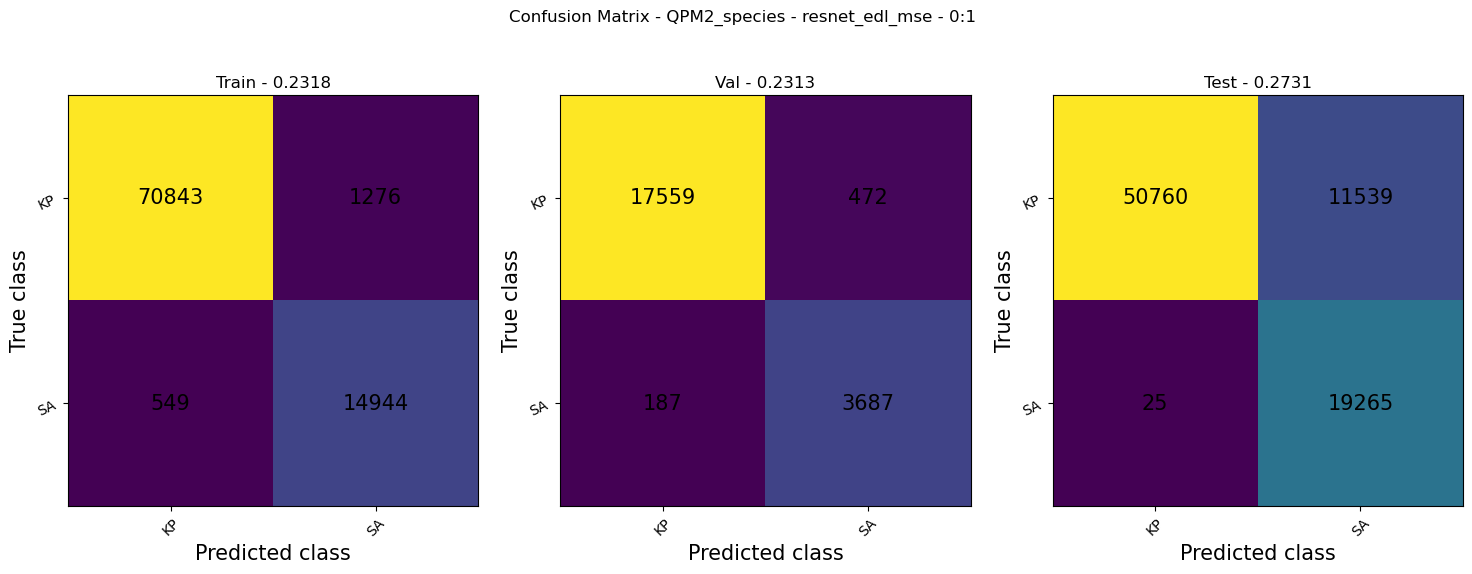

In [11]:
# compute test set accuracy
from torchmetrics import Accuracy, ConfusionMatrix

K = len(config.labels) - len(config.ood)
accuracy = Accuracy(task="multiclass", num_classes=K, top_k=1)

train_acc = accuracy(torch.as_tensor(trn_lgt_fpi.argmax(-1)), torch.as_tensor(trn_tgt)).item()
accuracy.reset()
val_acc = accuracy(torch.as_tensor(val_lgt_fpi.argmax(-1)), torch.as_tensor(val_tgt)).item()
accuracy.reset()
test_acc = accuracy(torch.as_tensor(ind_lgt_fpi.argmax(-1)), torch.as_tensor(ind_tgt)).item()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
confmat = ConfusionMatrix(task="multiclass", num_classes=K)
cm_trn = confmat(torch.as_tensor(trn_lgt.argmax(-1)), torch.as_tensor(trn_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax1)
ax1.set_title(f"Train - {train_acc:.4f}")
confmat.reset()
cm_val = confmat(torch.as_tensor(val_lgt.argmax(-1)), torch.as_tensor(val_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax2)
ax2.set_title(f"Val - {val_acc:.4f}")
confmat.reset()
cm_tst = confmat(torch.as_tensor(ind_lgt.argmax(-1)), torch.as_tensor(ind_tgt))
confmat.plot(add_text=True, labels=config.labels[:K], ax=ax3)
ax3.set_title(f"Test - {test_acc:.4f}")

plt.suptitle(f"Confusion Matrix - {dataset_name} - {model_name} - {ood_str}")
plt.show()

In [12]:
# create 2d embeddings
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

umap = UMAP(n_components=2, random_state=42)
all_emb_fpi2d = umap.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    umap = UMAP(n_components=2, random_state=42)
    all_lgt_fpi2d = umap.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(81589, 2) (78017, 2)
(81589, 2) (78017, 2)


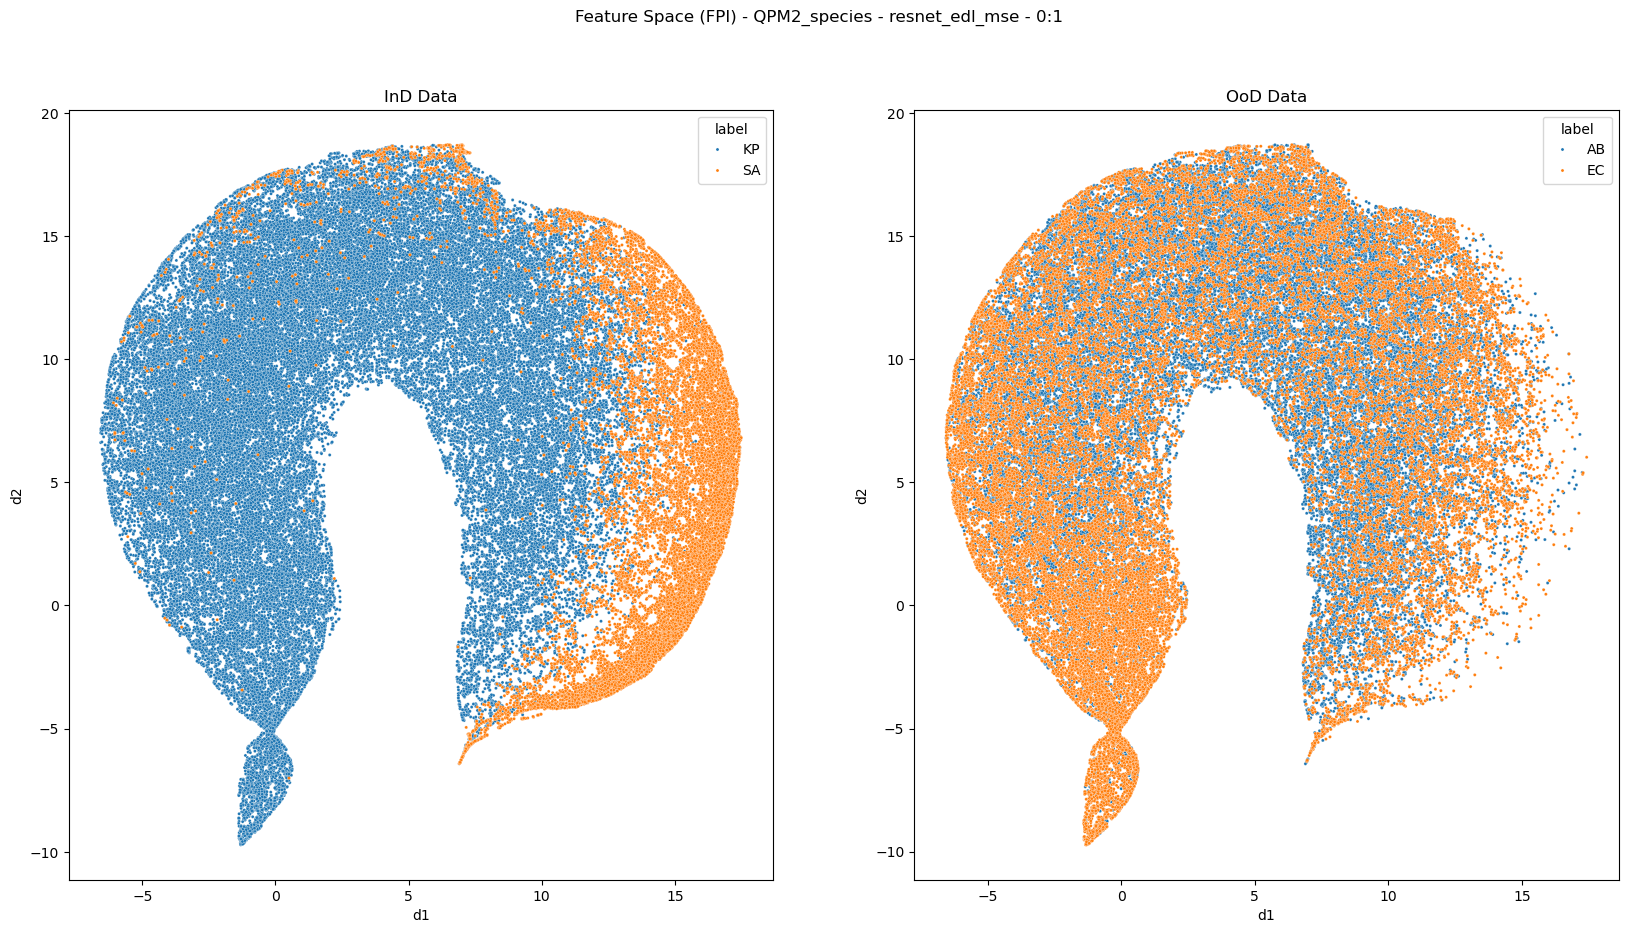

In [13]:
# plot feature space
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

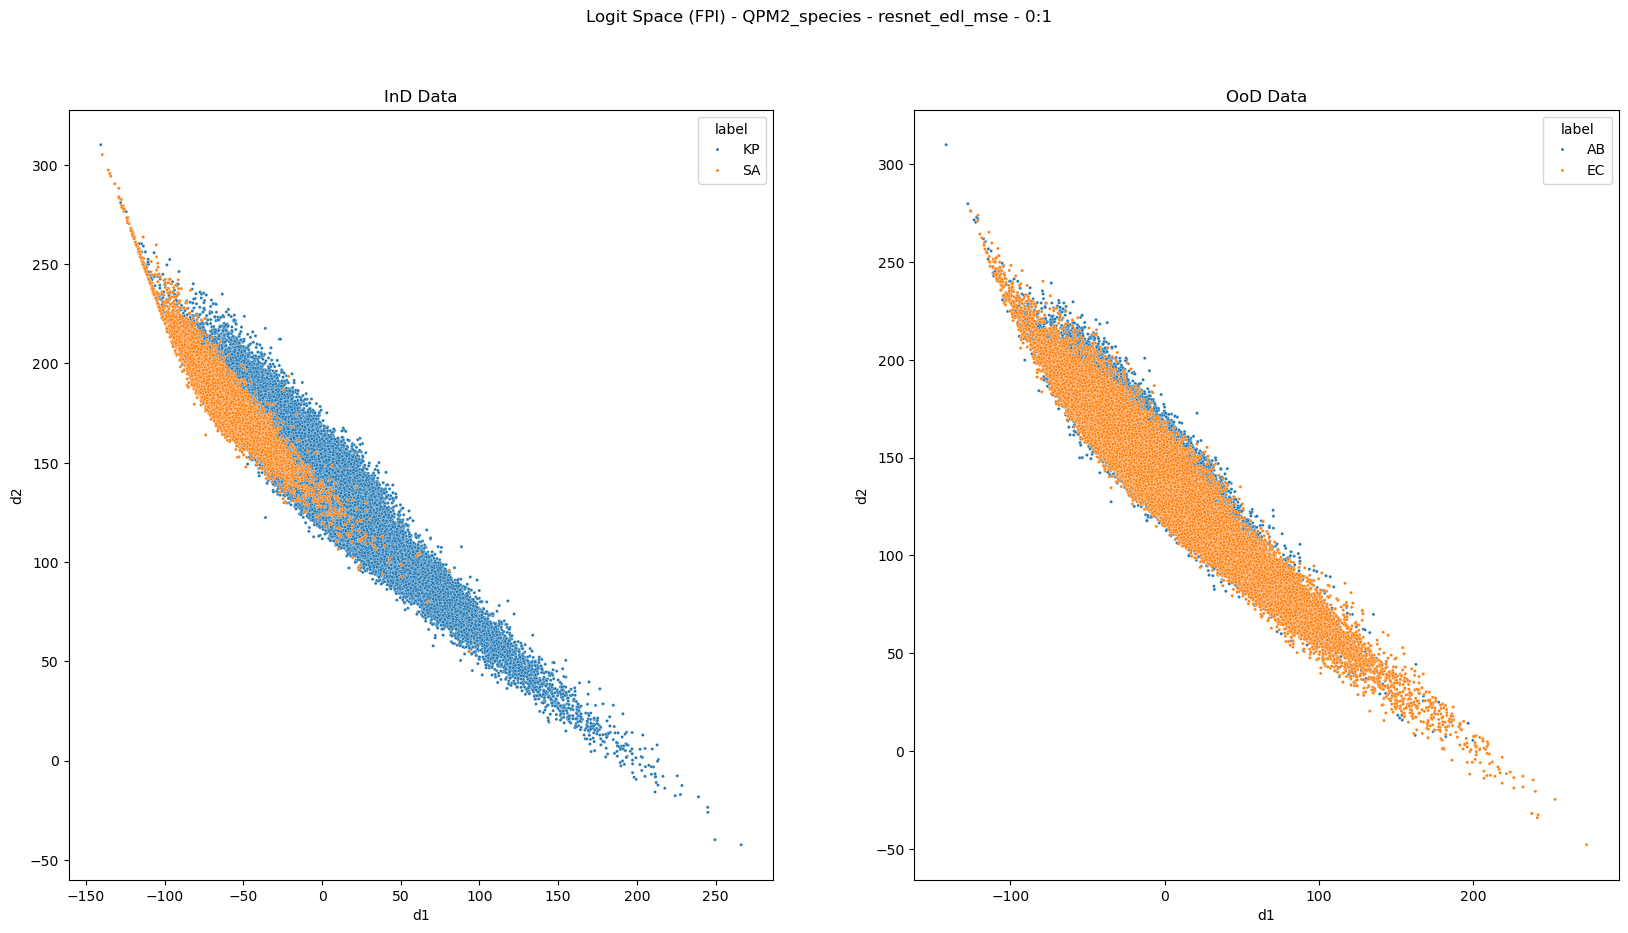

In [14]:
# plot logit space
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

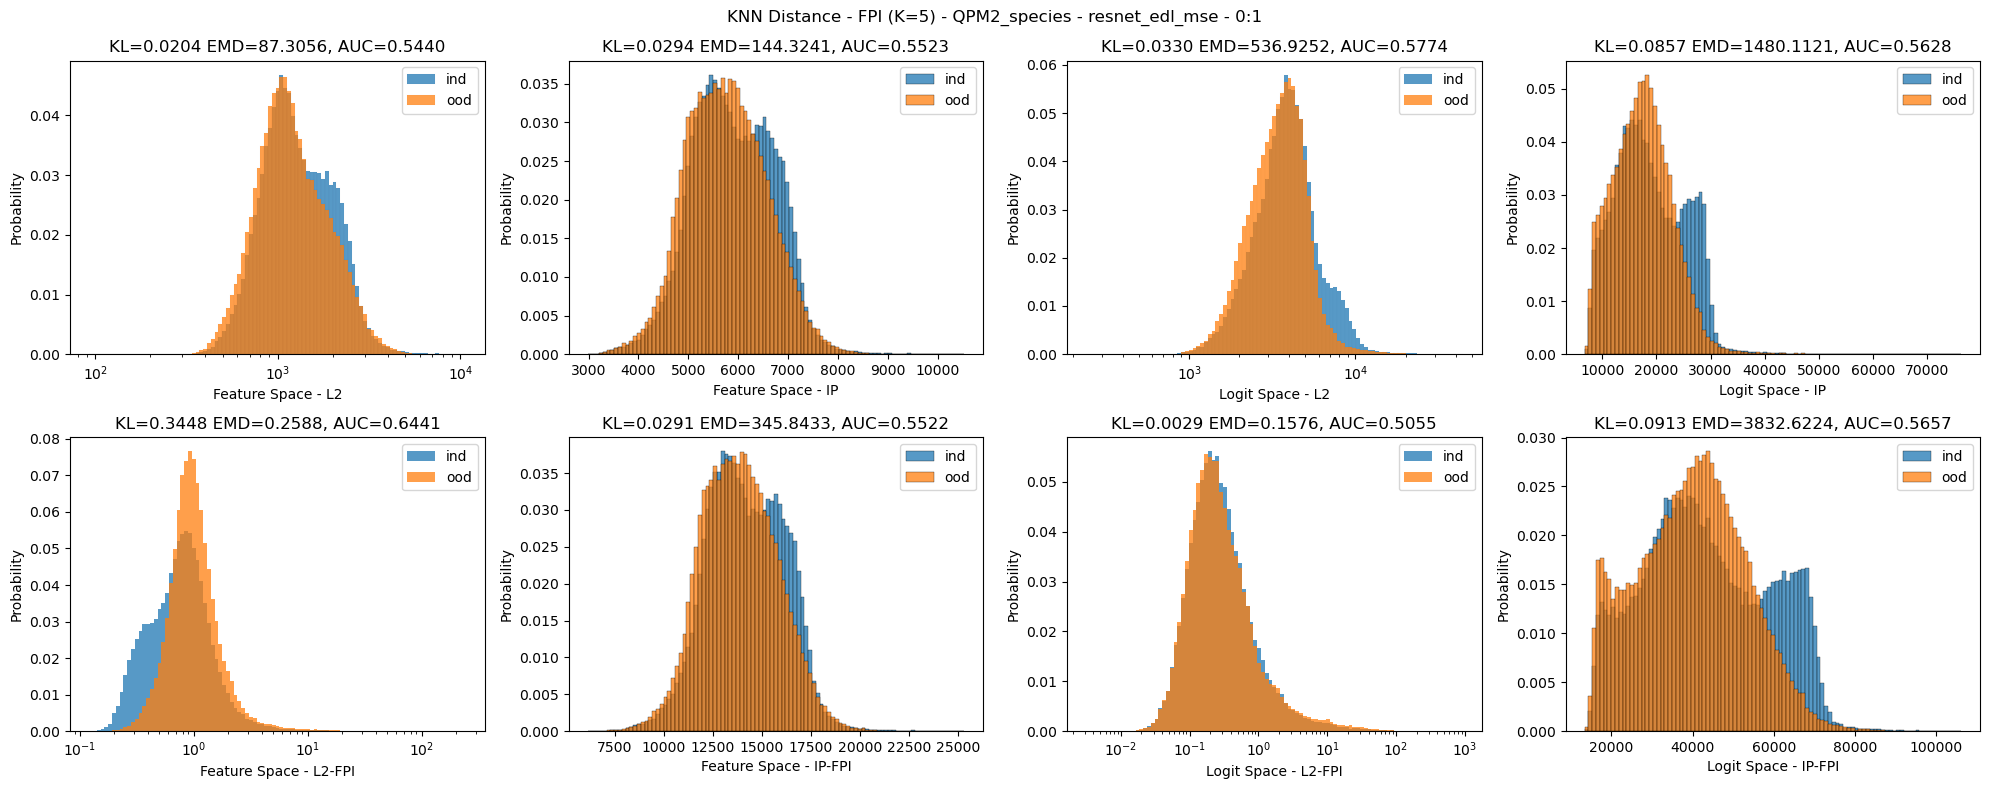

In [15]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 8))
fig.suptitle(f"KNN Distance - FPI (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()

plot_knn_dists(faiss.IndexFlatL2, axs[0][0], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[0][0].set_xlabel("Feature Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[0][1], val_emb, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[0][1].set_xlabel("Feature Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[0][2], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[0][2].set_xlabel("Logit Space - L2")
plot_knn_dists(faiss.IndexFlatIP, axs[0][3], val_lgt, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[0][3].set_xlabel("Logit Space - IP")
plot_knn_dists(faiss.IndexFlatL2, axs[1][0], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="logspace")
axs[1][0].set_xlabel("Feature Space - L2-FPI")
plot_knn_dists(faiss.IndexFlatIP, axs[1][1], val_emb_fpi, ind_emb_fpi, ood_emb_fpi if ood_str else None, scale="linspace")
axs[1][1].set_xlabel("Feature Space - IP-FPI")
plot_knn_dists(faiss.IndexFlatL2, axs[1][2], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="logspace")
axs[1][2].set_xlabel("Logit Space - L2-FPI")
plot_knn_dists(faiss.IndexFlatIP, axs[1][3], val_lgt_fpi, ind_lgt_fpi, ood_lgt_fpi if ood_str else None, scale="linspace")
axs[1][3].set_xlabel("Logit Space - IP-FPI")
plt.tight_layout()
plt.show()

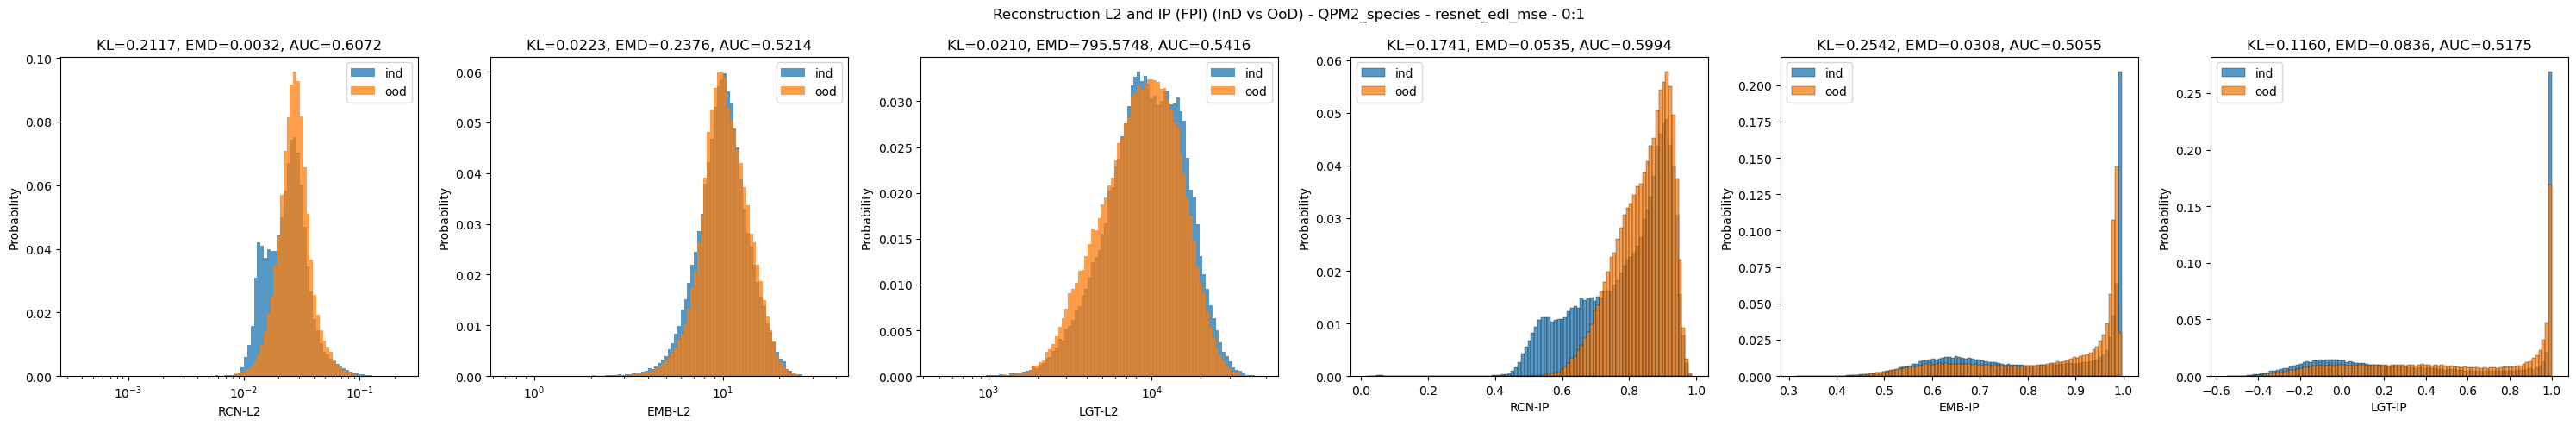

In [16]:
# plot fpi-reconstruction-based ood metrics
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))

flatten = lambda x: x.reshape((x.shape[0], -1))
unit = lambda x: x / (np.linalg.norm(x, axis=-1, keepdims=True) + 1e-7)

# data
_ind_inp = flatten(ind_inp)
_ind_rcn, _ind_emb, _ind_lgt = flatten(ind_rcn), flatten(ind_emb), flatten(ind_lgt)
_ind_rcn_fpi, _ind_emb_fpi, _ind_lgt_fpi = flatten(ind_rcn_fpi), flatten(ind_emb_fpi), flatten(ind_lgt_fpi)
# unit vectors
_ind_inp_unit = unit(_ind_inp)
_ind_rcn_unit, _ind_emb_unit, _ind_lgt_unit = unit(_ind_rcn), unit(_ind_emb), unit(_ind_lgt)
_ind_rcn_fpi_unit, _ind_emb_fpi_unit, _ind_lgt_fpi_unit = unit(_ind_rcn_fpi), unit(_ind_emb_fpi), unit(_ind_lgt_fpi)
# mse
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
# ip
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = flatten(ood_inp)
    _ood_rcn, _ood_emb, _ood_lgt = flatten(ood_rcn), flatten(ood_emb), flatten(ood_lgt)
    _ood_rcn_fpi, _ood_emb_fpi, _ood_lgt_fpi = flatten(ood_rcn_fpi), flatten(ood_emb_fpi), flatten(ood_lgt_fpi)
    # unit vectors
    _ood_inp_unit = unit(_ood_inp)
    _ood_rcn_unit, _ood_emb_unit, _ood_lgt_unit = unit(_ood_rcn), unit(_ood_emb), unit(_ood_lgt)
    _ood_rcn_fpi_unit, _ood_emb_fpi_unit, _ood_lgt_fpi_unit = unit(_ood_rcn_fpi), unit(_ood_emb_fpi), unit(_ood_lgt_fpi)
    # mse
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    # ip
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()

plot_rcn(ind_rcn_l2_fpi, ood_rcn_l2_fpi if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("RCN-L2")
plot_rcn(ind_emb_l2_fpi, ood_emb_l2_fpi if ood_str else None, ax2, scale="logspace")
ax2.set_xlabel("EMB-L2")
plot_rcn(ind_lgt_l2_fpi, ood_lgt_l2_fpi if ood_str else None, ax3, scale="logspace")
ax3.set_xlabel("LGT-L2")
plot_rcn(ind_rcn_ip_fpi, ood_rcn_ip_fpi if ood_str else None, ax4, scale="linspace")
ax4.set_xlabel("RCN-IP")
plot_rcn(ind_emb_ip_fpi, ood_emb_ip_fpi if ood_str else None, ax5, scale="linspace")
ax5.set_xlabel("EMB-IP")
plot_rcn(ind_lgt_ip_fpi, ood_lgt_ip_fpi if ood_str else None, ax6, scale="linspace")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"Reconstruction L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

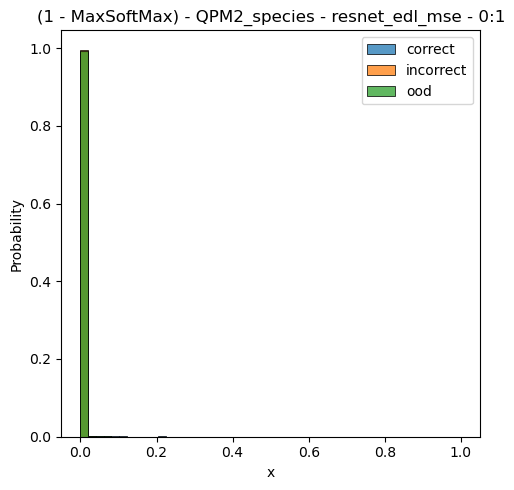

In [17]:
# plot (1 - maxsoftmax) of correct-ind, incorrect-ind, and ood data
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

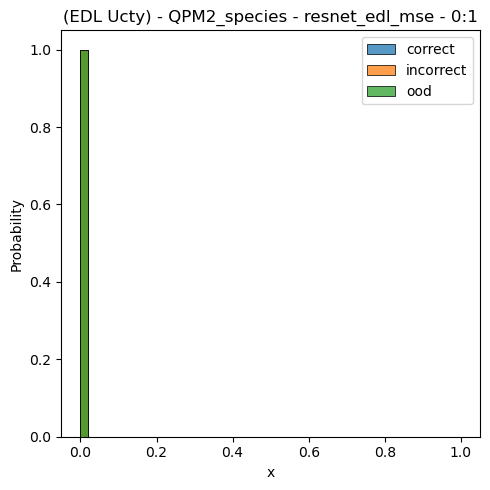

In [18]:
# plot (EDL uncertainty) of correct-ind, incorrect-ind, and ood data
K = ind_lgt_fpi.shape[-1]
ind_belief_fpi = np.clip(ind_lgt_fpi, 0, None)
ind_pred_fpi = ind_lgt_fpi.argmax(-1)
ind_prob_fpi = ind_belief_fpi / (ind_belief_fpi.sum(-1, keepdims=True) + K)
ind_ucty_fpi = K / (ind_belief_fpi.sum(-1) + K)

if ood_str:
    ood_belief_fpi = np.clip(ood_lgt_fpi, 0, None)
    ood_pred_fpi = ood_lgt_fpi.argmax(-1)
    ood_prob_fpi = ood_belief_fpi / (ood_belief_fpi.sum(-1, keepdims=True) + K)
    ood_ucty_fpi = K / (ood_belief_fpi.sum(-1) + K)

df_t = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df = pd.concat([df_t, df_f], ignore_index=True)
if ood_str:
    df_o = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df = pd.concat([df, df_o], ignore_index=True)
df_bins = np.linspace(0, 1, 50)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t, x="x", label="correct", stat="probability", bins=df_bins, ax=ax)
sns.histplot(df_f, x="x", label="incorrect", stat="probability", bins=df_bins, ax=ax)
if ood_str:
    sns.histplot(df_o, x="x", label="ood", stat="probability", bins=df_bins, ax=ax)
plt.legend()
plt.title(f"(EDL Ucty) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()